## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

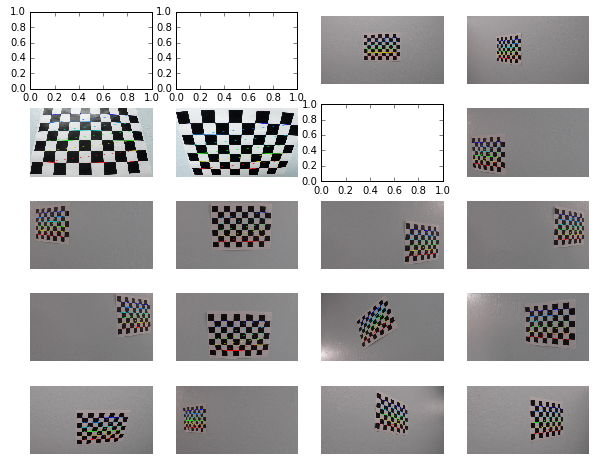

In [3]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

fig, axes = plt.subplots(5, 4, figsize=(10, 8))

# Step through the list and search for chessboard corners
for ax, fname in zip(axes.flat, images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
        ax.axis('off')
        ax.imshow(img)

cv2.destroyAllWindows()

## Undirsorting images
Display the undistortion result on the examples of chessboard and real-world images and saving the undistortion parameters for future use:
* Camera Matrix
* Distortion coefficient

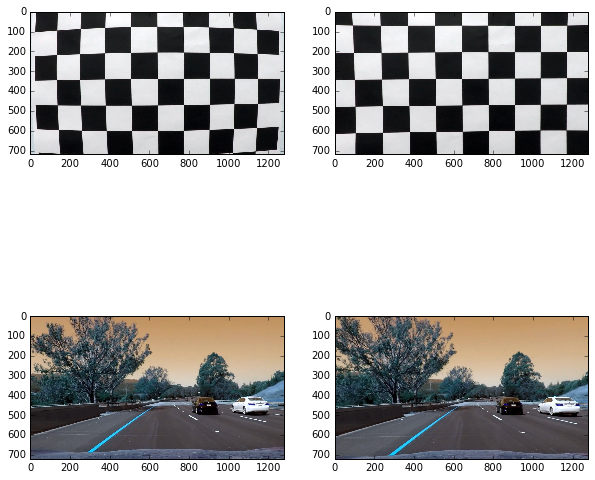

In [4]:
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

real_img = cv2.imread('./test_images/test6.jpg')
real_dst = cv2.undistort(real_img, mtx, dist, None, mtx)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for ax, img in zip(axes.flat, [img, dst, real_img, real_dst]):
    ax.imshow(img)
    
pickle.dump(
    {
        'mtx': mtx,
        'dist': dist
    }, open('./calibration.p', 'wb')
)

## Transform perspective

In [5]:
def region_of_interest_coords(shape):
    width, height = shape[1], shape[0]
    
    vertical_mark = 0.63
    top, bottom, trapezoid_height = vertical_mark * height, height, (1 - vertical_mark) * height
    
    padding = 0.07
    bottom_left, bottom_right = padding * width, (1 - padding) * width
    
    # trapezoid_ratio = 0.22
    trapezoid_ratio = 0.15
    trapezoid_length = bottom_right - bottom_left
    top_length = trapezoid_length * trapezoid_ratio
    trapezoid_offset = (trapezoid_length - top_length) / 2
    top_left, top_right = bottom_left + trapezoid_offset, bottom_right - trapezoid_offset
    
    trapezoid_coords = np.float32([
        [top_left, top], [top_right, top],
        [bottom_right, bottom], [bottom_left, bottom]
    ])
    
    return trapezoid_coords

In [6]:
def dst_coords(shape):
    width, height = shape[1], shape[0]
    offset = width * 0.07
    
    return np.float32([
        [offset, 0], [width - offset, 0],
        [width - offset, height], [offset, height] 
    ])

In [7]:
def draw_lines(img, coords):
    lines = zip(
        coords,
        np.insert(coords[:-1], 0, coords[-1], axis=0)
    )
        
    for x, y in lines:
        x = tuple(x)
        y = tuple(y)
        cv2.line(img, x, y, [255, 0, 0], 3)
        
    return img

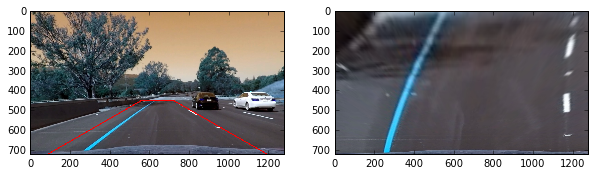

In [8]:
calibration_parameters = pickle.load( open('./calibration.p', 'rb' ) )
mtx = calibration_parameters['mtx']
dist = calibration_parameters['dist']

lanes_image = cv2.imread('./test_images/test6.jpg')
undistorted = cv2.undistort(lanes_image, mtx, dist, None, mtx)
gray = cv2.cvtColor(undistorted, cv2.COLOR_BGR2GRAY)

src = region_of_interest_coords(undistorted.shape)
dst = dst_coords(undistorted.shape)
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(
    undistorted, M, 
    (undistorted.shape[1], undistorted.shape[0])
)

undistorted_lines = draw_lines(undistorted, src)

fig, axes = plt.subplots(1, 2, figsize=(10, 10))
for ax, img in zip(axes.flat, [undistorted_lines, warped]):
    ax.imshow(img)

##Color transformation

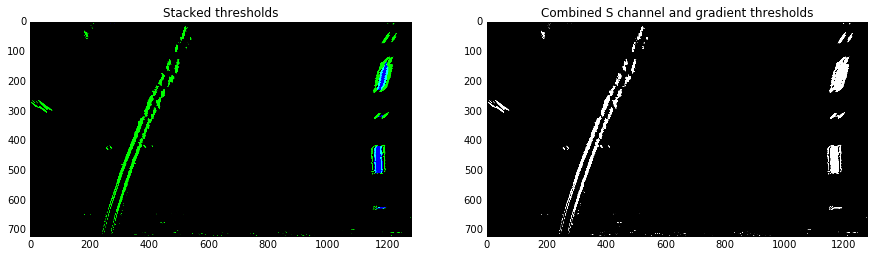

In [9]:
def color_transformation(img):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # Tried L channel, and it actually works better
    s_channel = hls[:,:,1]
    
    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    # sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    thresh_min = 30
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # Threshold color channel
    s_thresh_min = 190
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary, combined_binary

# color_binary, combined_binary = color_transformation_udacity( cv2.imread('./test_images/test5.jpg') )
color_binary, combined_binary = color_transformation( warped )

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

##Finding lanes

In [10]:
def polyfit(binary_warped, xm_per_pix=1, ym_per_pix=1):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_fit_m = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_m = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
    
    return left_fit, right_fit, left_fit_m, right_fit_m

##Calculating curvature

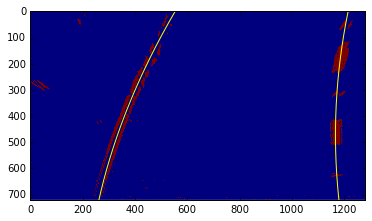

In [11]:
left_fit, right_fit, left_fit_m, right_fit_m = polyfit(combined_binary, xm_per_pix=3.7/700, ym_per_pix=30/720)

def plot_fit(left_fit, right_fit, combined_binary):
    # Generate x and y values for plotting
    ploty = np.linspace(0, combined_binary.shape[0]-1, combined_binary.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    # out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(combined_binary)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

plot_fit(left_fit, right_fit, combined_binary)

ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

In [13]:
def curvature_radius(y_eval, left_fit, right_fit, xm_per_pix=3.7/700, ym_per_pix=30/720):
    # Calculate the new radii of curvature
        
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

##Entire pipeline

Left curve radius before filtering: 347 m
Right curve radius before filtering: 451 m
Left curve radius after filtering: 347 m
Right curve radius after filtering: 451 m
Left curve radius: 347 m
Right curve radius: 451 m


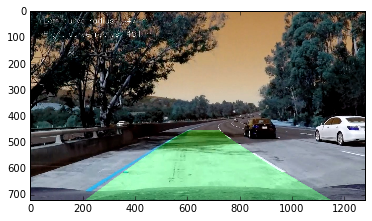

In [27]:
def detect_lanes(img):

    calibration_parameters = pickle.load( open('./calibration.p', 'rb' ) )
    mtx = calibration_parameters['mtx']
    dist = calibration_parameters['dist']

    undistorted = cv2.undistort(img, mtx, dist, None, mtx)

    src = region_of_interest_coords(undistorted.shape)
    dst = dst_coords(undistorted.shape)

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective( undistorted, M, (undistorted.shape[1], undistorted.shape[0]) )

    color_binary, combined_binary = color_transformation(warped)

    left_fit, right_fit, left_fit_m, right_fit_m = polyfit(combined_binary, xm_per_pix=3.7/700, ym_per_pix=30/720)
    
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    y_eval = np.max(ploty)
    left_curverad, right_curverad = curvature_radius(y_eval, left_fit_m, right_fit_m, xm_per_pix=3.7/700, ym_per_pix=30/720)
        
    return left_fit, right_fit, left_curverad, right_curverad

def draw_lanes(img, left_fit, right_fit, left_curverad, right_curverad):
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    color_warp = np.zeros_like(img).astype(np.uint8)
    
    # Calculate points.
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    res_image = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

    cv2.putText(res_image, 'Left curve radius: {:.0f} m'.format(left_curverad), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255))
    cv2.putText(res_image, 'Right curve radius: {:.0f} m'.format(right_curverad), (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255))
    
    print('Left curve radius: {:.0f} m'.format(left_curverad))
    print('Right curve radius: {:.0f} m'.format(right_curverad))
    
    return res_image

class Buf(object):
    def __init__(self, value, length):
        self.buf = np.repeat(value, length)
        
    def append(self, item):
        self.buf = np.insert(self.buf[:-1], 0, item, axis=0)
        
    def filter(self):
        filtered_buf = self.buf[abs(self.buf - np.mean(self.buf)) < 5 * np.std(self.buf)]        
        
class Bufs(object):
    def __init__(self, length):
        self.bufs = None
        self.length = length
    
    def append(self, items):
        if not self.bufs:
            self.bufs = [Buf(item, self.length) for item in items]
            return
        
        for buf, item in zip(self.bufs, items):
            buf.append(item)
    
    def average(self):
        return [
            np.average(buf.buf)
            for buf in self.bufs
        ]
    
    def filter(self):
        for buf in self.bufs:
            buf.filter()
    
bufs = Bufs(25)
def video_pipeline(img):
    left_fit, right_fit, left_curverad, right_curverad = detect_lanes(img)
    
    if left_curverad / right_curverad > 0.7 and left_curverad / right_curverad < 1.5: 
        bufs.append([
            left_fit[0], left_fit[1], left_fit[2],
            right_fit[0], right_fit[1], right_fit[2], 
            left_curverad,
            right_curverad
        ])
    
    print('Left curve radius before filtering: {:.0f} m'.format(left_curverad))
    print('Right curve radius before filtering: {:.0f} m'.format(right_curverad))
    
    bufs.filter()
    
    [left_fit[0], left_fit[1], left_fit[2],
    right_fit[0], right_fit[1], right_fit[2], 
    left_curverad,
    right_curverad] = bufs.average()
    
    print('Left curve radius after filtering: {:.0f} m'.format(left_curverad))
    print('Right curve radius after filtering: {:.0f} m'.format(right_curverad))
    
    res_image = draw_lanes(img, left_fit, right_fit, left_curverad, right_curverad)
    return res_image

res_image = video_pipeline(cv2.imread('./test_images/test5.jpg'))
plt.imshow(res_image)

##Video

In [28]:
from moviepy.editor import VideoFileClip
white_output = './output_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")

white_clip = clip1.fl_image(video_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Left curve radius before filtering: 414 m
Right curve radius before filtering: 434 m
Left curve radius after filtering: 349 m
Right curve radius after filtering: 450 m
Left curve radius: 349 m
Right curve radius: 450 m
[MoviePy] >>>> Building video ./output_video.mp4


[MoviePy] Writing video ./output_video.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

Left curve radius before filtering: 414 m
Right curve radius before filtering: 434 m
Left curve radius after filtering: 352 m
Right curve radius after filtering: 450 m
Left curve radius: 352 m
Right curve radius: 450 m
Left curve radius before filtering: 406 m
Right curve radius before filtering: 468 m
Left curve radius after filtering: 354 m
Right curve radius after filtering: 450 m


  0%|          | 2/1261 [00:00<01:56, 10.81it/s]

Left curve radius: 354 m
Right curve radius: 450 m


Left curve radius before filtering: 398 m
Right curve radius before filtering: 455 m
Left curve radius after filtering: 356 m
Right curve radius after filtering: 451 m
Left curve radius: 356 m
Right curve radius: 451 m


  0%|          | 4/1261 [00:00<01:54, 10.99it/s]

Left curve radius before filtering: 381 m
Right curve radius before filtering: 464 m
Left curve radius after filtering: 358 m
Right curve radius after filtering: 451 m
Left curve radius: 358 m
Right curve radius: 451 m


Left curve radius before filtering: 379 m
Right curve radius before filtering: 471 m
Left curve radius after filtering: 359 m
Right curve radius after filtering: 452 m
Left curve radius: 359 m
Right curve radius: 452 m


  0%|          | 6/1261 [00:00<01:54, 10.99it/s]

Left curve radius before filtering: 398 m
Right curve radius before filtering: 389 m
Left curve radius after filtering: 361 m
Right curve radius after filtering: 449 m
Left curve radius: 361 m
Right curve radius: 449 m


Left curve radius before filtering: 428 m
Right curve radius before filtering: 409 m
Left curve radius after filtering: 364 m
Right curve radius after filtering: 448 m
Left curve radius: 364 m
Right curve radius: 448 m


  1%|          | 8/1261 [00:00<01:53, 11.03it/s]

Left curve radius before filtering: 444 m
Right curve radius before filtering: 487 m
Left curve radius after filtering: 368 m
Right curve radius after filtering: 449 m
Left curve radius: 368 m
Right curve radius: 449 m


Left curve radius before filtering: 471 m
Right curve radius before filtering: 556 m
Left curve radius after filtering: 373 m
Right curve radius after filtering: 453 m
Left curve radius: 373 m
Right curve radius: 453 m


  1%|          | 10/1261 [00:00<01:53, 11.05it/s]

Left curve radius before filtering: 488 m
Right curve radius before filtering: 650 m
Left curve radius after filtering: 379 m
Right curve radius after filtering: 461 m
Left curve radius: 379 m
Right curve radius: 461 m


  1%|          | 11/1261 [00:01<01:57, 10.65it/s]

Left curve radius before filtering: 496 m
Right curve radius before filtering: 551 m
Left curve radius after filtering: 385 m
Right curve radius after filtering: 465 m
Left curve radius: 385 m
Right curve radius: 465 m


Left curve radius before filtering: 568 m
Right curve radius before filtering: 583 m
Left curve radius after filtering: 394 m
Right curve radius after filtering: 471 m
Left curve radius: 394 m
Right curve radius: 471 m


  1%|          | 13/1261 [00:01<01:54, 10.85it/s]

Left curve radius before filtering: 605 m
Right curve radius before filtering: 578 m
Left curve radius after filtering: 404 m
Right curve radius after filtering: 476 m
Left curve radius: 404 m
Right curve radius: 476 m


Left curve radius before filtering: 629 m
Right curve radius before filtering: 598 m
Left curve radius after filtering: 415 m
Right curve radius after filtering: 482 m
Left curve radius: 415 m
Right curve radius: 482 m


  1%|          | 15/1261 [00:01<01:55, 10.80it/s]

Left curve radius before filtering: 485 m
Right curve radius before filtering: 583 m
Left curve radius after filtering: 421 m
Right curve radius after filtering: 487 m
Left curve radius: 421 m
Right curve radius: 487 m


Left curve radius before filtering: 474 m
Right curve radius before filtering: 580 m
Left curve radius after filtering: 426 m
Right curve radius after filtering: 492 m
Left curve radius: 426 m
Right curve radius: 492 m


  1%|▏         | 17/1261 [00:01<01:53, 10.96it/s]

Left curve radius before filtering: 531 m
Right curve radius before filtering: 602 m
Left curve radius after filtering: 433 m
Right curve radius after filtering: 498 m
Left curve radius: 433 m
Right curve radius: 498 m


Left curve radius before filtering: 540 m
Right curve radius before filtering: 597 m
Left curve radius after filtering: 441 m
Right curve radius after filtering: 504 m
Left curve radius: 441 m
Right curve radius: 504 m


  2%|▏         | 19/1261 [00:01<01:52, 11.08it/s]

Left curve radius before filtering: 570 m
Right curve radius before filtering: 493 m
Left curve radius after filtering: 450 m
Right curve radius after filtering: 506 m
Left curve radius: 450 m
Right curve radius: 506 m


Left curve radius before filtering: 600 m
Right curve radius before filtering: 447 m
Left curve radius after filtering: 460 m
Right curve radius after filtering: 505 m
Left curve radius: 460 m
Right curve radius: 505 m


  2%|▏         | 21/1261 [00:01<01:51, 11.11it/s]

Left curve radius before filtering: 651 m
Right curve radius before filtering: 488 m
Left curve radius after filtering: 472 m
Right curve radius after filtering: 507 m
Left curve radius: 472 m
Right curve radius: 507 m


Left curve radius before filtering: 657 m
Right curve radius before filtering: 538 m
Left curve radius after filtering: 485 m
Right curve radius after filtering: 510 m
Left curve radius: 485 m
Right curve radius: 510 m


Left curve radius before filtering: 703 m
Right curve radius before filtering: 616 m
Left curve radius after filtering: 499 m
Right curve radius after filtering: 517 m


  2%|▏         | 23/1261 [00:02<01:54, 10.82it/s]

Left curve radius: 499 m
Right curve radius: 517 m
Left curve radius before filtering: 604 m
Right curve radius before filtering: 480 m
Left curve radius after filtering: 509 m
Right curve radius after filtering: 518 m


Left curve radius: 509 m
Right curve radius: 518 m
Left curve radius before filtering: 509 m
Right curve radius before filtering: 478 m
Left curve radius after filtering: 513 m
Right curve radius after filtering: 520 m
Left curve radius: 513 m
Right curve radius: 520 m


  2%|▏         | 25/1261 [00:02<01:55, 10.70it/s]

Left curve radius before filtering: 537 m
Right curve radius before filtering: 466 m
Left curve radius after filtering: 518 m
Right curve radius after filtering: 521 m
Left curve radius: 518 m
Right curve radius: 521 m


  2%|▏         | 27/1261 [00:02<01:53, 10.89it/s]

Left curve radius before filtering: 487 m
Right curve radius before filtering: 444 m
Left curve radius after filtering: 521 m
Right curve radius after filtering: 520 m
Left curve radius: 521 m
Right curve radius: 520 m
Left curve radius before filtering: 534 m
Right curve radius before filtering: 482 m
Left curve radius after filtering: 527 m
Right curve radius after filtering: 521 m
Left curve radius: 527 m
Right curve radius: 521 m


  2%|▏         | 29/1261 [00:02<01:53, 10.81it/s]

Left curve radius before filtering: 488 m
Right curve radius before filtering: 475 m
Left curve radius after filtering: 531 m
Right curve radius after filtering: 522 m
Left curve radius: 531 m
Right curve radius: 522 m


  2%|▏         | 31/1261 [00:02<01:54, 10.78it/s]

Left curve radius before filtering: 420 m
Right curve radius before filtering: 470 m
Left curve radius after filtering: 533 m
Right curve radius after filtering: 522 m
Left curve radius: 533 m
Right curve radius: 522 m
Left curve radius before filtering: 396 m
Right curve radius before filtering: 482 m
Left curve radius after filtering: 533 m
Right curve radius after filtering: 525 m
Left curve radius: 533 m
Right curve radius: 525 m


Left curve radius before filtering: 361 m
Right curve radius before filtering: 377 m
Left curve radius after filtering: 530 m
Right curve radius after filtering: 524 m
Left curve radius: 530 m
Right curve radius: 524 m


  3%|▎         | 33/1261 [00:03<01:50, 11.08it/s]

Left curve radius before filtering: 379 m
Right curve radius before filtering: 427 m
Left curve radius after filtering: 527 m
Right curve radius after filtering: 522 m
Left curve radius: 527 m
Right curve radius: 522 m
Left curve radius before filtering: 356 m
Right curve radius before filtering: 462 m
Left curve radius after filtering: 523 m
Right curve radius after filtering: 518 m
Left curve radius: 523 m
Right curve radius: 518 m


  3%|▎         | 35/1261 [00:03<01:49, 11.15it/s]

Left curve radius before filtering: 355 m
Right curve radius before filtering: 527 m
Left curve radius after filtering: 523 m
Right curve radius after filtering: 518 m
Left curve radius: 523 m
Right curve radius: 518 m


  3%|▎         | 37/1261 [00:03<01:47, 11.33it/s]

Left curve radius before filtering: 334 m
Right curve radius before filtering: 455 m
Left curve radius after filtering: 517 m
Right curve radius after filtering: 510 m
Left curve radius: 517 m
Right curve radius: 510 m
Left curve radius before filtering: 316 m
Right curve radius before filtering: 435 m
Left curve radius after filtering: 509 m
Right curve radius after filtering: 505 m
Left curve radius: 509 m
Right curve radius: 505 m


Left curve radius before filtering: 301 m
Right curve radius before filtering: 352 m
Left curve radius after filtering: 499 m
Right curve radius after filtering: 496 m
Left curve radius: 499 m
Right curve radius: 496 m


  3%|▎         | 39/1261 [00:03<01:52, 10.84it/s]

Left curve radius before filtering: 301 m
Right curve radius before filtering: 332 m
Left curve radius after filtering: 487 m
Right curve radius after filtering: 486 m
Left curve radius: 487 m
Right curve radius: 486 m
Left curve radius before filtering: 310 m
Right curve radius before filtering: 364 m
Left curve radius after filtering: 474 m
Right curve radius after filtering: 477 m


Left curve radius: 474 m
Right curve radius: 477 m
Left curve radius before filtering: 288 m
Right curve radius before filtering: 376 m
Left curve radius after filtering: 466 m
Right curve radius after filtering: 469 m


  3%|▎         | 41/1261 [00:03<01:56, 10.45it/s]

Left curve radius: 466 m
Right curve radius: 469 m


Left curve radius before filtering: 292 m
Right curve radius before filtering: 405 m
Left curve radius after filtering: 459 m
Right curve radius after filtering: 462 m
Left curve radius: 459 m
Right curve radius: 462 m


  3%|▎         | 43/1261 [00:03<02:02,  9.91it/s]

Left curve radius before filtering: 306 m
Right curve radius before filtering: 425 m
Left curve radius after filtering: 450 m
Right curve radius after filtering: 455 m
Left curve radius: 450 m
Right curve radius: 455 m
Left curve radius before filtering: 319 m
Right curve radius before filtering: 340 m
Left curve radius after filtering: 441 m
Right curve radius after filtering: 444 m


Left curve radius: 441 m
Right curve radius: 444 m
Left curve radius before filtering: 333 m
Right curve radius before filtering: 342 m
Left curve radius after filtering: 431 m
Right curve radius after filtering: 438 m


  4%|▎         | 45/1261 [00:04<02:02,  9.90it/s]

Left curve radius: 431 m
Right curve radius: 438 m


  4%|▎         | 46/1261 [00:04<02:09,  9.35it/s]

Left curve radius before filtering: 372 m
Right curve radius before filtering: 337 m
Left curve radius after filtering: 422 m
Right curve radius after filtering: 434 m
Left curve radius: 422 m
Right curve radius: 434 m


  4%|▎         | 47/1261 [00:04<02:11,  9.22it/s]

Left curve radius before filtering: 393 m
Right curve radius before filtering: 354 m
Left curve radius after filtering: 412 m
Right curve radius after filtering: 429 m
Left curve radius: 412 m
Right curve radius: 429 m


  4%|▍         | 48/1261 [00:04<02:26,  8.31it/s]

Left curve radius before filtering: 401 m
Right curve radius before filtering: 378 m
Left curve radius after filtering: 402 m
Right curve radius after filtering: 422 m
Left curve radius: 402 m
Right curve radius: 422 m


  4%|▍         | 49/1261 [00:04<02:23,  8.47it/s]

Left curve radius before filtering: 409 m
Right curve radius before filtering: 435 m
Left curve radius after filtering: 390 m
Right curve radius after filtering: 415 m
Left curve radius: 390 m
Right curve radius: 415 m


  4%|▍         | 50/1261 [00:04<02:30,  8.05it/s]

Left curve radius before filtering: 429 m
Right curve radius before filtering: 377 m
Left curve radius after filtering: 383 m
Right curve radius after filtering: 411 m
Left curve radius: 383 m
Right curve radius: 411 m


  4%|▍         | 51/1261 [00:04<02:32,  7.95it/s]

Left curve radius before filtering: 469 m
Right curve radius before filtering: 352 m
Left curve radius after filtering: 381 m
Right curve radius after filtering: 406 m
Left curve radius: 381 m
Right curve radius: 406 m


  4%|▍         | 52/1261 [00:05<02:45,  7.30it/s]

Left curve radius before filtering: 506 m
Right curve radius before filtering: 416 m
Left curve radius after filtering: 380 m
Right curve radius after filtering: 404 m
Left curve radius: 380 m
Right curve radius: 404 m


  4%|▍         | 53/1261 [00:05<02:41,  7.49it/s]

Left curve radius before filtering: 449 m
Right curve radius before filtering: 391 m
Left curve radius after filtering: 379 m
Right curve radius after filtering: 402 m
Left curve radius: 379 m
Right curve radius: 402 m


  4%|▍         | 54/1261 [00:05<02:34,  7.82it/s]

Left curve radius before filtering: 481 m
Right curve radius before filtering: 404 m
Left curve radius after filtering: 376 m
Right curve radius after filtering: 399 m
Left curve radius: 376 m
Right curve radius: 399 m


  4%|▍         | 55/1261 [00:05<02:27,  8.18it/s]

Left curve radius before filtering: 537 m
Right curve radius before filtering: 427 m
Left curve radius after filtering: 378 m
Right curve radius after filtering: 397 m
Left curve radius: 378 m
Right curve radius: 397 m


  4%|▍         | 56/1261 [00:05<02:28,  8.10it/s]

Left curve radius before filtering: 587 m
Right curve radius before filtering: 457 m
Left curve radius after filtering: 385 m
Right curve radius after filtering: 396 m
Left curve radius: 385 m
Right curve radius: 396 m


  5%|▍         | 57/1261 [00:05<02:42,  7.43it/s]

Left curve radius before filtering: 607 m
Right curve radius before filtering: 409 m
Left curve radius after filtering: 394 m
Right curve radius after filtering: 393 m
Left curve radius: 394 m
Right curve radius: 393 m


Left curve radius before filtering: 613 m
Right curve radius before filtering: 451 m
Left curve radius after filtering: 404 m
Right curve radius after filtering: 396 m


  5%|▍         | 58/1261 [00:05<03:05,  6.47it/s]

Left curve radius: 404 m
Right curve radius: 396 m
Left curve radius before filtering: 538 m
Right curve radius before filtering: 391 m
Left curve radius after filtering: 410 m
Right curve radius after filtering: 395 m
Left curve radius: 410 m
Right curve radius: 395 m


  5%|▍         | 59/1261 [00:06<03:14,  6.18it/s]

  5%|▍         | 60/1261 [00:06<03:02,  6.59it/s]

  5%|▍         | 61/1261 [00:06<02:46,  7.22it/s]

Left curve radius before filtering: 499 m
Right curve radius before filtering: 472 m
Left curve radius after filtering: 416 m
Right curve radius after filtering: 395 m
Left curve radius: 416 m
Right curve radius: 395 m
Left curve radius before filtering: 487 m
Right curve radius before filtering: 458 m
Left curve radius after filtering: 422 m
Right curve radius after filtering: 395 m
Left curve radius: 422 m
Right curve radius: 395 m
Left curve radius before filtering: 470 m
Right curve radius before filtering: 459 m
Left curve radius after filtering: 428 m
Right curve radius after filtering: 396 m


  5%|▍         | 63/1261 [00:06<02:32,  7.85it/s]

Left curve radius: 428 m
Right curve radius: 396 m
Left curve radius before filtering: 467 m
Right curve radius before filtering: 455 m
Left curve radius after filtering: 435 m
Right curve radius after filtering: 400 m
Left curve radius: 435 m
Right curve radius: 400 m
Left curve radius before filtering: 455 m
Right curve radius before filtering: 478 m
Left curve radius after filtering: 441 m
Right curve radius after filtering: 406 m


  5%|▌         | 65/1261 [00:06<02:21,  8.45it/s]

Left curve radius: 441 m
Right curve radius: 406 m
Left curve radius before filtering: 474 m
Right curve radius before filtering: 543 m
Left curve radius after filtering: 447 m
Right curve radius after filtering: 413 m
Left curve radius: 447 m
Right curve radius: 413 m
Left curve radius before filtering: 398 m
Right curve radius before filtering: 587 m
Left curve radius after filtering: 447 m
Right curve radius after filtering: 413 m
Left curve radius: 447 m
Right curve radius: 413 m


  5%|▌         | 67/1261 [00:06<02:12,  8.98it/s]

  5%|▌         | 69/1261 [00:07<02:05,  9.50it/s]

Left curve radius before filtering: 379 m
Right curve radius before filtering: 594 m
Left curve radius after filtering: 447 m
Right curve radius after filtering: 413 m
Left curve radius: 447 m
Right curve radius: 413 m
Left curve radius before filtering: 426 m
Right curve radius before filtering: 660 m
Left curve radius after filtering: 447 m
Right curve radius after filtering: 413 m
Left curve radius: 447 m
Right curve radius: 413 m
Left curve radius before filtering: 415 m
Right curve radius before filtering: 635 m
Left curve radius after filtering: 447 m
Right curve radius after filtering: 413 m
Left curve radius: 447 m
Right curve radius: 413 m


  6%|▌         | 71/1261 [00:07<02:00,  9.84it/s]

Left curve radius before filtering: 431 m
Right curve radius before filtering: 563 m
Left curve radius after filtering: 453 m
Right curve radius after filtering: 421 m
Left curve radius: 453 m
Right curve radius: 421 m
Left curve radius before filtering: 552 m
Right curve radius before filtering: 442 m
Left curve radius after filtering: 463 m
Right curve radius after filtering: 422 m
Left curve radius: 463 m
Right curve radius: 422 m
Left curve radius before filtering: 604 m
Right curve radius before filtering: 423 m
Left curve radius after filtering: 475 m
Right curve radius after filtering: 422 m


  6%|▌         | 73/1261 [00:07<02:02,  9.70it/s]

Left curve radius: 475 m
Right curve radius: 422 m
Left curve radius before filtering: 626 m
Right curve radius before filtering: 336 m
Left curve radius after filtering: 475 m
Right curve radius after filtering: 422 m
Left curve radius: 475 m
Right curve radius: 422 m
Left curve radius before filtering: 667 m
Right curve radius before filtering: 338 m
Left curve radius after filtering: 475 m
Right curve radius after filtering: 422 m
Left curve radius: 475 m
Right curve radius: 422 m


  6%|▌         | 75/1261 [00:07<01:56, 10.15it/s]

  6%|▌         | 77/1261 [00:07<01:53, 10.42it/s]

Left curve radius before filtering: 664 m
Right curve radius before filtering: 392 m
Left curve radius after filtering: 475 m
Right curve radius after filtering: 422 m
Left curve radius: 475 m
Right curve radius: 422 m
Left curve radius before filtering: 741 m
Right curve radius before filtering: 341 m
Left curve radius after filtering: 475 m
Right curve radius after filtering: 422 m
Left curve radius: 475 m
Right curve radius: 422 m
Left curve radius before filtering: 816 m
Right curve radius before filtering: 381 m
Left curve radius after filtering: 475 m
Right curve radius after filtering: 422 m
Left curve radius: 475 m
Right curve radius: 422 m


  6%|▋         | 79/1261 [00:08<01:50, 10.67it/s]

Left curve radius before filtering: 941 m
Right curve radius before filtering: 386 m
Left curve radius after filtering: 475 m
Right curve radius after filtering: 422 m
Left curve radius: 475 m
Right curve radius: 422 m
Left curve radius before filtering: 1048 m
Right curve radius before filtering: 419 m
Left curve radius after filtering: 475 m
Right curve radius after filtering: 422 m
Left curve radius: 475 m
Right curve radius: 422 m
Left curve radius before filtering: 1020 m
Right curve radius before filtering: 437 m
Left curve radius after filtering: 475 m
Right curve radius after filtering: 422 m
Left curve radius: 475 m
Right curve radius: 422 m


  6%|▋         | 81/1261 [00:08<01:49, 10.77it/s]

  7%|▋         | 83/1261 [00:08<01:48, 10.86it/s]

Left curve radius before filtering: 953 m
Right curve radius before filtering: 454 m
Left curve radius after filtering: 475 m
Right curve radius after filtering: 422 m
Left curve radius: 475 m
Right curve radius: 422 m
Left curve radius before filtering: 834 m
Right curve radius before filtering: 404 m
Left curve radius after filtering: 475 m
Right curve radius after filtering: 422 m
Left curve radius: 475 m
Right curve radius: 422 m
Left curve radius before filtering: 731 m
Right curve radius before filtering: 431 m
Left curve radius after filtering: 475 m
Right curve radius after filtering: 422 m
Left curve radius: 475 m
Right curve radius: 422 m


  7%|▋         | 85/1261 [00:08<01:53, 10.37it/s]

Left curve radius before filtering: 823 m
Right curve radius before filtering: 523 m
Left curve radius after filtering: 475 m
Right curve radius after filtering: 422 m
Left curve radius: 475 m
Right curve radius: 422 m
Left curve radius before filtering: 736 m
Right curve radius before filtering: 544 m
Left curve radius after filtering: 492 m
Right curve radius after filtering: 430 m
Left curve radius: 492 m
Right curve radius: 430 m
Left curve radius before filtering: 661 m
Right curve radius before filtering: 583 m
Left curve radius after filtering: 505 m
Right curve radius after filtering: 440 m


  7%|▋         | 87/1261 [00:08<01:50, 10.65it/s]

Left curve radius: 505 m
Right curve radius: 440 m
Left curve radius before filtering: 538 m
Right curve radius before filtering: 465 m
Left curve radius after filtering: 512 m
Right curve radius after filtering: 445 m
Left curve radius: 512 m
Right curve radius: 445 m
Left curve radius before filtering: 515 m
Right curve radius before filtering: 426 m
Left curve radius after filtering: 517 m
Right curve radius after filtering: 448 m
Left curve radius: 517 m
Right curve radius: 448 m


  7%|▋         | 89/1261 [00:08<01:47, 10.88it/s]

  7%|▋         | 91/1261 [00:09<01:45, 11.11it/s]

Left curve radius before filtering: 470 m
Right curve radius before filtering: 449 m
Left curve radius after filtering: 519 m
Right curve radius after filtering: 451 m
Left curve radius: 519 m
Right curve radius: 451 m
Left curve radius before filtering: 420 m
Right curve radius before filtering: 443 m
Left curve radius after filtering: 520 m
Right curve radius after filtering: 451 m
Left curve radius: 520 m
Right curve radius: 451 m
Left curve radius before filtering: 412 m
Right curve radius before filtering: 458 m
Left curve radius after filtering: 519 m
Right curve radius after filtering: 454 m
Left curve radius: 519 m
Right curve radius: 454 m


  7%|▋         | 93/1261 [00:09<01:50, 10.57it/s]

Left curve radius before filtering: 461 m
Right curve radius before filtering: 497 m
Left curve radius after filtering: 519 m
Right curve radius after filtering: 460 m
Left curve radius: 519 m
Right curve radius: 460 m
Left curve radius before filtering: 430 m
Right curve radius before filtering: 501 m
Left curve radius after filtering: 516 m
Right curve radius after filtering: 464 m
Left curve radius: 516 m
Right curve radius: 464 m
Left curve radius before filtering: 414 m
Right curve radius before filtering: 402 m
Left curve radius after filtering: 514 m
Right curve radius after filtering: 464 m


  8%|▊         | 95/1261 [00:09<01:48, 10.76it/s]

Left curve radius: 514 m
Right curve radius: 464 m
Left curve radius before filtering: 434 m
Right curve radius before filtering: 446 m
Left curve radius after filtering: 513 m
Right curve radius after filtering: 466 m
Left curve radius: 513 m
Right curve radius: 466 m
Left curve radius before filtering: 488 m
Right curve radius before filtering: 412 m
Left curve radius after filtering: 511 m
Right curve radius after filtering: 465 m
Left curve radius: 511 m
Right curve radius: 465 m


  8%|▊         | 97/1261 [00:09<01:46, 10.92it/s]

  8%|▊         | 99/1261 [00:09<01:45, 10.98it/s]

Left curve radius before filtering: 484 m
Right curve radius before filtering: 461 m
Left curve radius after filtering: 506 m
Right curve radius after filtering: 465 m
Left curve radius: 506 m
Right curve radius: 465 m
Left curve radius before filtering: 469 m
Right curve radius before filtering: 414 m
Left curve radius after filtering: 501 m
Right curve radius after filtering: 465 m
Left curve radius: 501 m
Right curve radius: 465 m
Left curve radius before filtering: 471 m
Right curve radius before filtering: 349 m
Left curve radius after filtering: 495 m
Right curve radius after filtering: 461 m
Left curve radius: 495 m
Right curve radius: 461 m


  8%|▊         | 101/1261 [00:10<01:45, 10.99it/s]

Left curve radius before filtering: 437 m
Right curve radius before filtering: 380 m
Left curve radius after filtering: 491 m
Right curve radius after filtering: 461 m
Left curve radius: 491 m
Right curve radius: 461 m
Left curve radius before filtering: 470 m
Right curve radius before filtering: 365 m
Left curve radius after filtering: 490 m
Right curve radius after filtering: 457 m
Left curve radius: 490 m
Right curve radius: 457 m
Left curve radius before filtering: 458 m
Right curve radius before filtering: 380 m
Left curve radius after filtering: 489 m
Right curve radius after filtering: 453 m
Left curve radius: 489 m
Right curve radius: 453 m


  8%|▊         | 103/1261 [00:10<01:45, 10.96it/s]

  8%|▊         | 105/1261 [00:10<01:43, 11.16it/s]

Left curve radius before filtering: 447 m
Right curve radius before filtering: 396 m
Left curve radius after filtering: 488 m
Right curve radius after filtering: 451 m
Left curve radius: 488 m
Right curve radius: 451 m
Left curve radius before filtering: 451 m
Right curve radius before filtering: 410 m
Left curve radius after filtering: 487 m
Right curve radius after filtering: 449 m
Left curve radius: 487 m
Right curve radius: 449 m
Left curve radius before filtering: 462 m
Right curve radius before filtering: 440 m
Left curve radius after filtering: 488 m
Right curve radius after filtering: 448 m
Left curve radius: 488 m
Right curve radius: 448 m


  8%|▊         | 107/1261 [00:10<01:47, 10.69it/s]

Left curve radius before filtering: 445 m
Right curve radius before filtering: 462 m
Left curve radius after filtering: 486 m
Right curve radius after filtering: 444 m
Left curve radius: 486 m
Right curve radius: 444 m
Left curve radius before filtering: 448 m
Right curve radius before filtering: 446 m
Left curve radius after filtering: 487 m
Right curve radius after filtering: 440 m
Left curve radius: 487 m
Right curve radius: 440 m


  9%|▊         | 109/1261 [00:10<01:53, 10.16it/s]

Left curve radius before filtering: 429 m
Right curve radius before filtering: 457 m
Left curve radius after filtering: 482 m
Right curve radius after filtering: 440 m
Left curve radius: 482 m
Right curve radius: 440 m
Left curve radius before filtering: 448 m
Right curve radius before filtering: 459 m
Left curve radius after filtering: 476 m
Right curve radius after filtering: 442 m
Left curve radius: 476 m
Right curve radius: 442 m
Left curve radius before filtering: 441 m
Right curve radius before filtering: 445 m
Left curve radius after filtering: 464 m
Right curve radius after filtering: 438 m


  9%|▉         | 111/1261 [00:11<01:52, 10.19it/s]

Left curve radius: 464 m
Right curve radius: 438 m
Left curve radius before filtering: 432 m
Right curve radius before filtering: 442 m
Left curve radius after filtering: 455 m
Right curve radius after filtering: 432 m
Left curve radius: 455 m
Right curve radius: 432 m
Left curve radius before filtering: 435 m
Right curve radius before filtering: 437 m
Left curve radius after filtering: 451 m
Right curve radius after filtering: 431 m
Left curve radius: 451 m
Right curve radius: 431 m


  9%|▉         | 113/1261 [00:11<01:48, 10.53it/s]

  9%|▉         | 115/1261 [00:11<01:47, 10.68it/s]

Left curve radius before filtering: 394 m
Right curve radius before filtering: 359 m
Left curve radius after filtering: 446 m
Right curve radius after filtering: 428 m
Left curve radius: 446 m
Right curve radius: 428 m
Left curve radius before filtering: 421 m
Right curve radius before filtering: 346 m
Left curve radius after filtering: 444 m
Right curve radius after filtering: 424 m
Left curve radius: 444 m
Right curve radius: 424 m
Left curve radius before filtering: 397 m
Right curve radius before filtering: 333 m
Left curve radius after filtering: 443 m
Right curve radius after filtering: 420 m
Left curve radius: 443 m
Right curve radius: 420 m


  9%|▉         | 117/1261 [00:11<01:45, 10.80it/s]

Left curve radius before filtering: 377 m
Right curve radius before filtering: 337 m
Left curve radius after filtering: 442 m
Right curve radius after filtering: 415 m
Left curve radius: 442 m
Right curve radius: 415 m
Left curve radius before filtering: 373 m
Right curve radius before filtering: 358 m
Left curve radius after filtering: 438 m
Right curve radius after filtering: 409 m
Left curve radius: 438 m
Right curve radius: 409 m
Left curve radius before filtering: 355 m
Right curve radius before filtering: 368 m
Left curve radius after filtering: 435 m
Right curve radius after filtering: 404 m
Left curve radius: 435 m
Right curve radius: 404 m


  9%|▉         | 119/1261 [00:11<01:45, 10.84it/s]

 10%|▉         | 121/1261 [00:11<01:42, 11.14it/s]

Left curve radius before filtering: 349 m
Right curve radius before filtering: 359 m
Left curve radius after filtering: 433 m
Right curve radius after filtering: 402 m
Left curve radius: 433 m
Right curve radius: 402 m
Left curve radius before filtering: 334 m
Right curve radius before filtering: 308 m
Left curve radius after filtering: 429 m
Right curve radius after filtering: 397 m
Left curve radius: 429 m
Right curve radius: 397 m
Left curve radius before filtering: 335 m
Right curve radius before filtering: 332 m
Left curve radius after filtering: 422 m
Right curve radius after filtering: 394 m
Left curve radius: 422 m
Right curve radius: 394 m


 10%|▉         | 123/1261 [00:12<01:41, 11.18it/s]

Left curve radius before filtering: 360 m
Right curve radius before filtering: 329 m
Left curve radius after filtering: 417 m
Right curve radius after filtering: 389 m
Left curve radius: 417 m
Right curve radius: 389 m
Left curve radius before filtering: 348 m
Right curve radius before filtering: 312 m
Left curve radius after filtering: 413 m
Right curve radius after filtering: 384 m
Left curve radius: 413 m
Right curve radius: 384 m
Left curve radius before filtering: 350 m
Right curve radius before filtering: 323 m
Left curve radius after filtering: 408 m
Right curve radius after filtering: 383 m
Left curve radius: 408 m
Right curve radius: 383 m


 10%|▉         | 125/1261 [00:12<01:41, 11.20it/s]

 10%|█         | 127/1261 [00:12<01:40, 11.26it/s]

Left curve radius before filtering: 345 m
Right curve radius before filtering: 317 m
Left curve radius after filtering: 404 m
Right curve radius after filtering: 381 m
Left curve radius: 404 m
Right curve radius: 381 m
Left curve radius before filtering: 388 m
Right curve radius before filtering: 348 m
Left curve radius after filtering: 401 m
Right curve radius after filtering: 380 m
Left curve radius: 401 m
Right curve radius: 380 m
Left curve radius before filtering: 389 m
Right curve radius before filtering: 330 m
Left curve radius after filtering: 398 m
Right curve radius after filtering: 378 m
Left curve radius: 398 m
Right curve radius: 378 m


 10%|█         | 129/1261 [00:12<01:39, 11.43it/s]

Left curve radius before filtering: 414 m
Right curve radius before filtering: 346 m
Left curve radius after filtering: 397 m
Right curve radius after filtering: 376 m
Left curve radius: 397 m
Right curve radius: 376 m
Left curve radius before filtering: 385 m
Right curve radius before filtering: 363 m
Left curve radius after filtering: 394 m
Right curve radius after filtering: 374 m
Left curve radius: 394 m
Right curve radius: 374 m
Left curve radius before filtering: 434 m
Right curve radius before filtering: 374 m
Left curve radius after filtering: 393 m
Right curve radius after filtering: 372 m
Left curve radius: 393 m
Right curve radius: 372 m


 10%|█         | 131/1261 [00:12<01:37, 11.56it/s]

 11%|█         | 133/1261 [00:12<01:35, 11.83it/s]

Left curve radius before filtering: 447 m
Right curve radius before filtering: 378 m
Left curve radius after filtering: 393 m
Right curve radius after filtering: 368 m
Left curve radius: 393 m
Right curve radius: 368 m
Left curve radius before filtering: 443 m
Right curve radius before filtering: 278 m
Left curve radius after filtering: 393 m
Right curve radius after filtering: 368 m
Left curve radius: 393 m
Right curve radius: 368 m
Left curve radius before filtering: 432 m
Right curve radius before filtering: 288 m
Left curve radius after filtering: 393 m
Right curve radius after filtering: 368 m
Left curve radius: 393 m
Right curve radius: 368 m


 11%|█         | 135/1261 [00:13<01:38, 11.44it/s]

Left curve radius before filtering: 424 m
Right curve radius before filtering: 397 m
Left curve radius after filtering: 392 m
Right curve radius after filtering: 366 m
Left curve radius: 392 m
Right curve radius: 366 m
Left curve radius before filtering: 451 m
Right curve radius before filtering: 343 m
Left curve radius after filtering: 393 m
Right curve radius after filtering: 362 m
Left curve radius: 393 m
Right curve radius: 362 m
Left curve radius before filtering: 459 m
Right curve radius before filtering: 377 m
Left curve radius after filtering: 393 m
Right curve radius after filtering: 359 m


 11%|█         | 137/1261 [00:13<01:43, 10.91it/s]

Left curve radius: 393 m
Right curve radius: 359 m
Left curve radius before filtering: 463 m
Right curve radius before filtering: 429 m
Left curve radius after filtering: 394 m
Right curve radius after filtering: 358 m
Left curve radius: 394 m
Right curve radius: 358 m
Left curve radius before filtering: 487 m
Right curve radius before filtering: 472 m
Left curve radius after filtering: 396 m
Right curve radius after filtering: 359 m
Left curve radius: 396 m
Right curve radius: 359 m


 11%|█         | 139/1261 [00:13<01:47, 10.43it/s]

Left curve radius before filtering: 491 m
Right curve radius before filtering: 477 m
Left curve radius after filtering: 399 m
Right curve radius after filtering: 361 m
Left curve radius: 399 m
Right curve radius: 361 m
Left curve radius before filtering: 571 m
Right curve radius before filtering: 505 m
Left curve radius after filtering: 406 m
Right curve radius after filtering: 366 m
Left curve radius: 406 m
Right curve radius: 366 m
Left curve radius before filtering: 581 m
Right curve radius before filtering: 524 m
Left curve radius after filtering: 412 m
Right curve radius after filtering: 374 m


 11%|█         | 141/1261 [00:13<01:48, 10.32it/s]

 11%|█▏        | 143/1261 [00:13<01:46, 10.47it/s]

Left curve radius: 412 m
Right curve radius: 374 m
Left curve radius before filtering: 593 m
Right curve radius before filtering: 541 m
Left curve radius after filtering: 420 m
Right curve radius after filtering: 382 m
Left curve radius: 420 m
Right curve radius: 382 m
Left curve radius before filtering: 537 m
Right curve radius before filtering: 538 m
Left curve radius after filtering: 426 m
Right curve radius after filtering: 390 m
Left curve radius: 426 m
Right curve radius: 390 m


 11%|█▏        | 145/1261 [00:14<01:47, 10.37it/s]

Left curve radius before filtering: 543 m
Right curve radius before filtering: 545 m
Left curve radius after filtering: 433 m
Right curve radius after filtering: 397 m
Left curve radius: 433 m
Right curve radius: 397 m
Left curve radius before filtering: 530 m
Right curve radius before filtering: 460 m
Left curve radius after filtering: 440 m
Right curve radius after filtering: 401 m
Left curve radius: 440 m
Right curve radius: 401 m
Left curve radius before filtering: 539 m
Right curve radius before filtering: 446 m
Left curve radius after filtering: 448 m
Right curve radius after filtering: 405 m
Left curve radius: 448 m
Right curve radius: 405 m


 12%|█▏        | 147/1261 [00:14<01:46, 10.42it/s]

 12%|█▏        | 149/1261 [00:14<01:45, 10.54it/s]

Left curve radius before filtering: 572 m
Right curve radius before filtering: 444 m
Left curve radius after filtering: 457 m
Right curve radius after filtering: 410 m
Left curve radius: 457 m
Right curve radius: 410 m
Left curve radius before filtering: 497 m
Right curve radius before filtering: 336 m
Left curve radius after filtering: 464 m
Right curve radius after filtering: 410 m
Left curve radius: 464 m
Right curve radius: 410 m
Left curve radius before filtering: 506 m
Right curve radius before filtering: 368 m
Left curve radius after filtering: 470 m
Right curve radius after filtering: 412 m
Left curve radius: 470 m
Right curve radius: 412 m


 12%|█▏        | 151/1261 [00:14<01:44, 10.63it/s]

Left curve radius before filtering: 512 m
Right curve radius before filtering: 374 m
Left curve radius after filtering: 476 m
Right curve radius after filtering: 414 m
Left curve radius: 476 m
Right curve radius: 414 m
Left curve radius before filtering: 521 m
Right curve radius before filtering: 373 m
Left curve radius after filtering: 483 m
Right curve radius after filtering: 416 m
Left curve radius: 483 m
Right curve radius: 416 m
Left curve radius before filtering: 537 m
Right curve radius before filtering: 399 m
Left curve radius after filtering: 491 m
Right curve radius after filtering: 420 m
Left curve radius: 491 m
Right curve radius: 420 m


 12%|█▏        | 153/1261 [00:14<01:43, 10.68it/s]

 12%|█▏        | 155/1261 [00:15<01:42, 10.77it/s]

Left curve radius before filtering: 430 m
Right curve radius before filtering: 414 m
Left curve radius after filtering: 492 m
Right curve radius after filtering: 422 m
Left curve radius: 492 m
Right curve radius: 422 m
Left curve radius before filtering: 448 m
Right curve radius before filtering: 434 m
Left curve radius after filtering: 495 m
Right curve radius after filtering: 426 m
Left curve radius: 495 m
Right curve radius: 426 m
Left curve radius before filtering: 516 m
Right curve radius before filtering: 464 m
Left curve radius after filtering: 499 m
Right curve radius after filtering: 431 m
Left curve radius: 499 m
Right curve radius: 431 m


 12%|█▏        | 157/1261 [00:15<01:40, 11.00it/s]

Left curve radius before filtering: 482 m
Right curve radius before filtering: 469 m
Left curve radius after filtering: 503 m
Right curve radius after filtering: 435 m
Left curve radius: 503 m
Right curve radius: 435 m
Left curve radius before filtering: 475 m
Right curve radius before filtering: 404 m
Left curve radius after filtering: 504 m
Right curve radius after filtering: 436 m
Left curve radius: 504 m
Right curve radius: 436 m
Left curve radius before filtering: 437 m
Right curve radius before filtering: 408 m
Left curve radius after filtering: 504 m
Right curve radius after filtering: 438 m
Left curve radius: 504 m
Right curve radius: 438 m


 13%|█▎        | 159/1261 [00:15<01:39, 11.10it/s]

 13%|█▎        | 161/1261 [00:15<01:39, 11.04it/s]

Left curve radius before filtering: 443 m
Right curve radius before filtering: 379 m
Left curve radius after filtering: 505 m
Right curve radius after filtering: 437 m
Left curve radius: 505 m
Right curve radius: 437 m
Left curve radius before filtering: 431 m
Right curve radius before filtering: 506 m
Left curve radius after filtering: 504 m
Right curve radius after filtering: 443 m
Left curve radius: 504 m
Right curve radius: 443 m
Left curve radius before filtering: 443 m
Right curve radius before filtering: 410 m
Left curve radius after filtering: 503 m
Right curve radius after filtering: 445 m
Left curve radius: 503 m
Right curve radius: 445 m


 13%|█▎        | 163/1261 [00:15<01:37, 11.26it/s]

Left curve radius before filtering: 443 m
Right curve radius before filtering: 563 m
Left curve radius after filtering: 503 m
Right curve radius after filtering: 450 m
Left curve radius: 503 m
Right curve radius: 450 m
Left curve radius before filtering: 443 m
Right curve radius before filtering: 581 m
Left curve radius after filtering: 501 m
Right curve radius after filtering: 454 m
Left curve radius: 501 m
Right curve radius: 454 m
Left curve radius before filtering: 458 m
Right curve radius before filtering: 432 m
Left curve radius after filtering: 500 m
Right curve radius after filtering: 453 m
Left curve radius: 500 m
Right curve radius: 453 m


 13%|█▎        | 165/1261 [00:15<01:37, 11.24it/s]

 13%|█▎        | 167/1261 [00:16<01:37, 11.24it/s]

Left curve radius before filtering: 485 m
Right curve radius before filtering: 417 m
Left curve radius after filtering: 496 m
Right curve radius after filtering: 449 m
Left curve radius: 496 m
Right curve radius: 449 m
Left curve radius before filtering: 413 m
Right curve radius before filtering: 488 m
Left curve radius after filtering: 489 m
Right curve radius after filtering: 448 m
Left curve radius: 489 m
Right curve radius: 448 m
Left curve radius before filtering: 428 m
Right curve radius before filtering: 515 m
Left curve radius after filtering: 483 m
Right curve radius after filtering: 447 m
Left curve radius: 483 m
Right curve radius: 447 m


 13%|█▎        | 169/1261 [00:16<01:36, 11.34it/s]

Left curve radius before filtering: 465 m
Right curve radius before filtering: 553 m
Left curve radius after filtering: 480 m
Right curve radius after filtering: 447 m
Left curve radius: 480 m
Right curve radius: 447 m
Left curve radius before filtering: 490 m
Right curve radius before filtering: 570 m
Left curve radius after filtering: 478 m
Right curve radius after filtering: 448 m
Left curve radius: 478 m
Right curve radius: 448 m
Left curve radius before filtering: 512 m
Right curve radius before filtering: 381 m
Left curve radius after filtering: 477 m
Right curve radius after filtering: 445 m
Left curve radius: 477 m
Right curve radius: 445 m


 14%|█▎        | 171/1261 [00:16<01:35, 11.46it/s]

 14%|█▎        | 173/1261 [00:16<01:35, 11.38it/s]

Left curve radius before filtering: 537 m
Right curve radius before filtering: 359 m
Left curve radius after filtering: 477 m
Right curve radius after filtering: 442 m
Left curve radius: 477 m
Right curve radius: 442 m
Left curve radius before filtering: 522 m
Right curve radius before filtering: 325 m
Left curve radius after filtering: 477 m
Right curve radius after filtering: 442 m
Left curve radius: 477 m
Right curve radius: 442 m
Left curve radius before filtering: 496 m
Right curve radius before filtering: 268 m
Left curve radius after filtering: 477 m
Right curve radius after filtering: 442 m
Left curve radius: 477 m
Right curve radius: 442 m


 14%|█▍        | 175/1261 [00:16<01:36, 11.29it/s]

Left curve radius before filtering: 435 m
Right curve radius before filtering: 230 m
Left curve radius after filtering: 477 m
Right curve radius after filtering: 442 m
Left curve radius: 477 m
Right curve radius: 442 m
Left curve radius before filtering: 412 m
Right curve radius before filtering: 231 m
Left curve radius after filtering: 477 m
Right curve radius after filtering: 442 m
Left curve radius: 477 m
Right curve radius: 442 m
Left curve radius before filtering: 410 m
Right curve radius before filtering: 214 m
Left curve radius after filtering: 477 m
Right curve radius after filtering: 442 m
Left curve radius: 477 m
Right curve radius: 442 m


 14%|█▍        | 177/1261 [00:17<01:35, 11.33it/s]

 14%|█▍        | 179/1261 [00:17<01:34, 11.39it/s]

Left curve radius before filtering: 473 m
Right curve radius before filtering: 224 m
Left curve radius after filtering: 477 m
Right curve radius after filtering: 442 m
Left curve radius: 477 m
Right curve radius: 442 m
Left curve radius before filtering: 458 m
Right curve radius before filtering: 244 m
Left curve radius after filtering: 477 m
Right curve radius after filtering: 442 m
Left curve radius: 477 m
Right curve radius: 442 m
Left curve radius before filtering: 442 m
Right curve radius before filtering: 254 m
Left curve radius after filtering: 477 m
Right curve radius after filtering: 442 m
Left curve radius: 477 m
Right curve radius: 442 m


 14%|█▍        | 181/1261 [00:17<01:33, 11.50it/s]

Left curve radius before filtering: 441 m
Right curve radius before filtering: 266 m
Left curve radius after filtering: 477 m
Right curve radius after filtering: 442 m
Left curve radius: 477 m
Right curve radius: 442 m
Left curve radius before filtering: 397 m
Right curve radius before filtering: 259 m
Left curve radius after filtering: 477 m
Right curve radius after filtering: 442 m
Left curve radius: 477 m
Right curve radius: 442 m
Left curve radius before filtering: 409 m
Right curve radius before filtering: 245 m
Left curve radius after filtering: 477 m
Right curve radius after filtering: 442 m
Left curve radius: 477 m
Right curve radius: 442 m


 15%|█▍        | 183/1261 [00:17<01:35, 11.33it/s]

Left curve radius before filtering: 360 m
Right curve radius before filtering: 254 m
Left curve radius after filtering: 468 m
Right curve radius after filtering: 434 m
Left curve radius: 468 m
Right curve radius: 434 m
Left curve radius before filtering: 322 m
Right curve radius before filtering: 299 m
Left curve radius after filtering: 461 m
Right curve radius after filtering: 433 m
Left curve radius: 461 m
Right curve radius: 433 m
Left curve radius before filtering: 303 m
Right curve radius before filtering: 293 m
Left curve radius after filtering: 453 m
Right curve radius after filtering: 430 m


 15%|█▍        | 185/1261 [00:17<01:38, 10.96it/s]

 15%|█▍        | 187/1261 [00:17<01:40, 10.73it/s]

Left curve radius: 453 m
Right curve radius: 430 m
Left curve radius before filtering: 274 m
Right curve radius before filtering: 264 m
Left curve radius after filtering: 444 m
Right curve radius after filtering: 425 m
Left curve radius: 444 m
Right curve radius: 425 m
Left curve radius before filtering: 279 m
Right curve radius before filtering: 282 m
Left curve radius after filtering: 434 m
Right curve radius after filtering: 421 m
Left curve radius: 434 m
Right curve radius: 421 m


 15%|█▍        | 189/1261 [00:18<01:38, 10.83it/s]

Left curve radius before filtering: 275 m
Right curve radius before filtering: 306 m
Left curve radius after filtering: 424 m
Right curve radius after filtering: 418 m
Left curve radius: 424 m
Right curve radius: 418 m
Left curve radius before filtering: 287 m
Right curve radius before filtering: 318 m
Left curve radius after filtering: 418 m
Right curve radius after filtering: 414 m
Left curve radius: 418 m
Right curve radius: 414 m
Left curve radius before filtering: 298 m
Right curve radius before filtering: 331 m
Left curve radius after filtering: 412 m
Right curve radius after filtering: 410 m
Left curve radius: 412 m
Right curve radius: 410 m


 15%|█▌        | 191/1261 [00:18<01:37, 10.97it/s]

 15%|█▌        | 193/1261 [00:18<01:35, 11.19it/s]

Left curve radius before filtering: 296 m
Right curve radius before filtering: 317 m
Left curve radius after filtering: 403 m
Right curve radius after filtering: 404 m
Left curve radius: 403 m
Right curve radius: 404 m
Left curve radius before filtering: 307 m
Right curve radius before filtering: 347 m
Left curve radius after filtering: 396 m
Right curve radius after filtering: 399 m
Left curve radius: 396 m
Right curve radius: 399 m
Left curve radius before filtering: 306 m
Right curve radius before filtering: 362 m
Left curve radius after filtering: 389 m
Right curve radius after filtering: 397 m
Left curve radius: 389 m
Right curve radius: 397 m


 15%|█▌        | 195/1261 [00:18<01:33, 11.39it/s]

Left curve radius before filtering: 313 m
Right curve radius before filtering: 320 m
Left curve radius after filtering: 384 m
Right curve radius after filtering: 394 m
Left curve radius: 384 m
Right curve radius: 394 m
Left curve radius before filtering: 322 m
Right curve radius before filtering: 298 m
Left curve radius after filtering: 380 m
Right curve radius after filtering: 391 m
Left curve radius: 380 m
Right curve radius: 391 m
Left curve radius before filtering: 376 m
Right curve radius before filtering: 357 m
Left curve radius after filtering: 377 m
Right curve radius after filtering: 385 m
Left curve radius: 377 m
Right curve radius: 385 m


 16%|█▌        | 197/1261 [00:18<01:34, 11.27it/s]

 16%|█▌        | 199/1261 [00:19<01:34, 11.25it/s]

Left curve radius before filtering: 431 m
Right curve radius before filtering: 404 m
Left curve radius after filtering: 377 m
Right curve radius after filtering: 384 m
Left curve radius: 377 m
Right curve radius: 384 m
Left curve radius before filtering: 477 m
Right curve radius before filtering: 434 m
Left curve radius after filtering: 378 m
Right curve radius after filtering: 379 m
Left curve radius: 378 m
Right curve radius: 379 m
Left curve radius before filtering: 559 m
Right curve radius before filtering: 474 m
Left curve radius after filtering: 383 m
Right curve radius after filtering: 375 m
Left curve radius: 383 m
Right curve radius: 375 m


 16%|█▌        | 201/1261 [00:19<01:33, 11.29it/s]

Left curve radius before filtering: 515 m
Right curve radius before filtering: 422 m
Left curve radius after filtering: 385 m
Right curve radius after filtering: 375 m
Left curve radius: 385 m
Right curve radius: 375 m
Left curve radius before filtering: 596 m
Right curve radius before filtering: 397 m
Left curve radius after filtering: 385 m
Right curve radius after filtering: 375 m
Left curve radius: 385 m
Right curve radius: 375 m
Left curve radius before filtering: 435 m
Right curve radius before filtering: 416 m
Left curve radius after filtering: 383 m
Right curve radius after filtering: 375 m
Left curve radius: 383 m
Right curve radius: 375 m


 16%|█▌        | 203/1261 [00:19<01:35, 11.10it/s]

 16%|█▋        | 205/1261 [00:19<01:33, 11.28it/s]

Left curve radius before filtering: 419 m
Right curve radius before filtering: 389 m
Left curve radius after filtering: 383 m
Right curve radius after filtering: 371 m
Left curve radius: 383 m
Right curve radius: 371 m
Left curve radius before filtering: 459 m
Right curve radius before filtering: 394 m
Left curve radius after filtering: 385 m
Right curve radius after filtering: 366 m
Left curve radius: 385 m
Right curve radius: 366 m
Left curve radius before filtering: 434 m
Right curve radius before filtering: 393 m
Left curve radius after filtering: 383 m
Right curve radius after filtering: 359 m
Left curve radius: 383 m
Right curve radius: 359 m


 16%|█▋        | 207/1261 [00:19<01:32, 11.43it/s]

Left curve radius before filtering: 423 m
Right curve radius before filtering: 417 m
Left curve radius after filtering: 381 m
Right curve radius after filtering: 353 m
Left curve radius: 381 m
Right curve radius: 353 m
Left curve radius before filtering: 375 m
Right curve radius before filtering: 323 m
Left curve radius after filtering: 375 m
Right curve radius after filtering: 351 m
Left curve radius: 375 m
Right curve radius: 351 m
Left curve radius before filtering: 363 m
Right curve radius before filtering: 362 m
Left curve radius after filtering: 368 m
Right curve radius after filtering: 351 m
Left curve radius: 368 m
Right curve radius: 351 m


 17%|█▋        | 209/1261 [00:19<01:32, 11.31it/s]

 17%|█▋        | 211/1261 [00:20<01:34, 11.11it/s]

Left curve radius before filtering: 365 m
Right curve radius before filtering: 374 m
Left curve radius after filtering: 368 m
Right curve radius after filtering: 356 m
Left curve radius: 368 m
Right curve radius: 356 m
Left curve radius before filtering: 366 m
Right curve radius before filtering: 359 m
Left curve radius after filtering: 370 m
Right curve radius after filtering: 358 m
Left curve radius: 370 m
Right curve radius: 358 m
Left curve radius before filtering: 393 m
Right curve radius before filtering: 336 m
Left curve radius after filtering: 374 m
Right curve radius after filtering: 360 m
Left curve radius: 374 m
Right curve radius: 360 m


 17%|█▋        | 213/1261 [00:20<01:34, 11.11it/s]

Left curve radius before filtering: 371 m
Right curve radius before filtering: 405 m
Left curve radius after filtering: 378 m
Right curve radius after filtering: 366 m
Left curve radius: 378 m
Right curve radius: 366 m
Left curve radius before filtering: 352 m
Right curve radius before filtering: 417 m
Left curve radius after filtering: 381 m
Right curve radius after filtering: 371 m
Left curve radius: 381 m
Right curve radius: 371 m
Left curve radius before filtering: 332 m
Right curve radius before filtering: 433 m
Left curve radius after filtering: 383 m
Right curve radius after filtering: 376 m
Left curve radius: 383 m
Right curve radius: 376 m


 17%|█▋        | 215/1261 [00:20<01:35, 10.92it/s]

 17%|█▋        | 217/1261 [00:20<01:32, 11.30it/s]

Left curve radius before filtering: 384 m
Right curve radius before filtering: 441 m
Left curve radius after filtering: 387 m
Right curve radius after filtering: 381 m
Left curve radius: 387 m
Right curve radius: 381 m
Left curve radius before filtering: 352 m
Right curve radius before filtering: 463 m
Left curve radius after filtering: 389 m
Right curve radius after filtering: 386 m
Left curve radius: 389 m
Right curve radius: 386 m
Left curve radius before filtering: 360 m
Right curve radius before filtering: 483 m
Left curve radius after filtering: 392 m
Right curve radius after filtering: 393 m
Left curve radius: 392 m
Right curve radius: 393 m


 17%|█▋        | 219/1261 [00:20<01:30, 11.49it/s]

Left curve radius before filtering: 378 m
Right curve radius before filtering: 518 m
Left curve radius after filtering: 394 m
Right curve radius after filtering: 400 m
Left curve radius: 394 m
Right curve radius: 400 m
Left curve radius before filtering: 376 m
Right curve radius before filtering: 369 m
Left curve radius after filtering: 397 m
Right curve radius after filtering: 400 m
Left curve radius: 397 m
Right curve radius: 400 m
Left curve radius before filtering: 409 m
Right curve radius before filtering: 436 m
Left curve radius after filtering: 401 m
Right curve radius after filtering: 405 m
Left curve radius: 401 m
Right curve radius: 405 m


 18%|█▊        | 221/1261 [00:20<01:30, 11.53it/s]

 18%|█▊        | 223/1261 [00:21<01:31, 11.41it/s]

Left curve radius before filtering: 441 m
Right curve radius before filtering: 393 m
Left curve radius after filtering: 406 m
Right curve radius after filtering: 409 m
Left curve radius: 406 m
Right curve radius: 409 m
Left curve radius before filtering: 458 m
Right curve radius before filtering: 404 m
Left curve radius after filtering: 409 m
Right curve radius after filtering: 410 m
Left curve radius: 409 m
Right curve radius: 410 m
Left curve radius before filtering: 473 m
Right curve radius before filtering: 472 m
Left curve radius after filtering: 411 m
Right curve radius after filtering: 413 m
Left curve radius: 411 m
Right curve radius: 413 m


 18%|█▊        | 225/1261 [00:21<01:31, 11.28it/s]

Left curve radius before filtering: 460 m
Right curve radius before filtering: 434 m
Left curve radius after filtering: 410 m
Right curve radius after filtering: 413 m
Left curve radius: 410 m
Right curve radius: 413 m
Left curve radius before filtering: 513 m
Right curve radius before filtering: 408 m
Left curve radius after filtering: 408 m
Right curve radius after filtering: 411 m
Left curve radius: 408 m
Right curve radius: 411 m
Left curve radius before filtering: 509 m
Right curve radius before filtering: 413 m
Left curve radius after filtering: 408 m
Right curve radius after filtering: 410 m
Left curve radius: 408 m
Right curve radius: 410 m


 18%|█▊        | 227/1261 [00:21<01:32, 11.17it/s]

 18%|█▊        | 229/1261 [00:21<01:32, 11.20it/s]

Left curve radius before filtering: 551 m
Right curve radius before filtering: 445 m
Left curve radius after filtering: 413 m
Right curve radius after filtering: 411 m
Left curve radius: 413 m
Right curve radius: 411 m
Left curve radius before filtering: 481 m
Right curve radius before filtering: 493 m
Left curve radius after filtering: 415 m
Right curve radius after filtering: 416 m
Left curve radius: 415 m
Right curve radius: 416 m
Left curve radius before filtering: 502 m
Right curve radius before filtering: 519 m
Left curve radius after filtering: 417 m
Right curve radius after filtering: 421 m
Left curve radius: 417 m
Right curve radius: 421 m


 18%|█▊        | 231/1261 [00:21<01:29, 11.49it/s]

Left curve radius before filtering: 497 m
Right curve radius before filtering: 544 m
Left curve radius after filtering: 419 m
Right curve radius after filtering: 427 m
Left curve radius: 419 m
Right curve radius: 427 m
Left curve radius before filtering: 476 m
Right curve radius before filtering: 374 m
Left curve radius after filtering: 422 m
Right curve radius after filtering: 425 m
Left curve radius: 422 m
Right curve radius: 425 m
Left curve radius before filtering: 487 m
Right curve radius before filtering: 416 m
Left curve radius after filtering: 426 m
Right curve radius after filtering: 429 m
Left curve radius: 426 m
Right curve radius: 429 m


 18%|█▊        | 233/1261 [00:21<01:27, 11.76it/s]

 19%|█▊        | 235/1261 [00:22<01:30, 11.33it/s]

Left curve radius before filtering: 574 m
Right curve radius before filtering: 358 m
Left curve radius after filtering: 426 m
Right curve radius after filtering: 429 m
Left curve radius: 426 m
Right curve radius: 429 m
Left curve radius before filtering: 568 m
Right curve radius before filtering: 399 m
Left curve radius after filtering: 434 m
Right curve radius after filtering: 430 m
Left curve radius: 434 m
Right curve radius: 430 m
Left curve radius before filtering: 545 m
Right curve radius before filtering: 343 m
Left curve radius after filtering: 434 m
Right curve radius after filtering: 430 m
Left curve radius: 434 m
Right curve radius: 430 m


 19%|█▉        | 237/1261 [00:22<01:29, 11.41it/s]

Left curve radius before filtering: 494 m
Right curve radius before filtering: 331 m
Left curve radius after filtering: 439 m
Right curve radius after filtering: 428 m
Left curve radius: 439 m
Right curve radius: 428 m
Left curve radius before filtering: 540 m
Right curve radius before filtering: 308 m
Left curve radius after filtering: 439 m
Right curve radius after filtering: 428 m
Left curve radius: 439 m
Right curve radius: 428 m
Left curve radius before filtering: 500 m
Right curve radius before filtering: 280 m
Left curve radius after filtering: 439 m
Right curve radius after filtering: 428 m
Left curve radius: 439 m
Right curve radius: 428 m


 19%|█▉        | 239/1261 [00:22<01:29, 11.41it/s]

 19%|█▉        | 241/1261 [00:22<01:28, 11.47it/s]

Left curve radius before filtering: 469 m
Right curve radius before filtering: 293 m
Left curve radius after filtering: 439 m
Right curve radius after filtering: 428 m
Left curve radius: 439 m
Right curve radius: 428 m
Left curve radius before filtering: 424 m
Right curve radius before filtering: 320 m
Left curve radius after filtering: 442 m
Right curve radius after filtering: 427 m
Left curve radius: 442 m
Right curve radius: 427 m
Left curve radius before filtering: 423 m
Right curve radius before filtering: 353 m
Left curve radius after filtering: 443 m
Right curve radius after filtering: 427 m
Left curve radius: 443 m
Right curve radius: 427 m


 19%|█▉        | 243/1261 [00:22<01:26, 11.73it/s]

Left curve radius before filtering: 446 m
Right curve radius before filtering: 373 m
Left curve radius after filtering: 446 m
Right curve radius after filtering: 426 m
Left curve radius: 446 m
Right curve radius: 426 m
Left curve radius before filtering: 416 m
Right curve radius before filtering: 293 m
Left curve radius after filtering: 448 m
Right curve radius after filtering: 421 m
Left curve radius: 448 m
Right curve radius: 421 m
Left curve radius before filtering: 407 m
Right curve radius before filtering: 321 m
Left curve radius after filtering: 451 m
Right curve radius after filtering: 417 m
Left curve radius: 451 m
Right curve radius: 417 m


 19%|█▉        | 245/1261 [00:23<01:26, 11.81it/s]

 20%|█▉        | 247/1261 [00:23<01:27, 11.53it/s]

Left curve radius before filtering: 420 m
Right curve radius before filtering: 280 m
Left curve radius after filtering: 451 m
Right curve radius after filtering: 417 m
Left curve radius: 451 m
Right curve radius: 417 m
Left curve radius before filtering: 412 m
Right curve radius before filtering: 289 m
Left curve radius after filtering: 453 m
Right curve radius after filtering: 411 m
Left curve radius: 453 m
Right curve radius: 411 m
Left curve radius before filtering: 426 m
Right curve radius before filtering: 291 m
Left curve radius after filtering: 455 m
Right curve radius after filtering: 404 m
Left curve radius: 455 m
Right curve radius: 404 m


 20%|█▉        | 249/1261 [00:23<01:28, 11.46it/s]

Left curve radius before filtering: 410 m
Right curve radius before filtering: 294 m
Left curve radius after filtering: 457 m
Right curve radius after filtering: 396 m
Left curve radius: 457 m
Right curve radius: 396 m
Left curve radius before filtering: 439 m
Right curve radius before filtering: 278 m
Left curve radius after filtering: 457 m
Right curve radius after filtering: 396 m
Left curve radius: 457 m
Right curve radius: 396 m
Left curve radius before filtering: 441 m
Right curve radius before filtering: 305 m
Left curve radius after filtering: 460 m
Right curve radius after filtering: 388 m
Left curve radius: 460 m
Right curve radius: 388 m


 20%|█▉        | 251/1261 [00:23<01:30, 11.16it/s]

 20%|██        | 253/1261 [00:23<01:29, 11.26it/s]

Left curve radius before filtering: 414 m
Right curve radius before filtering: 314 m
Left curve radius after filtering: 462 m
Right curve radius after filtering: 385 m
Left curve radius: 462 m
Right curve radius: 385 m
Left curve radius before filtering: 489 m
Right curve radius before filtering: 351 m
Left curve radius after filtering: 465 m
Right curve radius after filtering: 382 m
Left curve radius: 465 m
Right curve radius: 382 m
Left curve radius before filtering: 469 m
Right curve radius before filtering: 361 m
Left curve radius after filtering: 466 m
Right curve radius after filtering: 381 m
Left curve radius: 466 m
Right curve radius: 381 m


 20%|██        | 255/1261 [00:23<01:27, 11.50it/s]

Left curve radius before filtering: 490 m
Right curve radius before filtering: 409 m
Left curve radius after filtering: 467 m
Right curve radius after filtering: 381 m
Left curve radius: 467 m
Right curve radius: 381 m
Left curve radius before filtering: 487 m
Right curve radius before filtering: 407 m
Left curve radius after filtering: 468 m
Right curve radius after filtering: 378 m
Left curve radius: 468 m
Right curve radius: 378 m
Left curve radius before filtering: 462 m
Right curve radius before filtering: 342 m
Left curve radius after filtering: 468 m
Right curve radius after filtering: 375 m
Left curve radius: 468 m
Right curve radius: 375 m


 20%|██        | 257/1261 [00:24<01:25, 11.68it/s]

 21%|██        | 259/1261 [00:24<01:27, 11.46it/s]

Left curve radius before filtering: 472 m
Right curve radius before filtering: 242 m
Left curve radius after filtering: 468 m
Right curve radius after filtering: 375 m
Left curve radius: 468 m
Right curve radius: 375 m
Left curve radius before filtering: 459 m
Right curve radius before filtering: 247 m
Left curve radius after filtering: 468 m
Right curve radius after filtering: 375 m
Left curve radius: 468 m
Right curve radius: 375 m
Left curve radius before filtering: 468 m
Right curve radius before filtering: 260 m
Left curve radius after filtering: 468 m
Right curve radius after filtering: 375 m
Left curve radius: 468 m
Right curve radius: 375 m


 21%|██        | 261/1261 [00:24<01:28, 11.31it/s]

Left curve radius before filtering: 434 m
Right curve radius before filtering: 294 m
Left curve radius after filtering: 465 m
Right curve radius after filtering: 370 m
Left curve radius: 465 m
Right curve radius: 370 m
Left curve radius before filtering: 443 m
Right curve radius before filtering: 312 m
Left curve radius after filtering: 462 m
Right curve radius after filtering: 366 m
Left curve radius: 462 m
Right curve radius: 366 m
Left curve radius before filtering: 534 m
Right curve radius before filtering: 293 m
Left curve radius after filtering: 462 m
Right curve radius after filtering: 366 m
Left curve radius: 462 m
Right curve radius: 366 m


 21%|██        | 263/1261 [00:24<01:29, 11.19it/s]

 21%|██        | 265/1261 [00:24<01:28, 11.30it/s]

Left curve radius before filtering: 546 m
Right curve radius before filtering: 335 m
Left curve radius after filtering: 462 m
Right curve radius after filtering: 366 m
Left curve radius: 462 m
Right curve radius: 366 m
Left curve radius before filtering: 516 m
Right curve radius before filtering: 371 m
Left curve radius after filtering: 461 m
Right curve radius after filtering: 363 m
Left curve radius: 461 m
Right curve radius: 363 m
Left curve radius before filtering: 499 m
Right curve radius before filtering: 393 m
Left curve radius after filtering: 461 m
Right curve radius after filtering: 359 m
Left curve radius: 461 m
Right curve radius: 359 m


 21%|██        | 267/1261 [00:24<01:26, 11.54it/s]

Left curve radius before filtering: 494 m
Right curve radius before filtering: 421 m
Left curve radius after filtering: 461 m
Right curve radius after filtering: 355 m
Left curve radius: 461 m
Right curve radius: 355 m
Left curve radius before filtering: 485 m
Right curve radius before filtering: 420 m
Left curve radius after filtering: 460 m
Right curve radius after filtering: 350 m
Left curve radius: 460 m
Right curve radius: 350 m
Left curve radius before filtering: 478 m
Right curve radius before filtering: 415 m
Left curve radius after filtering: 461 m
Right curve radius after filtering: 352 m
Left curve radius: 461 m
Right curve radius: 352 m


 21%|██▏       | 269/1261 [00:25<01:24, 11.77it/s]

 21%|██▏       | 271/1261 [00:25<01:25, 11.57it/s]

Left curve radius before filtering: 494 m
Right curve radius before filtering: 457 m
Left curve radius after filtering: 461 m
Right curve radius after filtering: 353 m
Left curve radius: 461 m
Right curve radius: 353 m
Left curve radius before filtering: 517 m
Right curve radius before filtering: 376 m
Left curve radius after filtering: 459 m
Right curve radius after filtering: 352 m
Left curve radius: 459 m
Right curve radius: 352 m
Left curve radius before filtering: 504 m
Right curve radius before filtering: 365 m
Left curve radius after filtering: 459 m
Right curve radius after filtering: 354 m
Left curve radius: 459 m
Right curve radius: 354 m


 22%|██▏       | 273/1261 [00:25<01:26, 11.36it/s]

Left curve radius before filtering: 476 m
Right curve radius before filtering: 382 m
Left curve radius after filtering: 461 m
Right curve radius after filtering: 356 m
Left curve radius: 461 m
Right curve radius: 356 m
Left curve radius before filtering: 452 m
Right curve radius before filtering: 396 m
Left curve radius after filtering: 462 m
Right curve radius after filtering: 358 m
Left curve radius: 462 m
Right curve radius: 358 m
Left curve radius before filtering: 495 m
Right curve radius before filtering: 402 m
Left curve radius after filtering: 464 m
Right curve radius after filtering: 359 m
Left curve radius: 464 m
Right curve radius: 359 m


 22%|██▏       | 275/1261 [00:25<01:29, 10.97it/s]

 22%|██▏       | 277/1261 [00:25<01:28, 11.11it/s]

Left curve radius before filtering: 560 m
Right curve radius before filtering: 428 m
Left curve radius after filtering: 470 m
Right curve radius after filtering: 365 m
Left curve radius: 470 m
Right curve radius: 365 m
Left curve radius before filtering: 536 m
Right curve radius before filtering: 448 m
Left curve radius after filtering: 475 m
Right curve radius after filtering: 370 m
Left curve radius: 475 m
Right curve radius: 370 m
Left curve radius before filtering: 511 m
Right curve radius before filtering: 476 m
Left curve radius after filtering: 479 m
Right curve radius after filtering: 377 m
Left curve radius: 479 m
Right curve radius: 377 m


 22%|██▏       | 279/1261 [00:26<01:26, 11.39it/s]

Left curve radius before filtering: 517 m
Right curve radius before filtering: 500 m
Left curve radius after filtering: 483 m
Right curve radius after filtering: 386 m
Left curve radius: 483 m
Right curve radius: 386 m
Left curve radius before filtering: 519 m
Right curve radius before filtering: 447 m
Left curve radius after filtering: 487 m
Right curve radius after filtering: 392 m
Left curve radius: 487 m
Right curve radius: 392 m
Left curve radius before filtering: 519 m
Right curve radius before filtering: 481 m
Left curve radius after filtering: 490 m
Right curve radius after filtering: 399 m
Left curve radius: 490 m
Right curve radius: 399 m


 22%|██▏       | 281/1261 [00:26<01:24, 11.55it/s]

 22%|██▏       | 283/1261 [00:26<01:26, 11.26it/s]

Left curve radius before filtering: 693 m
Right curve radius before filtering: 386 m
Left curve radius after filtering: 490 m
Right curve radius after filtering: 399 m
Left curve radius: 490 m
Right curve radius: 399 m
Left curve radius before filtering: 668 m
Right curve radius before filtering: 377 m
Left curve radius after filtering: 490 m
Right curve radius after filtering: 399 m
Left curve radius: 490 m
Right curve radius: 399 m
Left curve radius before filtering: 620 m
Right curve radius before filtering: 417 m
Left curve radius after filtering: 499 m
Right curve radius after filtering: 403 m
Left curve radius: 499 m
Right curve radius: 403 m


 23%|██▎       | 285/1261 [00:26<01:26, 11.28it/s]

Left curve radius before filtering: 729 m
Right curve radius before filtering: 443 m
Left curve radius after filtering: 499 m
Right curve radius after filtering: 403 m
Left curve radius: 499 m
Right curve radius: 403 m
Left curve radius before filtering: 644 m
Right curve radius before filtering: 487 m
Left curve radius after filtering: 505 m
Right curve radius after filtering: 408 m
Left curve radius: 505 m
Right curve radius: 408 m
Left curve radius before filtering: 930 m
Right curve radius before filtering: 499 m
Left curve radius after filtering: 505 m
Right curve radius after filtering: 408 m
Left curve radius: 505 m
Right curve radius: 408 m


 23%|██▎       | 287/1261 [00:26<01:27, 11.15it/s]

 23%|██▎       | 289/1261 [00:26<01:26, 11.20it/s]

Left curve radius before filtering: 1059 m
Right curve radius before filtering: 542 m
Left curve radius after filtering: 505 m
Right curve radius after filtering: 408 m
Left curve radius: 505 m
Right curve radius: 408 m
Left curve radius before filtering: 885 m
Right curve radius before filtering: 598 m
Left curve radius after filtering: 522 m
Right curve radius after filtering: 418 m
Left curve radius: 522 m
Right curve radius: 418 m
Left curve radius before filtering: 764 m
Right curve radius before filtering: 613 m
Left curve radius after filtering: 533 m
Right curve radius after filtering: 426 m
Left curve radius: 533 m
Right curve radius: 426 m


 23%|██▎       | 291/1261 [00:27<01:24, 11.42it/s]

Left curve radius before filtering: 721 m
Right curve radius before filtering: 639 m
Left curve radius after filtering: 542 m
Right curve radius after filtering: 435 m
Left curve radius: 542 m
Right curve radius: 435 m
Left curve radius before filtering: 793 m
Right curve radius before filtering: 558 m
Left curve radius after filtering: 555 m
Right curve radius after filtering: 444 m
Left curve radius: 555 m
Right curve radius: 444 m
Left curve radius before filtering: 816 m
Right curve radius before filtering: 596 m
Left curve radius after filtering: 570 m
Right curve radius after filtering: 456 m
Left curve radius: 570 m
Right curve radius: 456 m


 23%|██▎       | 293/1261 [00:27<01:24, 11.45it/s]

 23%|██▎       | 295/1261 [00:27<01:26, 11.22it/s]

Left curve radius before filtering: 1021 m
Right curve radius before filtering: 407 m
Left curve radius after filtering: 570 m
Right curve radius after filtering: 456 m
Left curve radius: 570 m
Right curve radius: 456 m
Left curve radius before filtering: 984 m
Right curve radius before filtering: 413 m
Left curve radius after filtering: 570 m
Right curve radius after filtering: 456 m
Left curve radius: 570 m
Right curve radius: 456 m
Left curve radius before filtering: 973 m
Right curve radius before filtering: 479 m
Left curve radius after filtering: 570 m
Right curve radius after filtering: 456 m
Left curve radius: 570 m
Right curve radius: 456 m


 24%|██▎       | 297/1261 [00:27<01:23, 11.49it/s]

Left curve radius before filtering: 945 m
Right curve radius before filtering: 537 m
Left curve radius after filtering: 570 m
Right curve radius after filtering: 456 m
Left curve radius: 570 m
Right curve radius: 456 m
Left curve radius before filtering: 969 m
Right curve radius before filtering: 566 m
Left curve radius after filtering: 570 m
Right curve radius after filtering: 456 m
Left curve radius: 570 m
Right curve radius: 456 m
Left curve radius before filtering: 999 m
Right curve radius before filtering: 610 m
Left curve radius after filtering: 570 m
Right curve radius after filtering: 456 m
Left curve radius: 570 m
Right curve radius: 456 m


 24%|██▎       | 299/1261 [00:27<01:24, 11.45it/s]

 24%|██▍       | 301/1261 [00:27<01:23, 11.51it/s]

Left curve radius before filtering: 1056 m
Right curve radius before filtering: 643 m
Left curve radius after filtering: 570 m
Right curve radius after filtering: 456 m
Left curve radius: 570 m
Right curve radius: 456 m
Left curve radius before filtering: 1004 m
Right curve radius before filtering: 724 m
Left curve radius after filtering: 593 m
Right curve radius after filtering: 472 m
Left curve radius: 593 m
Right curve radius: 472 m
Left curve radius before filtering: 1119 m
Right curve radius before filtering: 749 m
Left curve radius after filtering: 617 m
Right curve radius after filtering: 487 m
Left curve radius: 617 m
Right curve radius: 487 m


 24%|██▍       | 303/1261 [00:28<01:22, 11.67it/s]

Left curve radius before filtering: 993 m
Right curve radius before filtering: 800 m
Left curve radius after filtering: 637 m
Right curve radius after filtering: 504 m
Left curve radius: 637 m
Right curve radius: 504 m
Left curve radius before filtering: 1011 m
Right curve radius before filtering: 828 m
Left curve radius after filtering: 657 m
Right curve radius after filtering: 520 m
Left curve radius: 657 m
Right curve radius: 520 m
Left curve radius before filtering: 1050 m
Right curve radius before filtering: 761 m
Left curve radius after filtering: 680 m
Right curve radius after filtering: 534 m
Left curve radius: 680 m
Right curve radius: 534 m


 24%|██▍       | 305/1261 [00:28<01:20, 11.93it/s]

 24%|██▍       | 307/1261 [00:28<01:22, 11.55it/s]

Left curve radius before filtering: 1412 m
Right curve radius before filtering: 649 m
Left curve radius after filtering: 680 m
Right curve radius after filtering: 534 m
Left curve radius: 680 m
Right curve radius: 534 m
Left curve radius before filtering: 1417 m
Right curve radius before filtering: 1193 m
Left curve radius after filtering: 718 m
Right curve radius after filtering: 565 m
Left curve radius: 718 m
Right curve radius: 565 m
Left curve radius before filtering: 1180 m
Right curve radius before filtering: 1201 m
Left curve radius after filtering: 745 m
Right curve radius after filtering: 595 m
Left curve radius: 745 m
Right curve radius: 595 m


 25%|██▍       | 309/1261 [00:28<01:21, 11.73it/s]

Left curve radius before filtering: 1035 m
Right curve radius before filtering: 2159 m
Left curve radius after filtering: 745 m
Right curve radius after filtering: 595 m
Left curve radius: 745 m
Right curve radius: 595 m
Left curve radius before filtering: 1172 m
Right curve radius before filtering: 2089 m
Left curve radius after filtering: 745 m
Right curve radius after filtering: 595 m
Left curve radius: 745 m
Right curve radius: 595 m
Left curve radius before filtering: 1611 m
Right curve radius before filtering: 3551 m
Left curve radius after filtering: 745 m
Right curve radius after filtering: 595 m
Left curve radius: 745 m
Right curve radius: 595 m


 25%|██▍       | 311/1261 [00:28<01:21, 11.63it/s]

 25%|██▍       | 313/1261 [00:28<01:20, 11.73it/s]

Left curve radius before filtering: 2294 m
Right curve radius before filtering: 3587 m
Left curve radius after filtering: 745 m
Right curve radius after filtering: 595 m
Left curve radius: 745 m
Right curve radius: 595 m
Left curve radius before filtering: 1777 m
Right curve radius before filtering: 4307 m
Left curve radius after filtering: 745 m
Right curve radius after filtering: 595 m
Left curve radius: 745 m
Right curve radius: 595 m
Left curve radius before filtering: 1416 m
Right curve radius before filtering: 2029 m
Left curve radius after filtering: 745 m
Right curve radius after filtering: 595 m
Left curve radius: 745 m
Right curve radius: 595 m


 25%|██▍       | 315/1261 [00:29<01:19, 11.87it/s]

Left curve radius before filtering: 1523 m
Right curve radius before filtering: 2107 m
Left curve radius after filtering: 785 m
Right curve radius after filtering: 664 m
Left curve radius: 785 m
Right curve radius: 664 m
Left curve radius before filtering: 1470 m
Right curve radius before filtering: 1176 m
Left curve radius after filtering: 824 m
Right curve radius after filtering: 696 m
Left curve radius: 824 m
Right curve radius: 696 m
Left curve radius before filtering: 1611 m
Right curve radius before filtering: 1519 m
Left curve radius after filtering: 869 m
Right curve radius after filtering: 742 m
Left curve radius: 869 m
Right curve radius: 742 m


 25%|██▌       | 317/1261 [00:29<01:19, 11.91it/s]

Left curve radius before filtering: 13756 m
Right curve radius before filtering: 580 m
Left curve radius after filtering: 869 m
Right curve radius after filtering: 742 m
Left curve radius: 869 m
Right curve radius: 742 m
Left curve radius before filtering: 5880 m
Right curve radius before filtering: 602 m
Left curve radius after filtering: 869 m
Right curve radius after filtering: 742 m
Left curve radius: 869 m
Right curve radius: 742 m
Left curve radius before filtering: 6248 m
Right curve radius before filtering: 636 m
Left curve radius after filtering: 869 m
Right curve radius after filtering: 742 m
Left curve radius: 869 m
Right curve radius: 742 m


 25%|██▌       | 319/1261 [00:29<01:22, 11.39it/s]

 25%|██▌       | 321/1261 [00:29<01:22, 11.45it/s]

Left curve radius before filtering: 6003 m
Right curve radius before filtering: 694 m
Left curve radius after filtering: 869 m
Right curve radius after filtering: 742 m
Left curve radius: 869 m
Right curve radius: 742 m
Left curve radius before filtering: 106460 m
Right curve radius before filtering: 866 m
Left curve radius after filtering: 869 m
Right curve radius after filtering: 742 m
Left curve radius: 869 m
Right curve radius: 742 m
Left curve radius before filtering: 7084 m
Right curve radius before filtering: 863 m
Left curve radius after filtering: 869 m
Right curve radius after filtering: 742 m
Left curve radius: 869 m
Right curve radius: 742 m


 26%|██▌       | 323/1261 [00:29<01:21, 11.54it/s]

 26%|██▌       | 325/1261 [00:30<01:20, 11.68it/s]

Left curve radius before filtering: 4478 m
Right curve radius before filtering: 1022 m
Left curve radius after filtering: 869 m
Right curve radius after filtering: 742 m
Left curve radius: 869 m
Right curve radius: 742 m
Left curve radius before filtering: 10464 m
Right curve radius before filtering: 1009 m
Left curve radius after filtering: 869 m
Right curve radius after filtering: 742 m
Left curve radius: 869 m
Right curve radius: 742 m
Left curve radius before filtering: 13981 m
Right curve radius before filtering: 1144 m
Left curve radius after filtering: 869 m
Right curve radius after filtering: 742 m
Left curve radius: 869 m
Right curve radius: 742 m


 26%|██▌       | 327/1261 [00:30<01:22, 11.39it/s]

Left curve radius before filtering: 12014 m
Right curve radius before filtering: 1134 m
Left curve radius after filtering: 869 m
Right curve radius after filtering: 742 m
Left curve radius: 869 m
Right curve radius: 742 m
Left curve radius before filtering: 27903 m
Right curve radius before filtering: 1116 m
Left curve radius after filtering: 869 m
Right curve radius after filtering: 742 m
Left curve radius: 869 m
Right curve radius: 742 m
Left curve radius before filtering: 39257 m
Right curve radius before filtering: 1200 m
Left curve radius after filtering: 869 m
Right curve radius after filtering: 742 m
Left curve radius: 869 m
Right curve radius: 742 m


 26%|██▌       | 329/1261 [00:30<01:18, 11.80it/s]

 26%|██▌       | 331/1261 [00:30<01:17, 11.93it/s]

Left curve radius before filtering: 13663 m
Right curve radius before filtering: 994 m
Left curve radius after filtering: 869 m
Right curve radius after filtering: 742 m
Left curve radius: 869 m
Right curve radius: 742 m
Left curve radius before filtering: 5557 m
Right curve radius before filtering: 1191 m
Left curve radius after filtering: 869 m
Right curve radius after filtering: 742 m
Left curve radius: 869 m
Right curve radius: 742 m
Left curve radius before filtering: 3659 m
Right curve radius before filtering: 1608 m
Left curve radius after filtering: 869 m
Right curve radius after filtering: 742 m
Left curve radius: 869 m
Right curve radius: 742 m


 26%|██▋       | 333/1261 [00:30<01:17, 12.02it/s]

Left curve radius before filtering: 2592 m
Right curve radius before filtering: 1721 m
Left curve radius after filtering: 869 m
Right curve radius after filtering: 742 m
Left curve radius: 869 m
Right curve radius: 742 m
Left curve radius before filtering: 2090 m
Right curve radius before filtering: 2004 m
Left curve radius after filtering: 935 m
Right curve radius after filtering: 806 m
Left curve radius: 935 m
Right curve radius: 806 m
Left curve radius before filtering: 2442 m
Right curve radius before filtering: 2807 m
Left curve radius after filtering: 1013 m
Right curve radius after filtering: 902 m
Left curve radius: 1013 m
Right curve radius: 902 m


 27%|██▋       | 335/1261 [00:30<01:18, 11.87it/s]

 27%|██▋       | 337/1261 [00:31<01:17, 11.90it/s]

Left curve radius before filtering: 6611 m
Right curve radius before filtering: 2944 m
Left curve radius after filtering: 1013 m
Right curve radius after filtering: 902 m
Left curve radius: 1013 m
Right curve radius: 902 m
Left curve radius before filtering: 3542 m
Right curve radius before filtering: 3367 m
Left curve radius after filtering: 1132 m
Right curve radius after filtering: 1020 m
Left curve radius: 1132 m
Right curve radius: 1020 m
Left curve radius before filtering: 2270 m
Right curve radius before filtering: 4076 m
Left curve radius after filtering: 1132 m
Right curve radius after filtering: 1020 m
Left curve radius: 1132 m
Right curve radius: 1020 m


 27%|██▋       | 339/1261 [00:31<01:16, 12.03it/s]

Left curve radius before filtering: 2122 m
Right curve radius before filtering: 3685 m
Left curve radius after filtering: 1132 m
Right curve radius after filtering: 1020 m
Left curve radius: 1132 m
Right curve radius: 1020 m
Left curve radius before filtering: 1707 m
Right curve radius before filtering: 4929 m
Left curve radius after filtering: 1132 m
Right curve radius after filtering: 1020 m
Left curve radius: 1132 m
Right curve radius: 1020 m
Left curve radius before filtering: 2868 m
Right curve radius before filtering: 3250 m
Left curve radius after filtering: 1225 m
Right curve radius after filtering: 1132 m
Left curve radius: 1225 m
Right curve radius: 1132 m


 27%|██▋       | 341/1261 [00:31<01:14, 12.27it/s]

 27%|██▋       | 343/1261 [00:31<01:15, 12.16it/s]

Left curve radius before filtering: 47241 m
Right curve radius before filtering: 2140 m
Left curve radius after filtering: 1225 m
Right curve radius after filtering: 1132 m
Left curve radius: 1225 m
Right curve radius: 1132 m
Left curve radius before filtering: 5805 m
Right curve radius before filtering: 3509 m
Left curve radius after filtering: 1225 m
Right curve radius after filtering: 1132 m
Left curve radius: 1225 m
Right curve radius: 1132 m
Left curve radius before filtering: 6354 m
Right curve radius before filtering: 2967 m
Left curve radius after filtering: 1225 m
Right curve radius after filtering: 1132 m
Left curve radius: 1225 m
Right curve radius: 1132 m


 27%|██▋       | 345/1261 [00:31<01:15, 12.16it/s]

Left curve radius before filtering: 12667 m
Right curve radius before filtering: 2993 m
Left curve radius after filtering: 1225 m
Right curve radius after filtering: 1132 m
Left curve radius: 1225 m
Right curve radius: 1132 m
Left curve radius before filtering: 35576 m
Right curve radius before filtering: 4636 m
Left curve radius after filtering: 1225 m
Right curve radius after filtering: 1132 m
Left curve radius: 1225 m
Right curve radius: 1132 m
Left curve radius before filtering: 15961 m
Right curve radius before filtering: 4160 m
Left curve radius after filtering: 1225 m
Right curve radius after filtering: 1132 m
Left curve radius: 1225 m
Right curve radius: 1132 m


 28%|██▊       | 347/1261 [00:31<01:15, 12.09it/s]

 28%|██▊       | 349/1261 [00:32<01:14, 12.17it/s]

Left curve radius before filtering: 14418 m
Right curve radius before filtering: 4889 m
Left curve radius after filtering: 1225 m
Right curve radius after filtering: 1132 m
Left curve radius: 1225 m
Right curve radius: 1132 m
Left curve radius before filtering: 7876 m
Right curve radius before filtering: 4761 m
Left curve radius after filtering: 1225 m
Right curve radius after filtering: 1132 m
Left curve radius: 1225 m
Right curve radius: 1132 m
Left curve radius before filtering: 3561 m
Right curve radius before filtering: 5681 m
Left curve radius after filtering: 1225 m
Right curve radius after filtering: 1132 m
Left curve radius: 1225 m
Right curve radius: 1132 m


 28%|██▊       | 351/1261 [00:32<01:13, 12.36it/s]

Left curve radius before filtering: 6023 m
Right curve radius before filtering: 4887 m
Left curve radius after filtering: 1446 m
Right curve radius after filtering: 1308 m
Left curve radius: 1446 m
Right curve radius: 1308 m
Left curve radius before filtering: 4064 m
Right curve radius before filtering: 5561 m
Left curve radius after filtering: 1588 m
Right curve radius after filtering: 1511 m
Left curve radius: 1588 m
Right curve radius: 1511 m
Left curve radius before filtering: 3302 m
Right curve radius before filtering: 4856 m
Left curve radius after filtering: 1588 m
Right curve radius after filtering: 1511 m
Left curve radius: 1588 m
Right curve radius: 1511 m


 28%|██▊       | 353/1261 [00:32<01:12, 12.44it/s]

 28%|██▊       | 355/1261 [00:32<01:14, 12.13it/s]

Left curve radius before filtering: 1510 m
Right curve radius before filtering: 4134 m
Left curve radius after filtering: 1588 m
Right curve radius after filtering: 1511 m
Left curve radius: 1588 m
Right curve radius: 1511 m
Left curve radius before filtering: 1345 m
Right curve radius before filtering: 1355 m
Left curve radius after filtering: 1621 m
Right curve radius after filtering: 1547 m
Left curve radius: 1621 m
Right curve radius: 1547 m
Left curve radius before filtering: 1235 m
Right curve radius before filtering: 1627 m
Left curve radius after filtering: 1649 m
Right curve radius after filtering: 1593 m
Left curve radius: 1649 m
Right curve radius: 1593 m


 28%|██▊       | 357/1261 [00:32<01:14, 12.15it/s]

Left curve radius before filtering: 1118 m
Right curve radius before filtering: 1510 m
Left curve radius after filtering: 1669 m
Right curve radius after filtering: 1637 m
Left curve radius: 1669 m
Right curve radius: 1637 m
Left curve radius before filtering: 905 m
Right curve radius before filtering: 1874 m
Left curve radius after filtering: 1669 m
Right curve radius after filtering: 1637 m
Left curve radius: 1669 m
Right curve radius: 1637 m
Left curve radius before filtering: 1435 m
Right curve radius before filtering: 1872 m
Left curve radius after filtering: 1701 m
Right curve radius after filtering: 1692 m
Left curve radius: 1701 m
Right curve radius: 1692 m


 28%|██▊       | 359/1261 [00:32<01:14, 12.03it/s]

 29%|██▊       | 361/1261 [00:32<01:14, 12.05it/s]

Left curve radius before filtering: 2443 m
Right curve radius before filtering: 1931 m
Left curve radius after filtering: 1763 m
Right curve radius after filtering: 1745 m
Left curve radius: 1763 m
Right curve radius: 1745 m
Left curve radius before filtering: 3112 m
Right curve radius before filtering: 2039 m
Left curve radius after filtering: 1763 m
Right curve radius after filtering: 1745 m
Left curve radius: 1763 m
Right curve radius: 1745 m
Left curve radius before filtering: 1323 m
Right curve radius before filtering: 2171 m
Left curve radius after filtering: 1763 m
Right curve radius after filtering: 1745 m
Left curve radius: 1763 m
Right curve radius: 1745 m


 29%|██▉       | 363/1261 [00:33<01:13, 12.25it/s]

Left curve radius before filtering: 1243 m
Right curve radius before filtering: 2042 m
Left curve radius after filtering: 1763 m
Right curve radius after filtering: 1745 m
Left curve radius: 1763 m
Right curve radius: 1745 m
Left curve radius before filtering: 1132 m
Right curve radius before filtering: 1797 m
Left curve radius after filtering: 1763 m
Right curve radius after filtering: 1745 m
Left curve radius: 1763 m
Right curve radius: 1745 m
Left curve radius before filtering: 63328 m
Right curve radius before filtering: 2029 m
Left curve radius after filtering: 1763 m
Right curve radius after filtering: 1745 m
Left curve radius: 1763 m
Right curve radius: 1745 m


 29%|██▉       | 365/1261 [00:33<01:11, 12.51it/s]

 29%|██▉       | 367/1261 [00:33<01:11, 12.49it/s]

Left curve radius before filtering: 1168 m
Right curve radius before filtering: 1866 m
Left curve radius after filtering: 1763 m
Right curve radius after filtering: 1745 m
Left curve radius: 1763 m
Right curve radius: 1745 m
Left curve radius before filtering: 1067 m
Right curve radius before filtering: 3150 m
Left curve radius after filtering: 1763 m
Right curve radius after filtering: 1745 m
Left curve radius: 1763 m
Right curve radius: 1745 m
Left curve radius before filtering: 1073 m
Right curve radius before filtering: 3479 m
Left curve radius after filtering: 1763 m
Right curve radius after filtering: 1745 m
Left curve radius: 1763 m
Right curve radius: 1745 m


 29%|██▉       | 369/1261 [00:33<01:12, 12.28it/s]

Left curve radius before filtering: 1024 m
Right curve radius before filtering: 5438 m
Left curve radius after filtering: 1763 m
Right curve radius after filtering: 1745 m
Left curve radius: 1763 m
Right curve radius: 1745 m
Left curve radius before filtering: 1040 m
Right curve radius before filtering: 4303 m
Left curve radius after filtering: 1763 m
Right curve radius after filtering: 1745 m
Left curve radius: 1763 m
Right curve radius: 1745 m
Left curve radius before filtering: 1165 m
Right curve radius before filtering: 5373 m
Left curve radius after filtering: 1763 m
Right curve radius after filtering: 1745 m
Left curve radius: 1763 m
Right curve radius: 1745 m


 29%|██▉       | 371/1261 [00:33<01:16, 11.71it/s]

 30%|██▉       | 373/1261 [00:33<01:15, 11.69it/s]

Left curve radius before filtering: 1135 m
Right curve radius before filtering: 6375 m
Left curve radius after filtering: 1763 m
Right curve radius after filtering: 1745 m
Left curve radius: 1763 m
Right curve radius: 1745 m
Left curve radius before filtering: 1229 m
Right curve radius before filtering: 12601 m
Left curve radius after filtering: 1763 m
Right curve radius after filtering: 1745 m
Left curve radius: 1763 m
Right curve radius: 1745 m
Left curve radius before filtering: 1114 m
Right curve radius before filtering: 8007 m
Left curve radius after filtering: 1763 m
Right curve radius after filtering: 1745 m
Left curve radius: 1763 m
Right curve radius: 1745 m


 30%|██▉       | 375/1261 [00:34<01:16, 11.60it/s]

Left curve radius before filtering: 1290 m
Right curve radius before filtering: 7400 m
Left curve radius after filtering: 1763 m
Right curve radius after filtering: 1745 m
Left curve radius: 1763 m
Right curve radius: 1745 m
Left curve radius before filtering: 2169 m
Right curve radius before filtering: 7902 m
Left curve radius after filtering: 1763 m
Right curve radius after filtering: 1745 m
Left curve radius: 1763 m
Right curve radius: 1745 m
Left curve radius before filtering: 5438 m
Right curve radius before filtering: 6506 m
Left curve radius after filtering: 1950 m
Right curve radius after filtering: 1981 m
Left curve radius: 1950 m
Right curve radius: 1981 m


 30%|██▉       | 377/1261 [00:34<01:16, 11.49it/s]

 30%|███       | 379/1261 [00:34<01:17, 11.45it/s]

Left curve radius before filtering: 14234 m
Right curve radius before filtering: 3846 m
Left curve radius after filtering: 1950 m
Right curve radius after filtering: 1981 m
Left curve radius: 1950 m
Right curve radius: 1981 m
Left curve radius before filtering: 3789 m
Right curve radius before filtering: 4927 m
Left curve radius after filtering: 2073 m
Right curve radius after filtering: 2153 m
Left curve radius: 2073 m
Right curve radius: 2153 m
Left curve radius before filtering: 2904 m
Right curve radius before filtering: 11882 m
Left curve radius after filtering: 2073 m
Right curve radius after filtering: 2153 m
Left curve radius: 2073 m
Right curve radius: 2153 m


 30%|███       | 381/1261 [00:34<01:15, 11.60it/s]

Left curve radius before filtering: 2295 m
Right curve radius before filtering: 40398 m
Left curve radius after filtering: 2073 m
Right curve radius after filtering: 2153 m
Left curve radius: 2073 m
Right curve radius: 2153 m
Left curve radius before filtering: 1769 m
Right curve radius before filtering: 154617 m
Left curve radius after filtering: 2073 m
Right curve radius after filtering: 2153 m
Left curve radius: 2073 m
Right curve radius: 2153 m
Left curve radius before filtering: 2003 m
Right curve radius before filtering: 69440 m
Left curve radius after filtering: 2073 m
Right curve radius after filtering: 2153 m
Left curve radius: 2073 m
Right curve radius: 2153 m


 30%|███       | 383/1261 [00:34<01:16, 11.46it/s]

 31%|███       | 385/1261 [00:35<01:17, 11.26it/s]

Left curve radius before filtering: 5708 m
Right curve radius before filtering: 28807 m
Left curve radius after filtering: 2073 m
Right curve radius after filtering: 2153 m
Left curve radius: 2073 m
Right curve radius: 2153 m
Left curve radius before filtering: 4859 m
Right curve radius before filtering: 11460 m
Left curve radius after filtering: 2073 m
Right curve radius after filtering: 2153 m
Left curve radius: 2073 m
Right curve radius: 2153 m
Left curve radius before filtering: 2758 m
Right curve radius before filtering: 42968 m
Left curve radius after filtering: 2073 m
Right curve radius after filtering: 2153 m
Left curve radius: 2073 m
Right curve radius: 2153 m


 31%|███       | 387/1261 [00:35<01:18, 11.09it/s]

Left curve radius before filtering: 2710 m
Right curve radius before filtering: 56435 m
Left curve radius after filtering: 2073 m
Right curve radius after filtering: 2153 m
Left curve radius: 2073 m
Right curve radius: 2153 m
Left curve radius before filtering: 2997 m
Right curve radius before filtering: 455538 m
Left curve radius after filtering: 2073 m
Right curve radius after filtering: 2153 m
Left curve radius: 2073 m
Right curve radius: 2153 m
Left curve radius before filtering: 3477 m
Right curve radius before filtering: 30378 m
Left curve radius after filtering: 2073 m
Right curve radius after filtering: 2153 m
Left curve radius: 2073 m
Right curve radius: 2153 m


 31%|███       | 389/1261 [00:35<01:19, 10.96it/s]

 31%|███       | 391/1261 [00:35<01:20, 10.80it/s]

Left curve radius before filtering: 4395 m
Right curve radius before filtering: 6744 m
Left curve radius after filtering: 2073 m
Right curve radius after filtering: 2153 m
Left curve radius: 2073 m
Right curve radius: 2153 m
Left curve radius before filtering: 17168 m
Right curve radius before filtering: 1684 m
Left curve radius after filtering: 2073 m
Right curve radius after filtering: 2153 m
Left curve radius: 2073 m
Right curve radius: 2153 m
Left curve radius before filtering: 6650 m
Right curve radius before filtering: 1589 m
Left curve radius after filtering: 2073 m
Right curve radius after filtering: 2153 m
Left curve radius: 2073 m
Right curve radius: 2153 m


 31%|███       | 393/1261 [00:35<01:22, 10.54it/s]

Left curve radius before filtering: 4538 m
Right curve radius before filtering: 3067 m
Left curve radius after filtering: 2223 m
Right curve radius after filtering: 2253 m
Left curve radius: 2223 m
Right curve radius: 2253 m
Left curve radius before filtering: 2690 m
Right curve radius before filtering: 20802 m
Left curve radius after filtering: 2223 m
Right curve radius after filtering: 2253 m
Left curve radius: 2223 m
Right curve radius: 2253 m


 31%|███▏      | 395/1261 [00:36<01:26, 10.00it/s]

Left curve radius before filtering: 1855 m
Right curve radius before filtering: 2261264 m
Left curve radius after filtering: 2223 m
Right curve radius after filtering: 2253 m
Left curve radius: 2223 m
Right curve radius: 2253 m
Left curve radius before filtering: 2582 m
Right curve radius before filtering: 7283 m
Left curve radius after filtering: 2223 m
Right curve radius after filtering: 2253 m
Left curve radius: 2223 m
Right curve radius: 2253 m


 31%|███▏      | 397/1261 [00:36<01:32,  9.36it/s]

Left curve radius before filtering: 2449 m
Right curve radius before filtering: 4927 m
Left curve radius after filtering: 2223 m
Right curve radius after filtering: 2253 m
Left curve radius: 2223 m
Right curve radius: 2253 m
Left curve radius before filtering: 2863 m
Right curve radius before filtering: 4715 m
Left curve radius after filtering: 2223 m
Right curve radius after filtering: 2253 m
Left curve radius: 2223 m
Right curve radius: 2253 m


 32%|███▏      | 398/1261 [00:36<02:05,  6.88it/s]

Left curve radius before filtering: 2123 m
Right curve radius before filtering: 4818 m
Left curve radius after filtering: 2223 m
Right curve radius after filtering: 2253 m
Left curve radius: 2223 m
Right curve radius: 2253 m


 32%|███▏      | 399/1261 [00:36<02:31,  5.71it/s]

 32%|███▏      | 400/1261 [00:36<02:14,  6.42it/s]

Left curve radius before filtering: 2041 m
Right curve radius before filtering: 4657 m
Left curve radius after filtering: 2223 m
Right curve radius after filtering: 2253 m
Left curve radius: 2223 m
Right curve radius: 2253 m
Left curve radius before filtering: 1703 m
Right curve radius before filtering: 3763 m
Left curve radius after filtering: 2223 m
Right curve radius after filtering: 2253 m
Left curve radius: 2223 m
Right curve radius: 2253 m


 32%|███▏      | 401/1261 [00:36<02:01,  7.06it/s]

 32%|███▏      | 402/1261 [00:37<01:51,  7.72it/s]

Left curve radius before filtering: 1294 m
Right curve radius before filtering: 2994 m
Left curve radius after filtering: 2223 m
Right curve radius after filtering: 2253 m
Left curve radius: 2223 m
Right curve radius: 2253 m
Left curve radius before filtering: 2542 m
Right curve radius before filtering: 12441 m
Left curve radius after filtering: 2223 m
Right curve radius after filtering: 2253 m
Left curve radius: 2223 m
Right curve radius: 2253 m


 32%|███▏      | 403/1261 [00:37<01:55,  7.42it/s]

 32%|███▏      | 404/1261 [00:37<01:49,  7.86it/s]

Left curve radius before filtering: 3656 m
Right curve radius before filtering: 4307 m
Left curve radius after filtering: 2336 m
Right curve radius after filtering: 2401 m
Left curve radius: 2336 m
Right curve radius: 2401 m
Left curve radius before filtering: 3819 m
Right curve radius before filtering: 16000 m
Left curve radius after filtering: 2336 m
Right curve radius after filtering: 2401 m
Left curve radius: 2336 m
Right curve radius: 2401 m
Left curve radius before filtering: 2509 m
Right curve radius before filtering: 4515 m
Left curve radius after filtering: 2336 m
Right curve radius after filtering: 2401 m


 32%|███▏      | 406/1261 [00:37<01:43,  8.22it/s]

Left curve radius: 2336 m
Right curve radius: 2401 m
Left curve radius before filtering: 4963 m
Right curve radius before filtering: 4301 m
Left curve radius after filtering: 2494 m
Right curve radius after filtering: 2544 m
Left curve radius: 2494 m
Right curve radius: 2544 m


 32%|███▏      | 407/1261 [00:37<01:45,  8.13it/s]

 32%|███▏      | 409/1261 [00:37<01:36,  8.79it/s]

Left curve radius before filtering: 311304 m
Right curve radius before filtering: 10455 m
Left curve radius after filtering: 2494 m
Right curve radius after filtering: 2544 m
Left curve radius: 2494 m
Right curve radius: 2544 m
Left curve radius before filtering: 6683 m
Right curve radius before filtering: 36036 m
Left curve radius after filtering: 2494 m
Right curve radius after filtering: 2544 m
Left curve radius: 2494 m
Right curve radius: 2544 m
Left curve radius before filtering: 18793 m
Right curve radius before filtering: 31276 m
Left curve radius after filtering: 2494 m
Right curve radius after filtering: 2544 m
Left curve radius: 2494 m
Right curve radius: 2544 m


 33%|███▎      | 410/1261 [00:37<01:34,  9.02it/s]

 33%|███▎      | 411/1261 [00:38<01:33,  9.05it/s]

Left curve radius before filtering: 14992 m
Right curve radius before filtering: 18225 m
Left curve radius after filtering: 3049 m
Right curve radius after filtering: 3243 m
Left curve radius: 3049 m
Right curve radius: 3243 m
Left curve radius before filtering: 49649 m
Right curve radius before filtering: 16873 m
Left curve radius after filtering: 3049 m
Right curve radius after filtering: 3243 m
Left curve radius: 3049 m
Right curve radius: 3243 m


 33%|███▎      | 412/1261 [00:38<01:34,  8.99it/s]

Left curve radius before filtering: 9971 m
Right curve radius before filtering: 14953 m
Left curve radius after filtering: 3049 m
Right curve radius after filtering: 3243 m
Left curve radius: 3049 m
Right curve radius: 3243 m
Left curve radius before filtering: 4283 m
Right curve radius before filtering: 72416 m
Left curve radius after filtering: 3049 m
Right curve radius after filtering: 3243 m
Left curve radius: 3049 m
Right curve radius: 3243 m
Left curve radius before filtering: 3298 m
Right curve radius before filtering: 9254 m
Left curve radius after filtering: 3049 m
Right curve radius after filtering: 3243 m
Left curve radius: 3049 m
Right curve radius: 3243 m


 33%|███▎      | 414/1261 [00:38<01:30,  9.36it/s]

 33%|███▎      | 415/1261 [00:38<01:33,  9.09it/s]

 33%|███▎      | 416/1261 [00:38<01:40,  8.39it/s]

Left curve radius before filtering: 2124 m
Right curve radius before filtering: 35705 m
Left curve radius after filtering: 3049 m
Right curve radius after filtering: 3243 m
Left curve radius: 3049 m
Right curve radius: 3243 m
Left curve radius before filtering: 2113 m
Right curve radius before filtering: 48982 m
Left curve radius after filtering: 3049 m
Right curve radius after filtering: 3243 m
Left curve radius: 3049 m
Right curve radius: 3243 m


 33%|███▎      | 417/1261 [00:38<01:46,  7.90it/s]

 33%|███▎      | 418/1261 [00:38<01:48,  7.77it/s]

Left curve radius before filtering: 1419 m
Right curve radius before filtering: 17210 m
Left curve radius after filtering: 3049 m
Right curve radius after filtering: 3243 m
Left curve radius: 3049 m
Right curve radius: 3243 m
Left curve radius before filtering: 1244 m
Right curve radius before filtering: 134657 m
Left curve radius after filtering: 3049 m
Right curve radius after filtering: 3243 m
Left curve radius: 3049 m
Right curve radius: 3243 m


 33%|███▎      | 420/1261 [00:39<01:38,  8.54it/s]

Left curve radius before filtering: 1490 m
Right curve radius before filtering: 17620 m
Left curve radius after filtering: 3049 m
Right curve radius after filtering: 3243 m
Left curve radius: 3049 m
Right curve radius: 3243 m
Left curve radius before filtering: 1370 m
Right curve radius before filtering: 6888 m
Left curve radius after filtering: 3049 m
Right curve radius after filtering: 3243 m
Left curve radius: 3049 m
Right curve radius: 3243 m
Left curve radius before filtering: 1810 m
Right curve radius before filtering: 9185 m
Left curve radius after filtering: 3049 m
Right curve radius after filtering: 3243 m
Left curve radius: 3049 m
Right curve radius: 3243 m


 33%|███▎      | 422/1261 [00:39<01:31,  9.19it/s]

 34%|███▎      | 424/1261 [00:39<01:23,  9.99it/s]

Left curve radius before filtering: 1358 m
Right curve radius before filtering: 10802 m
Left curve radius after filtering: 3049 m
Right curve radius after filtering: 3243 m
Left curve radius: 3049 m
Right curve radius: 3243 m
Left curve radius before filtering: 1262 m
Right curve radius before filtering: 8637 m
Left curve radius after filtering: 3049 m
Right curve radius after filtering: 3243 m
Left curve radius: 3049 m
Right curve radius: 3243 m
Left curve radius before filtering: 1382 m
Right curve radius before filtering: 7523 m
Left curve radius after filtering: 3049 m
Right curve radius after filtering: 3243 m
Left curve radius: 3049 m
Right curve radius: 3243 m


 34%|███▍      | 426/1261 [00:39<01:19, 10.49it/s]

Left curve radius before filtering: 1391 m
Right curve radius before filtering: 5891 m
Left curve radius after filtering: 3049 m
Right curve radius after filtering: 3243 m
Left curve radius: 3049 m
Right curve radius: 3243 m
Left curve radius before filtering: 1568 m
Right curve radius before filtering: 33088 m
Left curve radius after filtering: 3049 m
Right curve radius after filtering: 3243 m
Left curve radius: 3049 m
Right curve radius: 3243 m
Left curve radius before filtering: 1434 m
Right curve radius before filtering: 143136 m
Left curve radius after filtering: 3049 m
Right curve radius after filtering: 3243 m
Left curve radius: 3049 m
Right curve radius: 3243 m


 34%|███▍      | 428/1261 [00:39<01:17, 10.77it/s]

 34%|███▍      | 430/1261 [00:39<01:14, 11.08it/s]

Left curve radius before filtering: 1553 m
Right curve radius before filtering: 4293 m
Left curve radius after filtering: 3049 m
Right curve radius after filtering: 3243 m
Left curve radius: 3049 m
Right curve radius: 3243 m
Left curve radius before filtering: 1389 m
Right curve radius before filtering: 4155 m
Left curve radius after filtering: 3049 m
Right curve radius after filtering: 3243 m
Left curve radius: 3049 m
Right curve radius: 3243 m
Left curve radius before filtering: 1617 m
Right curve radius before filtering: 3600 m
Left curve radius after filtering: 3049 m
Right curve radius after filtering: 3243 m
Left curve radius: 3049 m
Right curve radius: 3243 m


 34%|███▍      | 432/1261 [00:40<01:14, 11.12it/s]

Left curve radius before filtering: 1742 m
Right curve radius before filtering: 4062 m
Left curve radius after filtering: 3049 m
Right curve radius after filtering: 3243 m
Left curve radius: 3049 m
Right curve radius: 3243 m
Left curve radius before filtering: 2054 m
Right curve radius before filtering: 7458 m
Left curve radius after filtering: 3049 m
Right curve radius after filtering: 3243 m
Left curve radius: 3049 m
Right curve radius: 3243 m
Left curve radius before filtering: 2438 m
Right curve radius before filtering: 8108 m
Left curve radius after filtering: 3049 m
Right curve radius after filtering: 3243 m
Left curve radius: 3049 m
Right curve radius: 3243 m


 34%|███▍      | 434/1261 [00:40<01:13, 11.28it/s]

 35%|███▍      | 436/1261 [00:40<01:13, 11.20it/s]

Left curve radius before filtering: 1733 m
Right curve radius before filtering: 6425 m
Left curve radius after filtering: 3049 m
Right curve radius after filtering: 3243 m
Left curve radius: 3049 m
Right curve radius: 3243 m
Left curve radius before filtering: 1749 m
Right curve radius before filtering: 7069 m
Left curve radius after filtering: 3049 m
Right curve radius after filtering: 3243 m
Left curve radius: 3049 m
Right curve radius: 3243 m
Left curve radius before filtering: 1419 m
Right curve radius before filtering: 5945 m
Left curve radius after filtering: 3049 m
Right curve radius after filtering: 3243 m
Left curve radius: 3049 m
Right curve radius: 3243 m


 35%|███▍      | 438/1261 [00:40<01:26,  9.52it/s]

Left curve radius before filtering: 12604 m
Right curve radius before filtering: 4684 m
Left curve radius after filtering: 3049 m
Right curve radius after filtering: 3243 m
Left curve radius: 3049 m
Right curve radius: 3243 m
Left curve radius before filtering: 8040 m
Right curve radius before filtering: 2019 m
Left curve radius after filtering: 3049 m
Right curve radius after filtering: 3243 m
Left curve radius: 3049 m
Right curve radius: 3243 m


 35%|███▍      | 440/1261 [00:41<01:33,  8.75it/s]

Left curve radius before filtering: 8611 m
Right curve radius before filtering: 1353 m
Left curve radius after filtering: 3049 m
Right curve radius after filtering: 3243 m
Left curve radius: 3049 m
Right curve radius: 3243 m
Left curve radius before filtering: 17530 m
Right curve radius before filtering: 2037 m
Left curve radius after filtering: 3049 m
Right curve radius after filtering: 3243 m
Left curve radius: 3049 m
Right curve radius: 3243 m


 35%|███▍      | 441/1261 [00:41<01:34,  8.67it/s]

 35%|███▌      | 442/1261 [00:41<01:36,  8.49it/s]

Left curve radius before filtering: 18621 m
Right curve radius before filtering: 2195 m
Left curve radius after filtering: 3049 m
Right curve radius after filtering: 3243 m
Left curve radius: 3049 m
Right curve radius: 3243 m
Left curve radius before filtering: 79230 m
Right curve radius before filtering: 2015 m
Left curve radius after filtering: 3049 m
Right curve radius after filtering: 3243 m
Left curve radius: 3049 m
Right curve radius: 3243 m


 35%|███▌      | 443/1261 [00:41<01:36,  8.51it/s]

 35%|███▌      | 444/1261 [00:41<01:33,  8.71it/s]

Left curve radius before filtering: 87452 m
Right curve radius before filtering: 2037 m
Left curve radius after filtering: 3049 m
Right curve radius after filtering: 3243 m
Left curve radius: 3049 m
Right curve radius: 3243 m
Left curve radius before filtering: 4828 m
Right curve radius before filtering: 2392 m
Left curve radius after filtering: 3049 m
Right curve radius after filtering: 3243 m
Left curve radius: 3049 m
Right curve radius: 3243 m


 35%|███▌      | 445/1261 [00:41<01:33,  8.76it/s]

 35%|███▌      | 446/1261 [00:41<01:31,  8.87it/s]

Left curve radius before filtering: 3492 m
Right curve radius before filtering: 2833 m
Left curve radius after filtering: 3149 m
Right curve radius after filtering: 3325 m
Left curve radius: 3149 m
Right curve radius: 3325 m
Left curve radius before filtering: 5044 m
Right curve radius before filtering: 2706 m
Left curve radius after filtering: 3149 m
Right curve radius after filtering: 3325 m
Left curve radius: 3149 m
Right curve radius: 3325 m


 35%|███▌      | 447/1261 [00:41<01:29,  9.13it/s]

Left curve radius before filtering: 12401 m
Right curve radius before filtering: 2691 m
Left curve radius after filtering: 3149 m
Right curve radius after filtering: 3325 m
Left curve radius: 3149 m
Right curve radius: 3325 m
Left curve radius before filtering: 4729 m
Right curve radius before filtering: 2880 m
Left curve radius after filtering: 3149 m
Right curve radius after filtering: 3325 m
Left curve radius: 3149 m
Right curve radius: 3325 m
Left curve radius before filtering: 4751 m
Right curve radius before filtering: 795 m
Left curve radius after filtering: 3149 m
Right curve radius after filtering: 3325 m


 36%|███▌      | 449/1261 [00:42<01:25,  9.46it/s]

 36%|███▌      | 450/1261 [00:42<01:28,  9.21it/s]

Left curve radius: 3149 m
Right curve radius: 3325 m
Left curve radius before filtering: 3636 m
Right curve radius before filtering: 792 m
Left curve radius after filtering: 3149 m
Right curve radius after filtering: 3325 m
Left curve radius: 3149 m
Right curve radius: 3325 m
Left curve radius before filtering: 4397 m
Right curve radius before filtering: 1030 m
Left curve radius after filtering: 3149 m
Right curve radius after filtering: 3325 m


 36%|███▌      | 452/1261 [00:42<01:23,  9.63it/s]

Left curve radius: 3149 m
Right curve radius: 3325 m
Left curve radius before filtering: 10417 m
Right curve radius before filtering: 1690 m
Left curve radius after filtering: 3149 m
Right curve radius after filtering: 3325 m
Left curve radius: 3149 m
Right curve radius: 3325 m
Left curve radius before filtering: 18005 m
Right curve radius before filtering: 2103 m
Left curve radius after filtering: 3149 m
Right curve radius after filtering: 3325 m
Left curve radius: 3149 m
Right curve radius: 3325 m


 36%|███▌      | 454/1261 [00:42<01:21,  9.86it/s]

 36%|███▌      | 456/1261 [00:42<01:19, 10.08it/s]

Left curve radius before filtering: 3537 m
Right curve radius before filtering: 2963 m
Left curve radius after filtering: 3250 m
Right curve radius after filtering: 3410 m
Left curve radius: 3250 m
Right curve radius: 3410 m
Left curve radius before filtering: 6132 m
Right curve radius before filtering: 3360 m
Left curve radius after filtering: 3250 m
Right curve radius after filtering: 3410 m
Left curve radius: 3250 m
Right curve radius: 3410 m
Left curve radius before filtering: 101285 m
Right curve radius before filtering: 4539 m
Left curve radius after filtering: 3250 m
Right curve radius after filtering: 3410 m
Left curve radius: 3250 m
Right curve radius: 3410 m


 36%|███▋      | 458/1261 [00:42<01:15, 10.58it/s]

Left curve radius before filtering: 5174 m
Right curve radius before filtering: 4956 m
Left curve radius after filtering: 3415 m
Right curve radius after filtering: 3578 m
Left curve radius: 3415 m
Right curve radius: 3578 m
Left curve radius before filtering: 30527 m
Right curve radius before filtering: 5665 m
Left curve radius after filtering: 3415 m
Right curve radius after filtering: 3578 m
Left curve radius: 3415 m
Right curve radius: 3578 m
Left curve radius before filtering: 5178 m
Right curve radius before filtering: 5769 m
Left curve radius after filtering: 3566 m
Right curve radius after filtering: 3761 m
Left curve radius: 3566 m
Right curve radius: 3761 m


 36%|███▋      | 460/1261 [00:43<01:13, 10.86it/s]

 37%|███▋      | 462/1261 [00:43<01:12, 10.96it/s]

Left curve radius before filtering: 4099 m
Right curve radius before filtering: 5835 m
Left curve radius after filtering: 3683 m
Right curve radius after filtering: 3946 m
Left curve radius: 3683 m
Right curve radius: 3946 m
Left curve radius before filtering: 3135 m
Right curve radius before filtering: 3743 m
Left curve radius after filtering: 3747 m
Right curve radius after filtering: 4012 m
Left curve radius: 3747 m
Right curve radius: 4012 m
Left curve radius before filtering: 2748 m
Right curve radius before filtering: 5616 m
Left curve radius after filtering: 3747 m
Right curve radius after filtering: 4012 m
Left curve radius: 3747 m
Right curve radius: 4012 m


 37%|███▋      | 464/1261 [00:43<01:13, 10.88it/s]

Left curve radius before filtering: 2148 m
Right curve radius before filtering: 144340 m
Left curve radius after filtering: 3747 m
Right curve radius after filtering: 4012 m
Left curve radius: 3747 m
Right curve radius: 4012 m
Left curve radius before filtering: 1665 m
Right curve radius before filtering: 5830 m
Left curve radius after filtering: 3747 m
Right curve radius after filtering: 4012 m
Left curve radius: 3747 m
Right curve radius: 4012 m
Left curve radius before filtering: 1415 m
Right curve radius before filtering: 2342 m
Left curve radius after filtering: 3747 m
Right curve radius after filtering: 4012 m
Left curve radius: 3747 m
Right curve radius: 4012 m


 37%|███▋      | 466/1261 [00:43<01:12, 10.95it/s]

 37%|███▋      | 468/1261 [00:43<01:12, 10.95it/s]

Left curve radius before filtering: 1321 m
Right curve radius before filtering: 1788 m
Left curve radius after filtering: 3741 m
Right curve radius after filtering: 4036 m
Left curve radius: 3741 m
Right curve radius: 4036 m
Left curve radius before filtering: 1678 m
Right curve radius before filtering: 1840 m
Left curve radius after filtering: 3744 m
Right curve radius after filtering: 4049 m
Left curve radius: 3744 m
Right curve radius: 4049 m
Left curve radius before filtering: 1768 m
Right curve radius before filtering: 1754 m
Left curve radius after filtering: 3731 m
Right curve radius after filtering: 4039 m
Left curve radius: 3731 m
Right curve radius: 4039 m


 37%|███▋      | 470/1261 [00:43<01:11, 11.08it/s]

Left curve radius before filtering: 1423 m
Right curve radius before filtering: 1973 m
Left curve radius after filtering: 3690 m
Right curve radius after filtering: 4006 m
Left curve radius: 3690 m
Right curve radius: 4006 m
Left curve radius before filtering: 1064 m
Right curve radius before filtering: 2017 m
Left curve radius after filtering: 3690 m
Right curve radius after filtering: 4006 m
Left curve radius: 3690 m
Right curve radius: 4006 m
Left curve radius before filtering: 1151 m
Right curve radius before filtering: 1811 m
Left curve radius after filtering: 3690 m
Right curve radius after filtering: 4006 m
Left curve radius: 3690 m
Right curve radius: 4006 m


 37%|███▋      | 472/1261 [00:44<01:09, 11.40it/s]

 38%|███▊      | 474/1261 [00:44<01:09, 11.40it/s]

Left curve radius before filtering: 897 m
Right curve radius before filtering: 1795 m
Left curve radius after filtering: 3690 m
Right curve radius after filtering: 4006 m
Left curve radius: 3690 m
Right curve radius: 4006 m
Left curve radius before filtering: 46326 m
Right curve radius before filtering: 3592 m
Left curve radius after filtering: 3690 m
Right curve radius after filtering: 4006 m
Left curve radius: 3690 m
Right curve radius: 4006 m
Left curve radius before filtering: 514711 m
Right curve radius before filtering: 6091 m
Left curve radius after filtering: 3690 m
Right curve radius after filtering: 4006 m
Left curve radius: 3690 m
Right curve radius: 4006 m


 38%|███▊      | 476/1261 [00:44<01:09, 11.34it/s]

Left curve radius before filtering: 8763 m
Right curve radius before filtering: 4265 m
Left curve radius after filtering: 3690 m
Right curve radius after filtering: 4006 m
Left curve radius: 3690 m
Right curve radius: 4006 m
Left curve radius before filtering: 7266 m
Right curve radius before filtering: 5052 m
Left curve radius after filtering: 3839 m
Right curve radius after filtering: 4073 m
Left curve radius: 3839 m
Right curve radius: 4073 m
Left curve radius before filtering: 4895 m
Right curve radius before filtering: 4689 m
Left curve radius after filtering: 3920 m
Right curve radius after filtering: 4131 m
Left curve radius: 3920 m
Right curve radius: 4131 m


 38%|███▊      | 478/1261 [00:44<01:09, 11.21it/s]

 38%|███▊      | 480/1261 [00:44<01:09, 11.26it/s]

Left curve radius before filtering: 11341 m
Right curve radius before filtering: 3229 m
Left curve radius after filtering: 3920 m
Right curve radius after filtering: 4131 m
Left curve radius: 3920 m
Right curve radius: 4131 m
Left curve radius before filtering: 3154771 m
Right curve radius before filtering: 5298 m
Left curve radius after filtering: 3920 m
Right curve radius after filtering: 4131 m
Left curve radius: 3920 m
Right curve radius: 4131 m
Left curve radius before filtering: 12037 m
Right curve radius before filtering: 6855 m
Left curve radius after filtering: 3920 m
Right curve radius after filtering: 4131 m
Left curve radius: 3920 m
Right curve radius: 4131 m


 38%|███▊      | 482/1261 [00:45<01:09, 11.22it/s]

Left curve radius before filtering: 13576 m
Right curve radius before filtering: 13294 m
Left curve radius after filtering: 4222 m
Right curve radius after filtering: 4467 m
Left curve radius: 4222 m
Right curve radius: 4467 m
Left curve radius before filtering: 7453 m
Right curve radius before filtering: 8676 m
Left curve radius after filtering: 4358 m
Right curve radius after filtering: 4592 m
Left curve radius: 4358 m
Right curve radius: 4592 m
Left curve radius before filtering: 23316 m
Right curve radius before filtering: 7053 m
Left curve radius after filtering: 4358 m
Right curve radius after filtering: 4592 m
Left curve radius: 4358 m
Right curve radius: 4592 m


 38%|███▊      | 484/1261 [00:45<01:08, 11.39it/s]

 39%|███▊      | 486/1261 [00:45<01:08, 11.30it/s]

Left curve radius before filtering: 26238 m
Right curve radius before filtering: 9813 m
Left curve radius after filtering: 4358 m
Right curve radius after filtering: 4592 m
Left curve radius: 4358 m
Right curve radius: 4592 m
Left curve radius before filtering: 3385 m
Right curve radius before filtering: 4980 m
Left curve radius after filtering: 4358 m
Right curve radius after filtering: 4592 m
Left curve radius: 4358 m
Right curve radius: 4592 m
Left curve radius before filtering: 14951 m
Right curve radius before filtering: 4779 m
Left curve radius after filtering: 4358 m
Right curve radius after filtering: 4592 m
Left curve radius: 4358 m
Right curve radius: 4592 m


 39%|███▊      | 488/1261 [00:45<01:09, 11.09it/s]

Left curve radius before filtering: 12767 m
Right curve radius before filtering: 7960 m
Left curve radius after filtering: 4358 m
Right curve radius after filtering: 4592 m
Left curve radius: 4358 m
Right curve radius: 4592 m
Left curve radius before filtering: 5569 m
Right curve radius before filtering: 1988 m
Left curve radius after filtering: 4358 m
Right curve radius after filtering: 4592 m
Left curve radius: 4358 m
Right curve radius: 4592 m
Left curve radius before filtering: 2931 m
Right curve radius before filtering: 2303 m
Left curve radius after filtering: 4421 m
Right curve radius after filtering: 4630 m
Left curve radius: 4421 m
Right curve radius: 4630 m


 39%|███▉      | 490/1261 [00:45<01:09, 11.15it/s]

 39%|███▉      | 492/1261 [00:45<01:08, 11.15it/s]

Left curve radius before filtering: 3073 m
Right curve radius before filtering: 2423 m
Left curve radius after filtering: 4495 m
Right curve radius after filtering: 4661 m
Left curve radius: 4495 m
Right curve radius: 4661 m
Left curve radius before filtering: 24903 m
Right curve radius before filtering: 3220 m
Left curve radius after filtering: 4495 m
Right curve radius after filtering: 4661 m
Left curve radius: 4495 m
Right curve radius: 4661 m
Left curve radius before filtering: 5985 m
Right curve radius before filtering: 3114 m
Left curve radius after filtering: 4495 m
Right curve radius after filtering: 4661 m
Left curve radius: 4495 m
Right curve radius: 4661 m


 39%|███▉      | 494/1261 [00:46<01:07, 11.45it/s]

Left curve radius before filtering: 3790 m
Right curve radius before filtering: 3253 m
Left curve radius after filtering: 4602 m
Right curve radius after filtering: 4731 m
Left curve radius: 4602 m
Right curve radius: 4731 m
Left curve radius before filtering: 4146 m
Right curve radius before filtering: 3393 m
Left curve radius after filtering: 4710 m
Right curve radius after filtering: 4792 m
Left curve radius: 4710 m
Right curve radius: 4792 m
Left curve radius before filtering: 3490 m
Right curve radius before filtering: 3066 m
Left curve radius after filtering: 4752 m
Right curve radius after filtering: 4837 m
Left curve radius: 4752 m
Right curve radius: 4837 m


 39%|███▉      | 496/1261 [00:46<01:05, 11.60it/s]

 39%|███▉      | 498/1261 [00:46<01:06, 11.47it/s]

Left curve radius before filtering: 4791 m
Right curve radius before filtering: 2945 m
Left curve radius after filtering: 4752 m
Right curve radius after filtering: 4837 m
Left curve radius: 4752 m
Right curve radius: 4837 m
Left curve radius before filtering: 9948 m
Right curve radius before filtering: 3894 m
Left curve radius after filtering: 4752 m
Right curve radius after filtering: 4837 m
Left curve radius: 4752 m
Right curve radius: 4837 m
Left curve radius before filtering: 26088 m
Right curve radius before filtering: 1502 m
Left curve radius after filtering: 4752 m
Right curve radius after filtering: 4837 m
Left curve radius: 4752 m
Right curve radius: 4837 m


 40%|███▉      | 500/1261 [00:46<01:06, 11.41it/s]

Left curve radius before filtering: 5907 m
Right curve radius before filtering: 1661 m
Left curve radius after filtering: 4752 m
Right curve radius after filtering: 4837 m
Left curve radius: 4752 m
Right curve radius: 4837 m
Left curve radius before filtering: 2844 m
Right curve radius before filtering: 3647 m
Left curve radius after filtering: 4648 m
Right curve radius after filtering: 4723 m
Left curve radius: 4648 m
Right curve radius: 4723 m
Left curve radius before filtering: 4615 m
Right curve radius before filtering: 2066 m
Left curve radius after filtering: 4648 m
Right curve radius after filtering: 4723 m
Left curve radius: 4648 m
Right curve radius: 4723 m


 40%|███▉      | 502/1261 [00:46<01:07, 11.28it/s]

 40%|███▉      | 504/1261 [00:46<01:06, 11.41it/s]

Left curve radius before filtering: 3729 m
Right curve radius before filtering: 20710 m
Left curve radius after filtering: 4648 m
Right curve radius after filtering: 4723 m
Left curve radius: 4648 m
Right curve radius: 4723 m
Left curve radius before filtering: 4456 m
Right curve radius before filtering: 8804 m
Left curve radius after filtering: 4648 m
Right curve radius after filtering: 4723 m
Left curve radius: 4648 m
Right curve radius: 4723 m
Left curve radius before filtering: 3799 m
Right curve radius before filtering: 17093 m
Left curve radius after filtering: 4648 m
Right curve radius after filtering: 4723 m
Left curve radius: 4648 m
Right curve radius: 4723 m


 40%|████      | 506/1261 [00:47<01:05, 11.51it/s]

Left curve radius before filtering: 17239 m
Right curve radius before filtering: 18809 m
Left curve radius after filtering: 5186 m
Right curve radius after filtering: 5278 m
Left curve radius: 5186 m
Right curve radius: 5278 m
Left curve radius before filtering: 8790 m
Right curve radius before filtering: 35702 m
Left curve radius after filtering: 5186 m
Right curve radius after filtering: 5278 m
Left curve radius: 5186 m
Right curve radius: 5278 m
Left curve radius before filtering: 6294 m
Right curve radius before filtering: 26797 m
Left curve radius after filtering: 5186 m
Right curve radius after filtering: 5278 m
Left curve radius: 5186 m
Right curve radius: 5278 m


 40%|████      | 508/1261 [00:47<01:04, 11.61it/s]

 40%|████      | 510/1261 [00:47<01:05, 11.51it/s]

Left curve radius before filtering: 11241 m
Right curve radius before filtering: 10733 m
Left curve radius after filtering: 5454 m
Right curve radius after filtering: 5585 m
Left curve radius: 5454 m
Right curve radius: 5585 m
Left curve radius before filtering: 3551 m
Right curve radius before filtering: 8767 m
Left curve radius after filtering: 5454 m
Right curve radius after filtering: 5585 m
Left curve radius: 5454 m
Right curve radius: 5585 m
Left curve radius before filtering: 2967 m
Right curve radius before filtering: 13606 m
Left curve radius after filtering: 5454 m
Right curve radius after filtering: 5585 m
Left curve radius: 5454 m
Right curve radius: 5585 m


 41%|████      | 512/1261 [00:47<01:05, 11.38it/s]

Left curve radius before filtering: 3278 m
Right curve radius before filtering: 6903 m
Left curve radius after filtering: 5454 m
Right curve radius after filtering: 5585 m
Left curve radius: 5454 m
Right curve radius: 5585 m
Left curve radius before filtering: 2757 m
Right curve radius before filtering: 37556 m
Left curve radius after filtering: 5454 m
Right curve radius after filtering: 5585 m
Left curve radius: 5454 m
Right curve radius: 5585 m
Left curve radius before filtering: 2223 m
Right curve radius before filtering: 1407 m
Left curve radius after filtering: 5454 m
Right curve radius after filtering: 5585 m
Left curve radius: 5454 m
Right curve radius: 5585 m


 41%|████      | 514/1261 [00:47<01:06, 11.24it/s]

 41%|████      | 516/1261 [00:48<01:06, 11.17it/s]

Left curve radius before filtering: 2224 m
Right curve radius before filtering: 1730 m
Left curve radius after filtering: 5397 m
Right curve radius after filtering: 5482 m
Left curve radius: 5397 m
Right curve radius: 5482 m
Left curve radius before filtering: 29103 m
Right curve radius before filtering: 1781 m
Left curve radius after filtering: 5397 m
Right curve radius after filtering: 5482 m
Left curve radius: 5397 m
Right curve radius: 5482 m
Left curve radius before filtering: 5918 m
Right curve radius before filtering: 2146 m
Left curve radius after filtering: 5397 m
Right curve radius after filtering: 5482 m
Left curve radius: 5397 m
Right curve radius: 5482 m


 41%|████      | 518/1261 [00:48<01:06, 11.19it/s]

Left curve radius before filtering: 4300 m
Right curve radius before filtering: 2464 m
Left curve radius after filtering: 5397 m
Right curve radius after filtering: 5482 m
Left curve radius: 5397 m
Right curve radius: 5482 m
Left curve radius before filtering: 2650 m
Right curve radius before filtering: 2950 m
Left curve radius after filtering: 5304 m
Right curve radius after filtering: 5428 m
Left curve radius: 5304 m
Right curve radius: 5428 m
Left curve radius before filtering: 2405 m
Right curve radius before filtering: 2987 m
Left curve radius after filtering: 4801 m
Right curve radius after filtering: 4818 m
Left curve radius: 4801 m
Right curve radius: 4818 m


 41%|████      | 520/1261 [00:48<01:05, 11.24it/s]

 41%|████▏     | 522/1261 [00:48<01:05, 11.28it/s]

Left curve radius before filtering: 2622 m
Right curve radius before filtering: 3176 m
Left curve radius after filtering: 4766 m
Right curve radius after filtering: 4832 m
Left curve radius: 4766 m
Right curve radius: 4832 m
Left curve radius before filtering: 9658 m
Right curve radius before filtering: 4508 m
Left curve radius after filtering: 4766 m
Right curve radius after filtering: 4832 m
Left curve radius: 4766 m
Right curve radius: 4832 m
Left curve radius before filtering: 4123 m
Right curve radius before filtering: 1760 m
Left curve radius after filtering: 4766 m
Right curve radius after filtering: 4832 m
Left curve radius: 4766 m
Right curve radius: 4832 m


 42%|████▏     | 524/1261 [00:48<01:04, 11.45it/s]

Left curve radius before filtering: 4144 m
Right curve radius before filtering: 1246 m
Left curve radius after filtering: 4766 m
Right curve radius after filtering: 4832 m
Left curve radius: 4766 m
Right curve radius: 4832 m
Left curve radius before filtering: 8289 m
Right curve radius before filtering: 1714 m
Left curve radius after filtering: 4766 m
Right curve radius after filtering: 4832 m
Left curve radius: 4766 m
Right curve radius: 4832 m
Left curve radius before filtering: 9178 m
Right curve radius before filtering: 1846 m
Left curve radius after filtering: 4766 m
Right curve radius after filtering: 4832 m
Left curve radius: 4766 m
Right curve radius: 4832 m


 42%|████▏     | 526/1261 [00:48<01:03, 11.59it/s]

 42%|████▏     | 528/1261 [00:49<01:02, 11.72it/s]

Left curve radius before filtering: 38040 m
Right curve radius before filtering: 1962 m
Left curve radius after filtering: 4766 m
Right curve radius after filtering: 4832 m
Left curve radius: 4766 m
Right curve radius: 4832 m
Left curve radius before filtering: 4769 m
Right curve radius before filtering: 2214 m
Left curve radius after filtering: 4766 m
Right curve radius after filtering: 4832 m
Left curve radius: 4766 m
Right curve radius: 4832 m
Left curve radius before filtering: 8987 m
Right curve radius before filtering: 2376 m
Left curve radius after filtering: 4766 m
Right curve radius after filtering: 4832 m
Left curve radius: 4766 m
Right curve radius: 4832 m


 42%|████▏     | 530/1261 [00:49<01:03, 11.49it/s]

Left curve radius before filtering: 2373 m
Right curve radius before filtering: 2294 m
Left curve radius after filtering: 4720 m
Right curve radius after filtering: 4805 m
Left curve radius: 4720 m
Right curve radius: 4805 m
Left curve radius before filtering: 1781 m
Right curve radius before filtering: 2354 m
Left curve radius after filtering: 4584 m
Right curve radius after filtering: 4701 m
Left curve radius: 4584 m
Right curve radius: 4701 m
Left curve radius before filtering: 2887 m
Right curve radius before filtering: 2729 m
Left curve radius after filtering: 4492 m
Right curve radius after filtering: 4580 m
Left curve radius: 4492 m
Right curve radius: 4580 m


 42%|████▏     | 532/1261 [00:49<01:02, 11.60it/s]

 42%|████▏     | 534/1261 [00:49<01:02, 11.55it/s]

Left curve radius before filtering: 19753 m
Right curve radius before filtering: 7945 m
Left curve radius after filtering: 4492 m
Right curve radius after filtering: 4580 m
Left curve radius: 4492 m
Right curve radius: 4580 m
Left curve radius before filtering: 3600 m
Right curve radius before filtering: 1561 m
Left curve radius after filtering: 4492 m
Right curve radius after filtering: 4580 m
Left curve radius: 4492 m
Right curve radius: 4580 m
Left curve radius before filtering: 3507 m
Right curve radius before filtering: 1053 m
Left curve radius after filtering: 4492 m
Right curve radius after filtering: 4580 m
Left curve radius: 4492 m
Right curve radius: 4580 m


 43%|████▎     | 536/1261 [00:49<01:03, 11.41it/s]

Left curve radius before filtering: 2974 m
Right curve radius before filtering: 756 m
Left curve radius after filtering: 4492 m
Right curve radius after filtering: 4580 m
Left curve radius: 4492 m
Right curve radius: 4580 m
Left curve radius before filtering: 5583 m
Right curve radius before filtering: 985 m
Left curve radius after filtering: 4492 m
Right curve radius after filtering: 4580 m
Left curve radius: 4492 m
Right curve radius: 4580 m
Left curve radius before filtering: 3449 m
Right curve radius before filtering: 984 m
Left curve radius after filtering: 4492 m
Right curve radius after filtering: 4580 m
Left curve radius: 4492 m
Right curve radius: 4580 m


 43%|████▎     | 538/1261 [00:49<01:03, 11.40it/s]

 43%|████▎     | 540/1261 [00:50<01:04, 11.22it/s]

Left curve radius before filtering: 1743 m
Right curve radius before filtering: 1232 m
Left curve radius after filtering: 4398 m
Right curve radius after filtering: 4396 m
Left curve radius: 4398 m
Right curve radius: 4396 m
Left curve radius before filtering: 9214 m
Right curve radius before filtering: 1090 m
Left curve radius after filtering: 4398 m
Right curve radius after filtering: 4396 m
Left curve radius: 4398 m
Right curve radius: 4396 m
Left curve radius before filtering: 201589 m
Right curve radius before filtering: 1361 m
Left curve radius after filtering: 4398 m
Right curve radius after filtering: 4396 m
Left curve radius: 4398 m
Right curve radius: 4396 m


 43%|████▎     | 542/1261 [00:50<01:05, 10.96it/s]

Left curve radius before filtering: 1165 m
Right curve radius before filtering: 1019 m
Left curve radius after filtering: 4319 m
Right curve radius after filtering: 4287 m
Left curve radius: 4319 m
Right curve radius: 4287 m
Left curve radius before filtering: 745 m
Right curve radius before filtering: 866 m
Left curve radius after filtering: 4296 m
Right curve radius after filtering: 4250 m
Left curve radius: 4296 m
Right curve radius: 4250 m
Left curve radius before filtering: 1012 m
Right curve radius before filtering: 805 m
Left curve radius after filtering: 4270 m
Right curve radius after filtering: 4208 m
Left curve radius: 4270 m
Right curve radius: 4208 m


 43%|████▎     | 544/1261 [00:50<01:06, 10.73it/s]

Left curve radius before filtering: 540 m
Right curve radius before filtering: 1583 m
Left curve radius after filtering: 4270 m
Right curve radius after filtering: 4208 m
Left curve radius: 4270 m
Right curve radius: 4208 m
Left curve radius before filtering: 344 m
Right curve radius before filtering: 4584 m
Left curve radius after filtering: 4270 m
Right curve radius after filtering: 4208 m
Left curve radius: 4270 m
Right curve radius: 4208 m
Left curve radius before filtering: 483 m
Right curve radius before filtering: 30334 m
Left curve radius after filtering: 4270 m
Right curve radius after filtering: 4208 m


 43%|████▎     | 546/1261 [00:50<01:08, 10.47it/s]

Left curve radius: 4270 m
Right curve radius: 4208 m
Left curve radius before filtering: 435 m
Right curve radius before filtering: 32531 m
Left curve radius after filtering: 4270 m
Right curve radius after filtering: 4208 m
Left curve radius: 4270 m
Right curve radius: 4208 m
Left curve radius before filtering: 437 m
Right curve radius before filtering: 10269 m
Left curve radius after filtering: 4270 m
Right curve radius after filtering: 4208 m
Left curve radius: 4270 m
Right curve radius: 4208 m


 43%|████▎     | 548/1261 [00:50<01:09, 10.29it/s]

 44%|████▎     | 550/1261 [00:51<01:09, 10.20it/s]

Left curve radius before filtering: 333 m
Right curve radius before filtering: 3419 m
Left curve radius after filtering: 4270 m
Right curve radius after filtering: 4208 m
Left curve radius: 4270 m
Right curve radius: 4208 m
Left curve radius before filtering: 328 m
Right curve radius before filtering: 3547 m
Left curve radius after filtering: 4270 m
Right curve radius after filtering: 4208 m
Left curve radius: 4270 m
Right curve radius: 4208 m
Left curve radius before filtering: 379 m
Right curve radius before filtering: 2523 m
Left curve radius after filtering: 4270 m
Right curve radius after filtering: 4208 m


 44%|████▍     | 552/1261 [00:51<01:10, 10.03it/s]

Left curve radius: 4270 m
Right curve radius: 4208 m
Left curve radius before filtering: 582 m
Right curve radius before filtering: 2438 m
Left curve radius after filtering: 4270 m
Right curve radius after filtering: 4208 m
Left curve radius: 4270 m
Right curve radius: 4208 m
Left curve radius before filtering: 626 m
Right curve radius before filtering: 2319 m
Left curve radius after filtering: 4270 m
Right curve radius after filtering: 4208 m
Left curve radius: 4270 m
Right curve radius: 4208 m


 44%|████▍     | 554/1261 [00:51<01:09, 10.14it/s]

Left curve radius before filtering: 483 m
Right curve radius before filtering: 992 m
Left curve radius after filtering: 4270 m
Right curve radius after filtering: 4208 m
Left curve radius: 4270 m
Right curve radius: 4208 m
Left curve radius before filtering: 607 m
Right curve radius before filtering: 1069 m
Left curve radius after filtering: 4270 m
Right curve radius after filtering: 4208 m
Left curve radius: 4270 m
Right curve radius: 4208 m
Left curve radius before filtering: 528 m
Right curve radius before filtering: 1376 m
Left curve radius after filtering: 4270 m
Right curve radius after filtering: 4208 m
Left curve radius: 4270 m
Right curve radius: 4208 m


 44%|████▍     | 556/1261 [00:51<01:09, 10.16it/s]

 44%|████▍     | 558/1261 [00:51<01:07, 10.44it/s]

Left curve radius before filtering: 814 m
Right curve radius before filtering: 745 m
Left curve radius after filtering: 4232 m
Right curve radius after filtering: 4168 m
Left curve radius: 4232 m
Right curve radius: 4168 m
Left curve radius before filtering: 569 m
Right curve radius before filtering: 597 m
Left curve radius after filtering: 4197 m
Right curve radius after filtering: 4113 m
Left curve radius: 4197 m
Right curve radius: 4113 m
Left curve radius before filtering: 574 m
Right curve radius before filtering: 704 m
Left curve radius after filtering: 3930 m
Right curve radius after filtering: 3939 m
Left curve radius: 3930 m
Right curve radius: 3939 m


 44%|████▍     | 560/1261 [00:52<01:06, 10.51it/s]

 45%|████▍     | 562/1261 [00:52<01:03, 10.92it/s]

Left curve radius before filtering: 625 m
Right curve radius before filtering: 9084 m
Left curve radius after filtering: 3930 m
Right curve radius after filtering: 3939 m
Left curve radius: 3930 m
Right curve radius: 3939 m
Left curve radius before filtering: 605 m
Right curve radius before filtering: 2067 m
Left curve radius after filtering: 3930 m
Right curve radius after filtering: 3939 m
Left curve radius: 3930 m
Right curve radius: 3939 m
Left curve radius before filtering: 622 m
Right curve radius before filtering: 2381 m
Left curve radius after filtering: 3930 m
Right curve radius after filtering: 3939 m
Left curve radius: 3930 m
Right curve radius: 3939 m


 45%|████▍     | 564/1261 [00:52<01:02, 11.19it/s]

Left curve radius before filtering: 1128 m
Right curve radius before filtering: 29557 m
Left curve radius after filtering: 3930 m
Right curve radius after filtering: 3939 m
Left curve radius: 3930 m
Right curve radius: 3939 m
Left curve radius before filtering: 4141 m
Right curve radius before filtering: 2514 m
Left curve radius after filtering: 3930 m
Right curve radius after filtering: 3939 m
Left curve radius: 3930 m
Right curve radius: 3939 m
Left curve radius before filtering: 2221 m
Right curve radius before filtering: 421 m
Left curve radius after filtering: 3930 m
Right curve radius after filtering: 3939 m
Left curve radius: 3930 m
Right curve radius: 3939 m


 45%|████▍     | 566/1261 [00:52<01:00, 11.49it/s]

 45%|████▌     | 568/1261 [00:52<00:58, 11.75it/s]

Left curve radius before filtering: 5981 m
Right curve radius before filtering: 432 m
Left curve radius after filtering: 3930 m
Right curve radius after filtering: 3939 m
Left curve radius: 3930 m
Right curve radius: 3939 m
Left curve radius before filtering: 2310 m
Right curve radius before filtering: 899 m
Left curve radius after filtering: 3930 m
Right curve radius after filtering: 3939 m
Left curve radius: 3930 m
Right curve radius: 3939 m
Left curve radius before filtering: 2160 m
Right curve radius before filtering: 1089 m
Left curve radius after filtering: 3930 m
Right curve radius after filtering: 3939 m
Left curve radius: 3930 m
Right curve radius: 3939 m


 45%|████▌     | 570/1261 [00:52<00:58, 11.86it/s]

Left curve radius before filtering: 908 m
Right curve radius before filtering: 759 m
Left curve radius after filtering: 3770 m
Right curve radius after filtering: 3782 m
Left curve radius: 3770 m
Right curve radius: 3782 m
Left curve radius before filtering: 1844 m
Right curve radius before filtering: 1011 m
Left curve radius after filtering: 3770 m
Right curve radius after filtering: 3782 m
Left curve radius: 3770 m
Right curve radius: 3782 m
Left curve radius before filtering: 447 m
Right curve radius before filtering: 1320 m
Left curve radius after filtering: 3770 m
Right curve radius after filtering: 3782 m
Left curve radius: 3770 m
Right curve radius: 3782 m


 45%|████▌     | 572/1261 [00:53<00:56, 12.12it/s]

 46%|████▌     | 574/1261 [00:53<00:55, 12.40it/s]

Left curve radius before filtering: 591 m
Right curve radius before filtering: 1332 m
Left curve radius after filtering: 3770 m
Right curve radius after filtering: 3782 m
Left curve radius: 3770 m
Right curve radius: 3782 m
Left curve radius before filtering: 724 m
Right curve radius before filtering: 1375 m
Left curve radius after filtering: 3770 m
Right curve radius after filtering: 3782 m
Left curve radius: 3770 m
Right curve radius: 3782 m
Left curve radius before filtering: 787 m
Right curve radius before filtering: 1374 m
Left curve radius after filtering: 3770 m
Right curve radius after filtering: 3782 m
Left curve radius: 3770 m
Right curve radius: 3782 m


 46%|████▌     | 576/1261 [00:53<00:54, 12.57it/s]

Left curve radius before filtering: 679 m
Right curve radius before filtering: 1233 m
Left curve radius after filtering: 3770 m
Right curve radius after filtering: 3782 m
Left curve radius: 3770 m
Right curve radius: 3782 m
Left curve radius before filtering: 14006 m
Right curve radius before filtering: 1259 m
Left curve radius after filtering: 3770 m
Right curve radius after filtering: 3782 m
Left curve radius: 3770 m
Right curve radius: 3782 m
Left curve radius before filtering: 138 m
Right curve radius before filtering: 725 m
Left curve radius after filtering: 3770 m
Right curve radius after filtering: 3782 m
Left curve radius: 3770 m
Right curve radius: 3782 m


 46%|████▌     | 578/1261 [00:53<00:53, 12.68it/s]

 46%|████▌     | 580/1261 [00:53<00:53, 12.73it/s]

Left curve radius before filtering: 48 m
Right curve radius before filtering: 667 m
Left curve radius after filtering: 3770 m
Right curve radius after filtering: 3782 m
Left curve radius: 3770 m
Right curve radius: 3782 m
Left curve radius before filtering: 150 m
Right curve radius before filtering: 2957 m
Left curve radius after filtering: 3770 m
Right curve radius after filtering: 3782 m
Left curve radius: 3770 m
Right curve radius: 3782 m
Left curve radius before filtering: 62 m
Right curve radius before filtering: 3468 m
Left curve radius after filtering: 3770 m
Right curve radius after filtering: 3782 m
Left curve radius: 3770 m
Right curve radius: 3782 m


 46%|████▌     | 582/1261 [00:53<00:53, 12.62it/s]

Left curve radius before filtering: 5987 m
Right curve radius before filtering: 1433 m
Left curve radius after filtering: 3770 m
Right curve radius after filtering: 3782 m
Left curve radius: 3770 m
Right curve radius: 3782 m
Left curve radius before filtering: 2833 m
Right curve radius before filtering: 6746 m
Left curve radius after filtering: 3770 m
Right curve radius after filtering: 3782 m
Left curve radius: 3770 m
Right curve radius: 3782 m
Left curve radius before filtering: 4332 m
Right curve radius before filtering: 1610 m
Left curve radius after filtering: 3770 m
Right curve radius after filtering: 3782 m
Left curve radius: 3770 m
Right curve radius: 3782 m


 46%|████▋     | 584/1261 [00:53<00:53, 12.63it/s]

 46%|████▋     | 586/1261 [00:54<00:52, 12.76it/s]

Left curve radius before filtering: 7264 m
Right curve radius before filtering: 1085 m
Left curve radius after filtering: 3770 m
Right curve radius after filtering: 3782 m
Left curve radius: 3770 m
Right curve radius: 3782 m
Left curve radius before filtering: 41 m
Right curve radius before filtering: 1267 m
Left curve radius after filtering: 3770 m
Right curve radius after filtering: 3782 m
Left curve radius: 3770 m
Right curve radius: 3782 m
Left curve radius before filtering: 107 m
Right curve radius before filtering: 1250 m
Left curve radius after filtering: 3770 m
Right curve radius after filtering: 3782 m
Left curve radius: 3770 m
Right curve radius: 3782 m


 47%|████▋     | 588/1261 [00:54<00:53, 12.56it/s]

Left curve radius before filtering: 188 m
Right curve radius before filtering: 1053 m
Left curve radius after filtering: 3770 m
Right curve radius after filtering: 3782 m
Left curve radius: 3770 m
Right curve radius: 3782 m
Left curve radius before filtering: 565 m
Right curve radius before filtering: 1089 m
Left curve radius after filtering: 3770 m
Right curve radius after filtering: 3782 m
Left curve radius: 3770 m
Right curve radius: 3782 m
Left curve radius before filtering: 23781 m
Right curve radius before filtering: 442 m
Left curve radius after filtering: 3770 m
Right curve radius after filtering: 3782 m
Left curve radius: 3770 m
Right curve radius: 3782 m


 47%|████▋     | 590/1261 [00:54<00:55, 12.08it/s]

 47%|████▋     | 592/1261 [00:54<00:56, 11.86it/s]

Left curve radius before filtering: 213 m
Right curve radius before filtering: 481 m
Left curve radius after filtering: 3770 m
Right curve radius after filtering: 3782 m
Left curve radius: 3770 m
Right curve radius: 3782 m
Left curve radius before filtering: 65 m
Right curve radius before filtering: 570 m
Left curve radius after filtering: 3770 m
Right curve radius after filtering: 3782 m
Left curve radius: 3770 m
Right curve radius: 3782 m
Left curve radius before filtering: 17 m
Right curve radius before filtering: 781 m
Left curve radius after filtering: 3770 m
Right curve radius after filtering: 3782 m
Left curve radius: 3770 m
Right curve radius: 3782 m


 47%|████▋     | 594/1261 [00:54<00:56, 11.84it/s]

Left curve radius before filtering: 163 m
Right curve radius before filtering: 756 m
Left curve radius after filtering: 3770 m
Right curve radius after filtering: 3782 m
Left curve radius: 3770 m
Right curve radius: 3782 m
Left curve radius before filtering: 660 m
Right curve radius before filtering: 14535 m
Left curve radius after filtering: 3770 m
Right curve radius after filtering: 3782 m
Left curve radius: 3770 m
Right curve radius: 3782 m
Left curve radius before filtering: 38 m
Right curve radius before filtering: 2576 m
Left curve radius after filtering: 3770 m
Right curve radius after filtering: 3782 m
Left curve radius: 3770 m
Right curve radius: 3782 m


 47%|████▋     | 596/1261 [00:55<00:57, 11.56it/s]

 47%|████▋     | 598/1261 [00:55<00:55, 12.01it/s]

Left curve radius before filtering: 90 m
Right curve radius before filtering: 1736 m
Left curve radius after filtering: 3770 m
Right curve radius after filtering: 3782 m
Left curve radius: 3770 m
Right curve radius: 3782 m
Left curve radius before filtering: 46 m
Right curve radius before filtering: 2468 m
Left curve radius after filtering: 3770 m
Right curve radius after filtering: 3782 m
Left curve radius: 3770 m
Right curve radius: 3782 m
Left curve radius before filtering: 44 m
Right curve radius before filtering: 1934 m
Left curve radius after filtering: 3770 m
Right curve radius after filtering: 3782 m
Left curve radius: 3770 m
Right curve radius: 3782 m


 48%|████▊     | 600/1261 [00:55<00:53, 12.30it/s]

Left curve radius before filtering: 50 m
Right curve radius before filtering: 1733 m
Left curve radius after filtering: 3770 m
Right curve radius after filtering: 3782 m
Left curve radius: 3770 m
Right curve radius: 3782 m
Left curve radius before filtering: 362 m
Right curve radius before filtering: 979 m
Left curve radius after filtering: 3770 m
Right curve radius after filtering: 3782 m
Left curve radius: 3770 m
Right curve radius: 3782 m
Left curve radius before filtering: 39 m
Right curve radius before filtering: 1611 m
Left curve radius after filtering: 3770 m
Right curve radius after filtering: 3782 m
Left curve radius: 3770 m
Right curve radius: 3782 m


 48%|████▊     | 602/1261 [00:55<00:52, 12.52it/s]

 48%|████▊     | 604/1261 [00:55<00:51, 12.74it/s]

Left curve radius before filtering: 23 m
Right curve radius before filtering: 1632 m
Left curve radius after filtering: 3770 m
Right curve radius after filtering: 3782 m
Left curve radius: 3770 m
Right curve radius: 3782 m
Left curve radius before filtering: 20 m
Right curve radius before filtering: 1073 m
Left curve radius after filtering: 3770 m
Right curve radius after filtering: 3782 m
Left curve radius: 3770 m
Right curve radius: 3782 m
Left curve radius before filtering: 53 m
Right curve radius before filtering: 859 m
Left curve radius after filtering: 3770 m
Right curve radius after filtering: 3782 m
Left curve radius: 3770 m
Right curve radius: 3782 m


 48%|████▊     | 606/1261 [00:55<00:53, 12.16it/s]

Left curve radius before filtering: 232 m
Right curve radius before filtering: 1262 m
Left curve radius after filtering: 3770 m
Right curve radius after filtering: 3782 m
Left curve radius: 3770 m
Right curve radius: 3782 m
Left curve radius before filtering: 197 m
Right curve radius before filtering: 486 m
Left curve radius after filtering: 3770 m
Right curve radius after filtering: 3782 m
Left curve radius: 3770 m
Right curve radius: 3782 m
Left curve radius before filtering: 144 m
Right curve radius before filtering: 401 m
Left curve radius after filtering: 3770 m
Right curve radius after filtering: 3782 m
Left curve radius: 3770 m
Right curve radius: 3782 m


 48%|████▊     | 608/1261 [00:55<00:55, 11.78it/s]

 48%|████▊     | 610/1261 [00:56<00:54, 11.86it/s]

Left curve radius before filtering: 73 m
Right curve radius before filtering: 417 m
Left curve radius after filtering: 3770 m
Right curve radius after filtering: 3782 m
Left curve radius: 3770 m
Right curve radius: 3782 m
Left curve radius before filtering: 71 m
Right curve radius before filtering: 431 m
Left curve radius after filtering: 3770 m
Right curve radius after filtering: 3782 m
Left curve radius: 3770 m
Right curve radius: 3782 m
Left curve radius before filtering: 162 m
Right curve radius before filtering: 430 m
Left curve radius after filtering: 3770 m
Right curve radius after filtering: 3782 m
Left curve radius: 3770 m
Right curve radius: 3782 m


 49%|████▊     | 612/1261 [00:56<00:55, 11.74it/s]

Left curve radius before filtering: 391 m
Right curve radius before filtering: 404 m
Left curve radius after filtering: 3243 m
Right curve radius after filtering: 3266 m
Left curve radius: 3243 m
Right curve radius: 3266 m
Left curve radius before filtering: 184 m
Right curve radius before filtering: 23 m
Left curve radius after filtering: 3243 m
Right curve radius after filtering: 3266 m
Left curve radius: 3243 m
Right curve radius: 3266 m
Left curve radius before filtering: 257 m
Right curve radius before filtering: 14 m
Left curve radius after filtering: 3243 m
Right curve radius after filtering: 3266 m
Left curve radius: 3243 m
Right curve radius: 3266 m


 49%|████▊     | 614/1261 [00:56<00:58, 10.98it/s]

Left curve radius before filtering: 252 m
Right curve radius before filtering: 444 m
Left curve radius after filtering: 3243 m
Right curve radius after filtering: 3266 m
Left curve radius: 3243 m
Right curve radius: 3266 m
Left curve radius before filtering: 215 m
Right curve radius before filtering: 351 m
Left curve radius after filtering: 3243 m
Right curve radius after filtering: 3266 m
Left curve radius: 3243 m
Right curve radius: 3266 m


 49%|████▉     | 616/1261 [00:56<01:03, 10.13it/s]

Left curve radius before filtering: 298 m
Right curve radius before filtering: 475 m
Left curve radius after filtering: 3243 m
Right curve radius after filtering: 3266 m
Left curve radius: 3243 m
Right curve radius: 3266 m
Left curve radius before filtering: 248 m
Right curve radius before filtering: 10269 m
Left curve radius after filtering: 3243 m
Right curve radius after filtering: 3266 m
Left curve radius: 3243 m
Right curve radius: 3266 m


 49%|████▉     | 618/1261 [00:57<01:08,  9.38it/s]

 49%|████▉     | 619/1261 [00:57<01:08,  9.37it/s]

Left curve radius before filtering: 171 m
Right curve radius before filtering: 648 m
Left curve radius after filtering: 3243 m
Right curve radius after filtering: 3266 m
Left curve radius: 3243 m
Right curve radius: 3266 m
Left curve radius before filtering: 209 m
Right curve radius before filtering: 578 m
Left curve radius after filtering: 3243 m
Right curve radius after filtering: 3266 m
Left curve radius: 3243 m
Right curve radius: 3266 m


 49%|████▉     | 620/1261 [00:57<01:13,  8.76it/s]

 49%|████▉     | 621/1261 [00:57<01:20,  7.98it/s]

Left curve radius before filtering: 254 m
Right curve radius before filtering: 595 m
Left curve radius after filtering: 3243 m
Right curve radius after filtering: 3266 m
Left curve radius: 3243 m
Right curve radius: 3266 m
Left curve radius before filtering: 421 m
Right curve radius before filtering: 635 m
Left curve radius after filtering: 3243 m
Right curve radius after filtering: 3266 m
Left curve radius: 3243 m
Right curve radius: 3266 m


 49%|████▉     | 622/1261 [00:57<01:27,  7.32it/s]

 49%|████▉     | 623/1261 [00:57<01:23,  7.60it/s]

Left curve radius before filtering: 343 m
Right curve radius before filtering: 698 m
Left curve radius after filtering: 3243 m
Right curve radius after filtering: 3266 m
Left curve radius: 3243 m
Right curve radius: 3266 m
Left curve radius before filtering: 432 m
Right curve radius before filtering: 792 m
Left curve radius after filtering: 3243 m
Right curve radius after filtering: 3266 m
Left curve radius: 3243 m
Right curve radius: 3266 m


 49%|████▉     | 624/1261 [00:57<01:23,  7.60it/s]

 50%|████▉     | 625/1261 [00:57<01:23,  7.66it/s]

Left curve radius before filtering: 392 m
Right curve radius before filtering: 776 m
Left curve radius after filtering: 3243 m
Right curve radius after filtering: 3266 m
Left curve radius: 3243 m
Right curve radius: 3266 m
Left curve radius before filtering: 1037 m
Right curve radius before filtering: 614 m
Left curve radius after filtering: 3243 m
Right curve radius after filtering: 3266 m
Left curve radius: 3243 m
Right curve radius: 3266 m


 50%|████▉     | 626/1261 [00:58<01:19,  8.01it/s]

 50%|████▉     | 628/1261 [00:58<01:12,  8.78it/s]

Left curve radius before filtering: 658 m
Right curve radius before filtering: 574 m
Left curve radius after filtering: 2971 m
Right curve radius after filtering: 2942 m
Left curve radius: 2971 m
Right curve radius: 2942 m
Left curve radius before filtering: 199 m
Right curve radius before filtering: 556 m
Left curve radius after filtering: 2971 m
Right curve radius after filtering: 2942 m
Left curve radius: 2971 m
Right curve radius: 2942 m
Left curve radius before filtering: 180 m
Right curve radius before filtering: 504 m
Left curve radius after filtering: 2971 m
Right curve radius after filtering: 2942 m
Left curve radius: 2971 m
Right curve radius: 2942 m


 50%|████▉     | 630/1261 [00:58<01:07,  9.33it/s]

Left curve radius before filtering: 357 m
Right curve radius before filtering: 381 m
Left curve radius after filtering: 2868 m
Right curve radius after filtering: 2865 m
Left curve radius: 2868 m
Right curve radius: 2865 m
Left curve radius before filtering: 443 m
Right curve radius before filtering: 455 m
Left curve radius after filtering: 2763 m
Right curve radius after filtering: 2787 m
Left curve radius: 2763 m
Right curve radius: 2787 m
Left curve radius before filtering: 476 m
Right curve radius before filtering: 618 m
Left curve radius after filtering: 2630 m
Right curve radius after filtering: 2681 m
Left curve radius: 2630 m
Right curve radius: 2681 m


 50%|█████     | 632/1261 [00:58<01:04,  9.75it/s]

 50%|█████     | 634/1261 [00:58<01:00, 10.29it/s]

Left curve radius before filtering: 470 m
Right curve radius before filtering: 800 m
Left curve radius after filtering: 2630 m
Right curve radius after filtering: 2681 m
Left curve radius: 2630 m
Right curve radius: 2681 m
Left curve radius before filtering: 534 m
Right curve radius before filtering: 859 m
Left curve radius after filtering: 2630 m
Right curve radius after filtering: 2681 m
Left curve radius: 2630 m
Right curve radius: 2681 m
Left curve radius before filtering: 456 m
Right curve radius before filtering: 546 m
Left curve radius after filtering: 2483 m
Right curve radius after filtering: 2567 m
Left curve radius: 2483 m
Right curve radius: 2567 m


 50%|█████     | 636/1261 [00:58<00:59, 10.43it/s]

Left curve radius before filtering: 420 m
Right curve radius before filtering: 457 m
Left curve radius after filtering: 2360 m
Right curve radius after filtering: 2463 m
Left curve radius: 2360 m
Right curve radius: 2463 m
Left curve radius before filtering: 307 m
Right curve radius before filtering: 439 m
Left curve radius after filtering: 2360 m
Right curve radius after filtering: 2463 m
Left curve radius: 2360 m
Right curve radius: 2463 m
Left curve radius before filtering: 345 m
Right curve radius before filtering: 347 m
Left curve radius after filtering: 2260 m
Right curve radius after filtering: 2331 m
Left curve radius: 2260 m
Right curve radius: 2331 m


 51%|█████     | 638/1261 [00:59<00:57, 10.90it/s]

 51%|█████     | 640/1261 [00:59<00:54, 11.29it/s]

Left curve radius before filtering: 394 m
Right curve radius before filtering: 366 m
Left curve radius after filtering: 1586 m
Right curve radius after filtering: 1593 m
Left curve radius: 1586 m
Right curve radius: 1593 m
Left curve radius before filtering: 558 m
Right curve radius before filtering: 390 m
Left curve radius after filtering: 1159 m
Right curve radius after filtering: 1180 m
Left curve radius: 1159 m
Right curve radius: 1180 m
Left curve radius before filtering: 488 m
Right curve radius before filtering: 506 m
Left curve radius after filtering: 1089 m
Right curve radius after filtering: 1131 m
Left curve radius: 1089 m
Right curve radius: 1131 m


 51%|█████     | 642/1261 [00:59<00:53, 11.57it/s]

Left curve radius before filtering: 591 m
Right curve radius before filtering: 581 m
Left curve radius after filtering: 1007 m
Right curve radius after filtering: 1036 m
Left curve radius: 1007 m
Right curve radius: 1036 m
Left curve radius before filtering: 553 m
Right curve radius before filtering: 469 m
Left curve radius after filtering: 933 m
Right curve radius after filtering: 935 m
Left curve radius: 933 m
Right curve radius: 935 m
Left curve radius before filtering: 543 m
Right curve radius before filtering: 434 m
Left curve radius after filtering: 850 m
Right curve radius after filtering: 825 m
Left curve radius: 850 m
Right curve radius: 825 m


 51%|█████     | 644/1261 [00:59<00:53, 11.51it/s]

 51%|█████     | 646/1261 [00:59<00:53, 11.60it/s]

Left curve radius before filtering: 579 m
Right curve radius before filtering: 484 m
Left curve radius after filtering: 778 m
Right curve radius after filtering: 753 m
Left curve radius: 778 m
Right curve radius: 753 m
Left curve radius before filtering: 736 m
Right curve radius before filtering: 463 m
Left curve radius after filtering: 778 m
Right curve radius after filtering: 753 m
Left curve radius: 778 m
Right curve radius: 753 m
Left curve radius before filtering: 876 m
Right curve radius before filtering: 434 m
Left curve radius after filtering: 778 m
Right curve radius after filtering: 753 m
Left curve radius: 778 m
Right curve radius: 753 m


 51%|█████▏    | 648/1261 [00:59<00:53, 11.56it/s]

Left curve radius before filtering: 539 m
Right curve radius before filtering: 431 m
Left curve radius after filtering: 728 m
Right curve radius after filtering: 676 m
Left curve radius: 728 m
Right curve radius: 676 m
Left curve radius before filtering: 588 m
Right curve radius before filtering: 462 m
Left curve radius after filtering: 636 m
Right curve radius after filtering: 585 m
Left curve radius: 636 m
Right curve radius: 585 m
Left curve radius before filtering: 1089 m
Right curve radius before filtering: 464 m
Left curve radius after filtering: 636 m
Right curve radius after filtering: 585 m
Left curve radius: 636 m
Right curve radius: 585 m


 52%|█████▏    | 650/1261 [01:00<00:52, 11.71it/s]

 52%|█████▏    | 652/1261 [01:00<00:51, 11.78it/s]

Left curve radius before filtering: 1435 m
Right curve radius before filtering: 488 m
Left curve radius after filtering: 636 m
Right curve radius after filtering: 585 m
Left curve radius: 636 m
Right curve radius: 585 m
Left curve radius before filtering: 1707 m
Right curve radius before filtering: 497 m
Left curve radius after filtering: 636 m
Right curve radius after filtering: 585 m
Left curve radius: 636 m
Right curve radius: 585 m
Left curve radius before filtering: 1572 m
Right curve radius before filtering: 508 m
Left curve radius after filtering: 636 m
Right curve radius after filtering: 585 m
Left curve radius: 636 m
Right curve radius: 585 m


 52%|█████▏    | 654/1261 [01:00<00:51, 11.86it/s]

Left curve radius before filtering: 1034 m
Right curve radius before filtering: 506 m
Left curve radius after filtering: 636 m
Right curve radius after filtering: 585 m
Left curve radius: 636 m
Right curve radius: 585 m
Left curve radius before filtering: 500 m
Right curve radius before filtering: 554 m
Left curve radius after filtering: 587 m
Right curve radius after filtering: 558 m
Left curve radius: 587 m
Right curve radius: 558 m
Left curve radius before filtering: 495 m
Right curve radius before filtering: 527 m
Left curve radius after filtering: 560 m
Right curve radius after filtering: 539 m
Left curve radius: 560 m
Right curve radius: 539 m


 52%|█████▏    | 656/1261 [01:00<00:52, 11.53it/s]

 52%|█████▏    | 658/1261 [01:00<00:53, 11.37it/s]

Left curve radius before filtering: 477 m
Right curve radius before filtering: 517 m
Left curve radius after filtering: 549 m
Right curve radius after filtering: 525 m
Left curve radius: 549 m
Right curve radius: 525 m
Left curve radius before filtering: 493 m
Right curve radius before filtering: 512 m
Left curve radius after filtering: 528 m
Right curve radius after filtering: 513 m
Left curve radius: 528 m
Right curve radius: 513 m
Left curve radius before filtering: 462 m
Right curve radius before filtering: 548 m
Left curve radius after filtering: 514 m
Right curve radius after filtering: 505 m
Left curve radius: 514 m
Right curve radius: 505 m


 52%|█████▏    | 660/1261 [01:00<00:52, 11.40it/s]

Left curve radius before filtering: 430 m
Right curve radius before filtering: 580 m
Left curve radius after filtering: 509 m
Right curve radius after filtering: 504 m
Left curve radius: 509 m
Right curve radius: 504 m
Left curve radius before filtering: 433 m
Right curve radius before filtering: 582 m
Left curve radius after filtering: 503 m
Right curve radius after filtering: 499 m
Left curve radius: 503 m
Right curve radius: 499 m
Left curve radius before filtering: 458 m
Right curve radius before filtering: 607 m
Left curve radius after filtering: 485 m
Right curve radius after filtering: 493 m
Left curve radius: 485 m
Right curve radius: 493 m


 52%|█████▏    | 662/1261 [01:01<00:51, 11.65it/s]

 53%|█████▎    | 664/1261 [01:01<00:51, 11.59it/s]

Left curve radius before filtering: 506 m
Right curve radius before filtering: 666 m
Left curve radius after filtering: 490 m
Right curve radius after filtering: 504 m
Left curve radius: 490 m
Right curve radius: 504 m
Left curve radius before filtering: 487 m
Right curve radius before filtering: 685 m
Left curve radius after filtering: 483 m
Right curve radius after filtering: 508 m
Left curve radius: 483 m
Right curve radius: 508 m
Left curve radius before filtering: 429 m
Right curve radius before filtering: 700 m
Left curve radius after filtering: 483 m
Right curve radius after filtering: 508 m
Left curve radius: 483 m
Right curve radius: 508 m


 53%|█████▎    | 666/1261 [01:01<00:49, 12.00it/s]

Left curve radius before filtering: 444 m
Right curve radius before filtering: 707 m
Left curve radius after filtering: 483 m
Right curve radius after filtering: 508 m
Left curve radius: 483 m
Right curve radius: 508 m
Left curve radius before filtering: 550 m
Right curve radius before filtering: 659 m
Left curve radius after filtering: 491 m
Right curve radius after filtering: 519 m
Left curve radius: 491 m
Right curve radius: 519 m
Left curve radius before filtering: 590 m
Right curve radius before filtering: 564 m
Left curve radius after filtering: 496 m
Right curve radius after filtering: 524 m
Left curve radius: 496 m
Right curve radius: 524 m


 53%|█████▎    | 668/1261 [01:01<00:51, 11.59it/s]

 53%|█████▎    | 670/1261 [01:01<00:51, 11.45it/s]

Left curve radius before filtering: 585 m
Right curve radius before filtering: 618 m
Left curve radius after filtering: 501 m
Right curve radius after filtering: 524 m
Left curve radius: 501 m
Right curve radius: 524 m
Left curve radius before filtering: 569 m
Right curve radius before filtering: 566 m
Left curve radius after filtering: 505 m
Right curve radius after filtering: 524 m
Left curve radius: 505 m
Right curve radius: 524 m
Left curve radius before filtering: 581 m
Right curve radius before filtering: 593 m
Left curve radius after filtering: 512 m
Right curve radius after filtering: 530 m
Left curve radius: 512 m
Right curve radius: 530 m


 53%|█████▎    | 672/1261 [01:02<00:51, 11.48it/s]

Left curve radius before filtering: 590 m
Right curve radius before filtering: 603 m
Left curve radius after filtering: 522 m
Right curve radius after filtering: 540 m
Left curve radius: 522 m
Right curve radius: 540 m
Left curve radius before filtering: 546 m
Right curve radius before filtering: 557 m
Left curve radius after filtering: 528 m
Right curve radius after filtering: 548 m
Left curve radius: 528 m
Right curve radius: 548 m
Left curve radius before filtering: 735 m
Right curve radius before filtering: 576 m
Left curve radius after filtering: 535 m
Right curve radius after filtering: 555 m
Left curve radius: 535 m
Right curve radius: 555 m


 53%|█████▎    | 674/1261 [01:02<00:51, 11.46it/s]

 54%|█████▎    | 676/1261 [01:02<00:50, 11.65it/s]

Left curve radius before filtering: 821 m
Right curve radius before filtering: 592 m
Left curve radius after filtering: 548 m
Right curve radius after filtering: 559 m
Left curve radius: 548 m
Right curve radius: 559 m
Left curve radius before filtering: 967 m
Right curve radius before filtering: 615 m
Left curve radius after filtering: 548 m
Right curve radius after filtering: 559 m
Left curve radius: 548 m
Right curve radius: 559 m
Left curve radius before filtering: 705 m
Right curve radius before filtering: 618 m
Left curve radius after filtering: 553 m
Right curve radius after filtering: 560 m
Left curve radius: 553 m
Right curve radius: 560 m


 54%|█████▍    | 678/1261 [01:02<00:48, 11.93it/s]

Left curve radius before filtering: 864 m
Right curve radius before filtering: 638 m
Left curve radius after filtering: 565 m
Right curve radius after filtering: 567 m
Left curve radius: 565 m
Right curve radius: 567 m
Left curve radius before filtering: 1152 m
Right curve radius before filtering: 631 m
Left curve radius after filtering: 565 m
Right curve radius after filtering: 567 m
Left curve radius: 565 m
Right curve radius: 567 m
Left curve radius before filtering: 779 m
Right curve radius before filtering: 518 m
Left curve radius after filtering: 565 m
Right curve radius after filtering: 567 m
Left curve radius: 565 m
Right curve radius: 567 m


 54%|█████▍    | 680/1261 [01:02<00:48, 12.05it/s]

 54%|█████▍    | 682/1261 [01:02<00:48, 12.04it/s]

Left curve radius before filtering: 701 m
Right curve radius before filtering: 486 m
Left curve radius after filtering: 571 m
Right curve radius after filtering: 569 m
Left curve radius: 571 m
Right curve radius: 569 m
Left curve radius before filtering: 903 m
Right curve radius before filtering: 528 m
Left curve radius after filtering: 571 m
Right curve radius after filtering: 569 m
Left curve radius: 571 m
Right curve radius: 569 m
Left curve radius before filtering: 869 m
Right curve radius before filtering: 527 m
Left curve radius after filtering: 571 m
Right curve radius after filtering: 569 m
Left curve radius: 571 m
Right curve radius: 569 m


 54%|█████▍    | 684/1261 [01:03<00:47, 12.16it/s]

Left curve radius before filtering: 946 m
Right curve radius before filtering: 523 m
Left curve radius after filtering: 571 m
Right curve radius after filtering: 569 m
Left curve radius: 571 m
Right curve radius: 569 m
Left curve radius before filtering: 842 m
Right curve radius before filtering: 518 m
Left curve radius after filtering: 571 m
Right curve radius after filtering: 569 m
Left curve radius: 571 m
Right curve radius: 569 m
Left curve radius before filtering: 904 m
Right curve radius before filtering: 522 m
Left curve radius after filtering: 571 m
Right curve radius after filtering: 569 m
Left curve radius: 571 m
Right curve radius: 569 m


 54%|█████▍    | 686/1261 [01:03<00:48, 11.98it/s]

 55%|█████▍    | 688/1261 [01:03<00:47, 12.01it/s]

Left curve radius before filtering: 1081 m
Right curve radius before filtering: 535 m
Left curve radius after filtering: 571 m
Right curve radius after filtering: 569 m
Left curve radius: 571 m
Right curve radius: 569 m
Left curve radius before filtering: 1025 m
Right curve radius before filtering: 566 m
Left curve radius after filtering: 571 m
Right curve radius after filtering: 569 m
Left curve radius: 571 m
Right curve radius: 569 m
Left curve radius before filtering: 1014 m
Right curve radius before filtering: 588 m
Left curve radius after filtering: 571 m
Right curve radius after filtering: 569 m
Left curve radius: 571 m
Right curve radius: 569 m


 55%|█████▍    | 690/1261 [01:03<00:47, 12.14it/s]

Left curve radius before filtering: 1085 m
Right curve radius before filtering: 616 m
Left curve radius after filtering: 571 m
Right curve radius after filtering: 569 m
Left curve radius: 571 m
Right curve radius: 569 m
Left curve radius before filtering: 785 m
Right curve radius before filtering: 610 m
Left curve radius after filtering: 580 m
Right curve radius after filtering: 574 m
Left curve radius: 580 m
Right curve radius: 574 m
Left curve radius before filtering: 1090 m
Right curve radius before filtering: 624 m
Left curve radius after filtering: 580 m
Right curve radius after filtering: 574 m
Left curve radius: 580 m
Right curve radius: 574 m


 55%|█████▍    | 692/1261 [01:03<00:46, 12.15it/s]

 55%|█████▌    | 694/1261 [01:03<00:46, 12.08it/s]

Left curve radius before filtering: 457 m
Right curve radius before filtering: 524 m
Left curve radius after filtering: 576 m
Right curve radius after filtering: 578 m
Left curve radius: 576 m
Right curve radius: 578 m
Left curve radius before filtering: 494 m
Right curve radius before filtering: 554 m
Left curve radius after filtering: 573 m
Right curve radius after filtering: 581 m
Left curve radius: 573 m
Right curve radius: 581 m
Left curve radius before filtering: 462 m
Right curve radius before filtering: 540 m
Left curve radius after filtering: 571 m
Right curve radius after filtering: 581 m
Left curve radius: 571 m
Right curve radius: 581 m


 55%|█████▌    | 696/1261 [01:04<00:47, 11.98it/s]

Left curve radius before filtering: 452 m
Right curve radius before filtering: 523 m
Left curve radius after filtering: 569 m
Right curve radius after filtering: 581 m
Left curve radius: 569 m
Right curve radius: 581 m
Left curve radius before filtering: 408 m
Right curve radius before filtering: 517 m
Left curve radius after filtering: 567 m
Right curve radius after filtering: 581 m
Left curve radius: 567 m
Right curve radius: 581 m
Left curve radius before filtering: 417 m
Right curve radius before filtering: 559 m
Left curve radius after filtering: 564 m
Right curve radius after filtering: 583 m
Left curve radius: 564 m
Right curve radius: 583 m


 55%|█████▌    | 698/1261 [01:04<00:47, 11.74it/s]

 56%|█████▌    | 700/1261 [01:04<00:46, 11.98it/s]

Left curve radius before filtering: 419 m
Right curve radius before filtering: 581 m
Left curve radius after filtering: 562 m
Right curve radius after filtering: 584 m
Left curve radius: 562 m
Right curve radius: 584 m
Left curve radius before filtering: 436 m
Right curve radius before filtering: 609 m
Left curve radius after filtering: 562 m
Right curve radius after filtering: 585 m
Left curve radius: 562 m
Right curve radius: 585 m
Left curve radius before filtering: 404 m
Right curve radius before filtering: 563 m
Left curve radius after filtering: 561 m
Right curve radius after filtering: 584 m
Left curve radius: 561 m
Right curve radius: 584 m


 56%|█████▌    | 702/1261 [01:04<00:46, 12.10it/s]

Left curve radius before filtering: 359 m
Right curve radius before filtering: 520 m
Left curve radius after filtering: 561 m
Right curve radius after filtering: 584 m
Left curve radius: 561 m
Right curve radius: 584 m
Left curve radius before filtering: 324 m
Right curve radius before filtering: 540 m
Left curve radius after filtering: 561 m
Right curve radius after filtering: 584 m
Left curve radius: 561 m
Right curve radius: 584 m
Left curve radius before filtering: 385 m
Right curve radius before filtering: 495 m
Left curve radius after filtering: 558 m
Right curve radius after filtering: 580 m
Left curve radius: 558 m
Right curve radius: 580 m


 56%|█████▌    | 704/1261 [01:04<00:45, 12.14it/s]

 56%|█████▌    | 706/1261 [01:04<00:46, 11.85it/s]

Left curve radius before filtering: 466 m
Right curve radius before filtering: 415 m
Left curve radius after filtering: 556 m
Right curve radius after filtering: 570 m
Left curve radius: 556 m
Right curve radius: 570 m
Left curve radius before filtering: 454 m
Right curve radius before filtering: 402 m
Left curve radius after filtering: 555 m
Right curve radius after filtering: 559 m
Left curve radius: 555 m
Right curve radius: 559 m
Left curve radius before filtering: 482 m
Right curve radius before filtering: 400 m
Left curve radius after filtering: 552 m
Right curve radius after filtering: 548 m
Left curve radius: 552 m
Right curve radius: 548 m


 56%|█████▌    | 708/1261 [01:05<00:46, 11.84it/s]

Left curve radius before filtering: 547 m
Right curve radius before filtering: 406 m
Left curve radius after filtering: 551 m
Right curve radius after filtering: 542 m
Left curve radius: 551 m
Right curve radius: 542 m
Left curve radius before filtering: 501 m
Right curve radius before filtering: 403 m
Left curve radius after filtering: 547 m
Right curve radius after filtering: 533 m
Left curve radius: 547 m
Right curve radius: 533 m
Left curve radius before filtering: 532 m
Right curve radius before filtering: 409 m
Left curve radius after filtering: 546 m
Right curve radius after filtering: 527 m
Left curve radius: 546 m
Right curve radius: 527 m


 56%|█████▋    | 710/1261 [01:05<00:47, 11.67it/s]

 56%|█████▋    | 712/1261 [01:05<00:46, 11.79it/s]

Left curve radius before filtering: 553 m
Right curve radius before filtering: 423 m
Left curve radius after filtering: 545 m
Right curve radius after filtering: 520 m
Left curve radius: 545 m
Right curve radius: 520 m
Left curve radius before filtering: 679 m
Right curve radius before filtering: 446 m
Left curve radius after filtering: 545 m
Right curve radius after filtering: 520 m
Left curve radius: 545 m
Right curve radius: 520 m
Left curve radius before filtering: 698 m
Right curve radius before filtering: 471 m
Left curve radius after filtering: 549 m
Right curve radius after filtering: 515 m
Left curve radius: 549 m
Right curve radius: 515 m


 57%|█████▋    | 714/1261 [01:05<00:45, 12.03it/s]

Left curve radius before filtering: 560 m
Right curve radius before filtering: 487 m
Left curve radius after filtering: 549 m
Right curve radius after filtering: 512 m
Left curve radius: 549 m
Right curve radius: 512 m
Left curve radius before filtering: 535 m
Right curve radius before filtering: 481 m
Left curve radius after filtering: 542 m
Right curve radius after filtering: 508 m
Left curve radius: 542 m
Right curve radius: 508 m
Left curve radius before filtering: 660 m
Right curve radius before filtering: 449 m
Left curve radius after filtering: 535 m
Right curve radius after filtering: 503 m
Left curve radius: 535 m
Right curve radius: 503 m


 57%|█████▋    | 716/1261 [01:05<00:44, 12.27it/s]

 57%|█████▋    | 718/1261 [01:05<00:44, 12.16it/s]

Left curve radius before filtering: 594 m
Right curve radius before filtering: 435 m
Left curve radius after filtering: 531 m
Right curve radius after filtering: 495 m
Left curve radius: 531 m
Right curve radius: 495 m
Left curve radius before filtering: 618 m
Right curve radius before filtering: 440 m
Left curve radius after filtering: 521 m
Right curve radius after filtering: 487 m
Left curve radius: 521 m
Right curve radius: 487 m
Left curve radius before filtering: 727 m
Right curve radius before filtering: 462 m
Left curve radius after filtering: 521 m
Right curve radius after filtering: 487 m
Left curve radius: 521 m
Right curve radius: 487 m


 57%|█████▋    | 720/1261 [01:06<00:45, 12.01it/s]

Left curve radius before filtering: 774 m
Right curve radius before filtering: 453 m
Left curve radius after filtering: 521 m
Right curve radius after filtering: 487 m
Left curve radius: 521 m
Right curve radius: 487 m
Left curve radius before filtering: 783 m
Right curve radius before filtering: 459 m
Left curve radius after filtering: 521 m
Right curve radius after filtering: 487 m
Left curve radius: 521 m
Right curve radius: 487 m
Left curve radius before filtering: 607 m
Right curve radius before filtering: 471 m
Left curve radius after filtering: 517 m
Right curve radius after filtering: 487 m
Left curve radius: 517 m
Right curve radius: 487 m


 57%|█████▋    | 722/1261 [01:06<00:45, 11.81it/s]

 57%|█████▋    | 724/1261 [01:06<00:45, 11.88it/s]

Left curve radius before filtering: 663 m
Right curve radius before filtering: 495 m
Left curve radius after filtering: 512 m
Right curve radius after filtering: 482 m
Left curve radius: 512 m
Right curve radius: 482 m
Left curve radius before filtering: 623 m
Right curve radius before filtering: 524 m
Left curve radius after filtering: 519 m
Right curve radius after filtering: 482 m
Left curve radius: 519 m
Right curve radius: 482 m
Left curve radius before filtering: 799 m
Right curve radius before filtering: 544 m
Left curve radius after filtering: 531 m
Right curve radius after filtering: 482 m
Left curve radius: 531 m
Right curve radius: 482 m


 58%|█████▊    | 726/1261 [01:06<00:44, 11.94it/s]

Left curve radius before filtering: 987 m
Right curve radius before filtering: 569 m
Left curve radius after filtering: 531 m
Right curve radius after filtering: 482 m
Left curve radius: 531 m
Right curve radius: 482 m
Left curve radius before filtering: 771 m
Right curve radius before filtering: 583 m
Left curve radius after filtering: 543 m
Right curve radius after filtering: 483 m
Left curve radius: 543 m
Right curve radius: 483 m
Left curve radius before filtering: 1027 m
Right curve radius before filtering: 581 m
Left curve radius after filtering: 543 m
Right curve radius after filtering: 483 m
Left curve radius: 543 m
Right curve radius: 483 m


 58%|█████▊    | 728/1261 [01:06<00:43, 12.21it/s]

 58%|█████▊    | 730/1261 [01:06<00:44, 11.99it/s]

Left curve radius before filtering: 455 m
Right curve radius before filtering: 519 m
Left curve radius after filtering: 543 m
Right curve radius after filtering: 483 m
Left curve radius: 543 m
Right curve radius: 483 m
Left curve radius before filtering: 453 m
Right curve radius before filtering: 571 m
Left curve radius after filtering: 545 m
Right curve radius after filtering: 485 m
Left curve radius: 545 m
Right curve radius: 485 m
Left curve radius before filtering: 487 m
Right curve radius before filtering: 566 m
Left curve radius after filtering: 548 m
Right curve radius after filtering: 486 m
Left curve radius: 548 m
Right curve radius: 486 m


 58%|█████▊    | 732/1261 [01:07<00:44, 11.85it/s]

Left curve radius before filtering: 454 m
Right curve radius before filtering: 519 m
Left curve radius after filtering: 549 m
Right curve radius after filtering: 483 m
Left curve radius: 549 m
Right curve radius: 483 m
Left curve radius before filtering: 649 m
Right curve radius before filtering: 479 m
Left curve radius after filtering: 558 m
Right curve radius after filtering: 478 m
Left curve radius: 558 m
Right curve radius: 478 m
Left curve radius before filtering: 384 m
Right curve radius before filtering: 446 m
Left curve radius after filtering: 557 m
Right curve radius after filtering: 473 m
Left curve radius: 557 m
Right curve radius: 473 m


 58%|█████▊    | 734/1261 [01:07<00:44, 11.73it/s]

 58%|█████▊    | 736/1261 [01:07<00:44, 11.92it/s]

Left curve radius before filtering: 430 m
Right curve radius before filtering: 474 m
Left curve radius after filtering: 559 m
Right curve radius after filtering: 472 m
Left curve radius: 559 m
Right curve radius: 472 m
Left curve radius before filtering: 456 m
Right curve radius before filtering: 497 m
Left curve radius after filtering: 559 m
Right curve radius after filtering: 476 m
Left curve radius: 559 m
Right curve radius: 476 m
Left curve radius before filtering: 482 m
Right curve radius before filtering: 505 m
Left curve radius after filtering: 560 m
Right curve radius after filtering: 480 m
Left curve radius: 560 m
Right curve radius: 480 m


 59%|█████▊    | 738/1261 [01:07<00:43, 12.06it/s]

Left curve radius before filtering: 424 m
Right curve radius before filtering: 534 m
Left curve radius after filtering: 557 m
Right curve radius after filtering: 485 m
Left curve radius: 557 m
Right curve radius: 485 m
Left curve radius before filtering: 372 m
Right curve radius before filtering: 526 m
Left curve radius after filtering: 550 m
Right curve radius after filtering: 490 m
Left curve radius: 550 m
Right curve radius: 490 m
Left curve radius before filtering: 340 m
Right curve radius before filtering: 522 m
Left curve radius after filtering: 550 m
Right curve radius after filtering: 490 m
Left curve radius: 550 m
Right curve radius: 490 m


 59%|█████▊    | 740/1261 [01:07<00:42, 12.29it/s]

 59%|█████▉    | 742/1261 [01:07<00:43, 12.01it/s]

Left curve radius before filtering: 379 m
Right curve radius before filtering: 386 m
Left curve radius after filtering: 545 m
Right curve radius after filtering: 489 m
Left curve radius: 545 m
Right curve radius: 489 m
Left curve radius before filtering: 388 m
Right curve radius before filtering: 395 m
Left curve radius after filtering: 540 m
Right curve radius after filtering: 489 m
Left curve radius: 540 m
Right curve radius: 489 m
Left curve radius before filtering: 406 m
Right curve radius before filtering: 372 m
Left curve radius after filtering: 534 m
Right curve radius after filtering: 487 m
Left curve radius: 534 m
Right curve radius: 487 m


 59%|█████▉    | 744/1261 [01:08<00:43, 12.02it/s]

Left curve radius before filtering: 453 m
Right curve radius before filtering: 370 m
Left curve radius after filtering: 524 m
Right curve radius after filtering: 483 m
Left curve radius: 524 m
Right curve radius: 483 m
Left curve radius before filtering: 439 m
Right curve radius before filtering: 382 m
Left curve radius after filtering: 519 m
Right curve radius after filtering: 479 m
Left curve radius: 519 m
Right curve radius: 479 m
Left curve radius before filtering: 432 m
Right curve radius before filtering: 395 m
Left curve radius after filtering: 515 m
Right curve radius after filtering: 475 m
Left curve radius: 515 m
Right curve radius: 475 m


 59%|█████▉    | 746/1261 [01:08<00:43, 11.86it/s]

 59%|█████▉    | 748/1261 [01:08<00:43, 11.91it/s]

Left curve radius before filtering: 505 m
Right curve radius before filtering: 400 m
Left curve radius after filtering: 509 m
Right curve radius after filtering: 473 m
Left curve radius: 509 m
Right curve radius: 473 m
Left curve radius before filtering: 554 m
Right curve radius before filtering: 418 m
Left curve radius after filtering: 507 m
Right curve radius after filtering: 472 m
Left curve radius: 507 m
Right curve radius: 472 m
Left curve radius before filtering: 593 m
Right curve radius before filtering: 434 m
Left curve radius after filtering: 506 m
Right curve radius after filtering: 472 m
Left curve radius: 506 m
Right curve radius: 472 m


 59%|█████▉    | 750/1261 [01:08<00:42, 11.98it/s]

Left curve radius before filtering: 603 m
Right curve radius before filtering: 453 m
Left curve radius after filtering: 506 m
Right curve radius after filtering: 472 m
Left curve radius: 506 m
Right curve radius: 472 m
Left curve radius before filtering: 668 m
Right curve radius before filtering: 457 m
Left curve radius after filtering: 506 m
Right curve radius after filtering: 470 m
Left curve radius: 506 m
Right curve radius: 470 m
Left curve radius before filtering: 710 m
Right curve radius before filtering: 468 m
Left curve radius after filtering: 506 m
Right curve radius after filtering: 470 m
Left curve radius: 506 m
Right curve radius: 470 m


 60%|█████▉    | 752/1261 [01:08<00:41, 12.15it/s]

 60%|█████▉    | 754/1261 [01:08<00:41, 12.09it/s]

Left curve radius before filtering: 600 m
Right curve radius before filtering: 419 m
Left curve radius after filtering: 505 m
Right curve radius after filtering: 466 m
Left curve radius: 505 m
Right curve radius: 466 m
Left curve radius before filtering: 527 m
Right curve radius before filtering: 473 m
Left curve radius after filtering: 495 m
Right curve radius after filtering: 463 m
Left curve radius: 495 m
Right curve radius: 463 m
Left curve radius before filtering: 547 m
Right curve radius before filtering: 473 m
Left curve radius after filtering: 486 m
Right curve radius after filtering: 459 m
Left curve radius: 486 m
Right curve radius: 459 m


 60%|█████▉    | 756/1261 [01:09<00:41, 12.18it/s]

Left curve radius before filtering: 583 m
Right curve radius before filtering: 466 m
Left curve radius after filtering: 491 m
Right curve radius after filtering: 456 m
Left curve radius: 491 m
Right curve radius: 456 m
Left curve radius before filtering: 666 m
Right curve radius before filtering: 504 m
Left curve radius after filtering: 499 m
Right curve radius after filtering: 454 m
Left curve radius: 499 m
Right curve radius: 454 m
Left curve radius before filtering: 516 m
Right curve radius before filtering: 522 m
Left curve radius after filtering: 500 m
Right curve radius after filtering: 452 m
Left curve radius: 500 m
Right curve radius: 452 m


 60%|██████    | 758/1261 [01:09<00:41, 12.00it/s]

 60%|██████    | 760/1261 [01:09<00:41, 12.15it/s]

Left curve radius before filtering: 627 m
Right curve radius before filtering: 534 m
Left curve radius after filtering: 507 m
Right curve radius after filtering: 453 m
Left curve radius: 507 m
Right curve radius: 453 m
Left curve radius before filtering: 683 m
Right curve radius before filtering: 546 m
Left curve radius after filtering: 509 m
Right curve radius after filtering: 455 m
Left curve radius: 509 m
Right curve radius: 455 m
Left curve radius before filtering: 752 m
Right curve radius before filtering: 556 m
Left curve radius after filtering: 523 m
Right curve radius after filtering: 460 m
Left curve radius: 523 m
Right curve radius: 460 m


 60%|██████    | 762/1261 [01:09<00:40, 12.23it/s]

Left curve radius before filtering: 736 m
Right curve radius before filtering: 574 m
Left curve radius after filtering: 536 m
Right curve radius after filtering: 464 m
Left curve radius: 536 m
Right curve radius: 464 m
Left curve radius before filtering: 709 m
Right curve radius before filtering: 594 m
Left curve radius after filtering: 546 m
Right curve radius after filtering: 468 m
Left curve radius: 546 m
Right curve radius: 468 m
Left curve radius before filtering: 715 m
Right curve radius before filtering: 614 m
Left curve radius after filtering: 555 m
Right curve radius after filtering: 472 m
Left curve radius: 555 m
Right curve radius: 472 m


 61%|██████    | 764/1261 [01:09<00:40, 12.31it/s]

Left curve radius before filtering: 500 m
Right curve radius before filtering: 592 m
Left curve radius after filtering: 558 m
Right curve radius after filtering: 474 m
Left curve radius: 558 m
Right curve radius: 474 m
Left curve radius before filtering: 464 m
Right curve radius before filtering: 655 m
Left curve radius after filtering: 562 m
Right curve radius after filtering: 479 m
Left curve radius: 562 m
Right curve radius: 479 m
Left curve radius before filtering: 449 m
Right curve radius before filtering: 667 m
Left curve radius after filtering: 562 m
Right curve radius after filtering: 479 m
Left curve radius: 562 m
Right curve radius: 479 m


 61%|██████    | 766/1261 [01:09<00:42, 11.62it/s]

 61%|██████    | 768/1261 [01:10<00:42, 11.58it/s]

Left curve radius before filtering: 437 m
Right curve radius before filtering: 660 m
Left curve radius after filtering: 562 m
Right curve radius after filtering: 479 m
Left curve radius: 562 m
Right curve radius: 479 m
Left curve radius before filtering: 470 m
Right curve radius before filtering: 639 m
Left curve radius after filtering: 565 m
Right curve radius after filtering: 489 m
Left curve radius: 565 m
Right curve radius: 489 m
Left curve radius before filtering: 411 m
Right curve radius before filtering: 595 m
Left curve radius after filtering: 565 m
Right curve radius after filtering: 489 m
Left curve radius: 565 m
Right curve radius: 489 m


 61%|██████    | 770/1261 [01:10<00:42, 11.67it/s]

 61%|██████    | 772/1261 [01:10<00:41, 11.88it/s]

Left curve radius before filtering: 418 m
Right curve radius before filtering: 630 m
Left curve radius after filtering: 565 m
Right curve radius after filtering: 489 m
Left curve radius: 565 m
Right curve radius: 489 m
Left curve radius before filtering: 429 m
Right curve radius before filtering: 667 m
Left curve radius after filtering: 565 m
Right curve radius after filtering: 489 m
Left curve radius: 565 m
Right curve radius: 489 m
Left curve radius before filtering: 521 m
Right curve radius before filtering: 707 m
Left curve radius after filtering: 571 m
Right curve radius after filtering: 502 m
Left curve radius: 571 m
Right curve radius: 502 m


 61%|██████▏   | 774/1261 [01:10<00:40, 12.09it/s]

Left curve radius before filtering: 439 m
Right curve radius before filtering: 734 m
Left curve radius after filtering: 571 m
Right curve radius after filtering: 502 m
Left curve radius: 571 m
Right curve radius: 502 m
Left curve radius before filtering: 398 m
Right curve radius before filtering: 711 m
Left curve radius after filtering: 571 m
Right curve radius after filtering: 502 m
Left curve radius: 571 m
Right curve radius: 502 m
Left curve radius before filtering: 408 m
Right curve radius before filtering: 676 m
Left curve radius after filtering: 571 m
Right curve radius after filtering: 502 m
Left curve radius: 571 m
Right curve radius: 502 m


 62%|██████▏   | 776/1261 [01:10<00:40, 12.00it/s]

 62%|██████▏   | 778/1261 [01:10<00:40, 11.87it/s]

Left curve radius before filtering: 447 m
Right curve radius before filtering: 582 m
Left curve radius after filtering: 572 m
Right curve radius after filtering: 510 m
Left curve radius: 572 m
Right curve radius: 510 m
Left curve radius before filtering: 469 m
Right curve radius before filtering: 524 m
Left curve radius after filtering: 573 m
Right curve radius after filtering: 517 m
Left curve radius: 573 m
Right curve radius: 517 m
Left curve radius before filtering: 461 m
Right curve radius before filtering: 480 m
Left curve radius after filtering: 574 m
Right curve radius after filtering: 520 m
Left curve radius: 574 m
Right curve radius: 520 m


 62%|██████▏   | 780/1261 [01:11<00:41, 11.65it/s]

Left curve radius before filtering: 467 m
Right curve radius before filtering: 459 m
Left curve radius after filtering: 575 m
Right curve radius after filtering: 523 m
Left curve radius: 575 m
Right curve radius: 523 m
Left curve radius before filtering: 468 m
Right curve radius before filtering: 453 m
Left curve radius after filtering: 574 m
Right curve radius after filtering: 525 m
Left curve radius: 574 m
Right curve radius: 525 m
Left curve radius before filtering: 527 m
Right curve radius before filtering: 456 m
Left curve radius after filtering: 573 m
Right curve radius after filtering: 527 m
Left curve radius: 573 m
Right curve radius: 527 m


 62%|██████▏   | 782/1261 [01:11<00:41, 11.58it/s]

 62%|██████▏   | 784/1261 [01:11<00:41, 11.50it/s]

Left curve radius before filtering: 592 m
Right curve radius before filtering: 496 m
Left curve radius after filtering: 573 m
Right curve radius after filtering: 529 m
Left curve radius: 573 m
Right curve radius: 529 m
Left curve radius before filtering: 671 m
Right curve radius before filtering: 511 m
Left curve radius after filtering: 575 m
Right curve radius after filtering: 531 m
Left curve radius: 575 m
Right curve radius: 531 m
Left curve radius before filtering: 805 m
Right curve radius before filtering: 528 m
Left curve radius after filtering: 575 m
Right curve radius after filtering: 531 m
Left curve radius: 575 m
Right curve radius: 531 m


 62%|██████▏   | 786/1261 [01:11<00:40, 11.86it/s]

Left curve radius before filtering: 636 m
Right curve radius before filtering: 550 m
Left curve radius after filtering: 574 m
Right curve radius after filtering: 535 m
Left curve radius: 574 m
Right curve radius: 535 m
Left curve radius before filtering: 718 m
Right curve radius before filtering: 538 m
Left curve radius after filtering: 579 m
Right curve radius after filtering: 540 m
Left curve radius: 579 m
Right curve radius: 540 m
Left curve radius before filtering: 766 m
Right curve radius before filtering: 542 m
Left curve radius after filtering: 588 m
Right curve radius after filtering: 543 m
Left curve radius: 588 m
Right curve radius: 543 m


 62%|██████▏   | 788/1261 [01:11<00:39, 11.88it/s]

 63%|██████▎   | 790/1261 [01:11<00:39, 11.90it/s]

Left curve radius before filtering: 670 m
Right curve radius before filtering: 543 m
Left curve radius after filtering: 593 m
Right curve radius after filtering: 545 m
Left curve radius: 593 m
Right curve radius: 545 m
Left curve radius before filtering: 634 m
Right curve radius before filtering: 611 m
Left curve radius after filtering: 595 m
Right curve radius after filtering: 551 m
Left curve radius: 595 m
Right curve radius: 551 m
Left curve radius before filtering: 659 m
Right curve radius before filtering: 627 m
Left curve radius after filtering: 595 m
Right curve radius after filtering: 556 m
Left curve radius: 595 m
Right curve radius: 556 m


 63%|██████▎   | 792/1261 [01:12<00:39, 11.85it/s]

Left curve radius before filtering: 649 m
Right curve radius before filtering: 617 m
Left curve radius after filtering: 601 m
Right curve radius after filtering: 560 m
Left curve radius: 601 m
Right curve radius: 560 m
Left curve radius before filtering: 775 m
Right curve radius before filtering: 645 m
Left curve radius after filtering: 606 m
Right curve radius after filtering: 564 m
Left curve radius: 606 m
Right curve radius: 564 m
Left curve radius before filtering: 740 m
Right curve radius before filtering: 653 m
Left curve radius after filtering: 609 m
Right curve radius after filtering: 569 m
Left curve radius: 609 m
Right curve radius: 569 m


 63%|██████▎   | 794/1261 [01:12<00:40, 11.65it/s]

 63%|██████▎   | 796/1261 [01:12<00:39, 11.73it/s]

Left curve radius before filtering: 783 m
Right curve radius before filtering: 669 m
Left curve radius after filtering: 610 m
Right curve radius after filtering: 573 m
Left curve radius: 610 m
Right curve radius: 573 m
Left curve radius before filtering: 825 m
Right curve radius before filtering: 652 m
Left curve radius after filtering: 613 m
Right curve radius after filtering: 576 m
Left curve radius: 613 m
Right curve radius: 576 m
Left curve radius before filtering: 933 m
Right curve radius before filtering: 686 m
Left curve radius after filtering: 622 m
Right curve radius after filtering: 580 m
Left curve radius: 622 m
Right curve radius: 580 m


 63%|██████▎   | 798/1261 [01:12<00:38, 11.95it/s]

Left curve radius before filtering: 940 m
Right curve radius before filtering: 694 m
Left curve radius after filtering: 631 m
Right curve radius after filtering: 583 m
Left curve radius: 631 m
Right curve radius: 583 m
Left curve radius before filtering: 929 m
Right curve radius before filtering: 767 m
Left curve radius after filtering: 649 m
Right curve radius after filtering: 590 m
Left curve radius: 649 m
Right curve radius: 590 m
Left curve radius before filtering: 1060 m
Right curve radius before filtering: 741 m
Left curve radius after filtering: 672 m
Right curve radius after filtering: 594 m
Left curve radius: 672 m
Right curve radius: 594 m


 63%|██████▎   | 800/1261 [01:12<00:38, 12.00it/s]

 64%|██████▎   | 802/1261 [01:12<00:39, 11.72it/s]

Left curve radius before filtering: 1380 m
Right curve radius before filtering: 821 m
Left curve radius after filtering: 672 m
Right curve radius after filtering: 594 m
Left curve radius: 672 m
Right curve radius: 594 m
Left curve radius before filtering: 1208 m
Right curve radius before filtering: 1463 m
Left curve radius after filtering: 702 m
Right curve radius after filtering: 627 m
Left curve radius: 702 m
Right curve radius: 627 m
Left curve radius before filtering: 1199 m
Right curve radius before filtering: 1476 m
Left curve radius after filtering: 729 m
Right curve radius after filtering: 657 m
Left curve radius: 729 m
Right curve radius: 657 m


 64%|██████▍   | 804/1261 [01:13<00:39, 11.61it/s]

Left curve radius before filtering: 1023 m
Right curve radius before filtering: 1393 m
Left curve radius after filtering: 752 m
Right curve radius after filtering: 690 m
Left curve radius: 752 m
Right curve radius: 690 m
Left curve radius before filtering: 1057 m
Right curve radius before filtering: 1095 m
Left curve radius after filtering: 776 m
Right curve radius after filtering: 713 m
Left curve radius: 776 m
Right curve radius: 713 m
Left curve radius before filtering: 952 m
Right curve radius before filtering: 1091 m
Left curve radius after filtering: 795 m
Right curve radius after filtering: 737 m
Left curve radius: 795 m
Right curve radius: 737 m


 64%|██████▍   | 806/1261 [01:13<00:38, 11.75it/s]

 64%|██████▍   | 808/1261 [01:13<00:37, 11.99it/s]

Left curve radius before filtering: 942 m
Right curve radius before filtering: 1105 m
Left curve radius after filtering: 814 m
Right curve radius after filtering: 763 m
Left curve radius: 814 m
Right curve radius: 763 m
Left curve radius before filtering: 1078 m
Right curve radius before filtering: 1062 m
Left curve radius after filtering: 839 m
Right curve radius after filtering: 787 m
Left curve radius: 839 m
Right curve radius: 787 m
Left curve radius before filtering: 1649 m
Right curve radius before filtering: 1141 m
Left curve radius after filtering: 884 m
Right curve radius after filtering: 815 m
Left curve radius: 884 m
Right curve radius: 815 m


 64%|██████▍   | 810/1261 [01:13<00:37, 12.11it/s]

Left curve radius before filtering: 914 m
Right curve radius before filtering: 1221 m
Left curve radius after filtering: 897 m
Right curve radius after filtering: 844 m
Left curve radius: 897 m
Right curve radius: 844 m
Left curve radius before filtering: 680 m
Right curve radius before filtering: 1286 m
Left curve radius after filtering: 897 m
Right curve radius after filtering: 844 m
Left curve radius: 897 m
Right curve radius: 844 m
Left curve radius before filtering: 647 m
Right curve radius before filtering: 1110 m
Left curve radius after filtering: 897 m
Right curve radius after filtering: 844 m
Left curve radius: 897 m
Right curve radius: 844 m


 64%|██████▍   | 812/1261 [01:13<00:37, 12.09it/s]

 65%|██████▍   | 814/1261 [01:13<00:37, 11.82it/s]

Left curve radius before filtering: 554 m
Right curve radius before filtering: 638 m
Left curve radius after filtering: 892 m
Right curve radius after filtering: 849 m
Left curve radius: 892 m
Right curve radius: 849 m
Left curve radius before filtering: 476 m
Right curve radius before filtering: 573 m
Left curve radius after filtering: 885 m
Right curve radius after filtering: 850 m
Left curve radius: 885 m
Right curve radius: 850 m
Left curve radius before filtering: 451 m
Right curve radius before filtering: 582 m
Left curve radius after filtering: 875 m
Right curve radius after filtering: 851 m
Left curve radius: 875 m
Right curve radius: 851 m


 65%|██████▍   | 816/1261 [01:14<00:37, 11.78it/s]

Left curve radius before filtering: 466 m
Right curve radius before filtering: 511 m
Left curve radius after filtering: 863 m
Right curve radius after filtering: 850 m
Left curve radius: 863 m
Right curve radius: 850 m
Left curve radius before filtering: 426 m
Right curve radius before filtering: 415 m
Left curve radius after filtering: 853 m
Right curve radius after filtering: 845 m
Left curve radius: 853 m
Right curve radius: 845 m
Left curve radius before filtering: 422 m
Right curve radius before filtering: 393 m
Left curve radius after filtering: 844 m
Right curve radius after filtering: 836 m
Left curve radius: 844 m
Right curve radius: 836 m


 65%|██████▍   | 818/1261 [01:14<00:37, 11.81it/s]

 65%|██████▌   | 820/1261 [01:14<00:36, 12.04it/s]

Left curve radius before filtering: 447 m
Right curve radius before filtering: 406 m
Left curve radius after filtering: 836 m
Right curve radius after filtering: 828 m
Left curve radius: 836 m
Right curve radius: 828 m
Left curve radius before filtering: 515 m
Right curve radius before filtering: 433 m
Left curve radius after filtering: 831 m
Right curve radius after filtering: 820 m
Left curve radius: 831 m
Right curve radius: 820 m
Left curve radius before filtering: 541 m
Right curve radius before filtering: 453 m
Left curve radius after filtering: 821 m
Right curve radius after filtering: 813 m
Left curve radius: 821 m
Right curve radius: 813 m


 65%|██████▌   | 822/1261 [01:14<00:36, 12.13it/s]

Left curve radius before filtering: 476 m
Right curve radius before filtering: 450 m
Left curve radius after filtering: 811 m
Right curve radius after filtering: 804 m
Left curve radius: 811 m
Right curve radius: 804 m
Left curve radius before filtering: 578 m
Right curve radius before filtering: 463 m
Left curve radius after filtering: 802 m
Right curve radius after filtering: 796 m
Left curve radius: 802 m
Right curve radius: 796 m
Left curve radius before filtering: 663 m
Right curve radius before filtering: 443 m
Left curve radius after filtering: 796 m
Right curve radius after filtering: 788 m
Left curve radius: 796 m
Right curve radius: 788 m


 65%|██████▌   | 824/1261 [01:14<00:37, 11.70it/s]

Left curve radius before filtering: 782 m
Right curve radius before filtering: 416 m
Left curve radius after filtering: 796 m
Right curve radius after filtering: 788 m
Left curve radius: 796 m
Right curve radius: 788 m
Left curve radius before filtering: 795 m
Right curve radius before filtering: 433 m
Left curve radius after filtering: 796 m
Right curve radius after filtering: 788 m
Left curve radius: 796 m
Right curve radius: 788 m


 66%|██████▌   | 826/1261 [01:15<00:48,  8.97it/s]

 66%|██████▌   | 827/1261 [01:15<00:51,  8.46it/s]

Left curve radius before filtering: 718 m
Right curve radius before filtering: 420 m
Left curve radius after filtering: 796 m
Right curve radius after filtering: 788 m
Left curve radius: 796 m
Right curve radius: 788 m
Left curve radius before filtering: 722 m
Right curve radius before filtering: 422 m
Left curve radius after filtering: 796 m
Right curve radius after filtering: 788 m
Left curve radius: 796 m
Right curve radius: 788 m


 66%|██████▌   | 828/1261 [01:15<00:50,  8.62it/s]

 66%|██████▌   | 829/1261 [01:15<00:48,  8.82it/s]

Left curve radius before filtering: 719 m
Right curve radius before filtering: 406 m
Left curve radius after filtering: 796 m
Right curve radius after filtering: 788 m
Left curve radius: 796 m
Right curve radius: 788 m
Left curve radius before filtering: 648 m
Right curve radius before filtering: 412 m
Left curve radius after filtering: 796 m
Right curve radius after filtering: 788 m
Left curve radius: 796 m
Right curve radius: 788 m


 66%|██████▌   | 830/1261 [01:15<00:47,  9.07it/s]

 66%|██████▌   | 832/1261 [01:15<00:44,  9.75it/s]

Left curve radius before filtering: 798 m
Right curve radius before filtering: 430 m
Left curve radius after filtering: 796 m
Right curve radius after filtering: 788 m
Left curve radius: 796 m
Right curve radius: 788 m
Left curve radius before filtering: 856 m
Right curve radius before filtering: 444 m
Left curve radius after filtering: 796 m
Right curve radius after filtering: 788 m
Left curve radius: 796 m
Right curve radius: 788 m
Left curve radius before filtering: 743 m
Right curve radius before filtering: 458 m
Left curve radius after filtering: 796 m
Right curve radius after filtering: 788 m
Left curve radius: 796 m
Right curve radius: 788 m


 66%|██████▌   | 834/1261 [01:15<00:40, 10.54it/s]

Left curve radius before filtering: 868 m
Right curve radius before filtering: 471 m
Left curve radius after filtering: 796 m
Right curve radius after filtering: 788 m
Left curve radius: 796 m
Right curve radius: 788 m
Left curve radius before filtering: 726 m
Right curve radius before filtering: 492 m
Left curve radius after filtering: 788 m
Right curve radius after filtering: 780 m
Left curve radius: 788 m
Right curve radius: 780 m
Left curve radius before filtering: 560 m
Right curve radius before filtering: 433 m
Left curve radius after filtering: 772 m
Right curve radius after filtering: 770 m
Left curve radius: 772 m
Right curve radius: 770 m


 66%|██████▋   | 836/1261 [01:16<00:38, 10.98it/s]

 66%|██████▋   | 838/1261 [01:16<00:37, 11.39it/s]

Left curve radius before filtering: 612 m
Right curve radius before filtering: 488 m
Left curve radius after filtering: 760 m
Right curve radius after filtering: 758 m
Left curve radius: 760 m
Right curve radius: 758 m
Left curve radius before filtering: 730 m
Right curve radius before filtering: 453 m
Left curve radius after filtering: 760 m
Right curve radius after filtering: 758 m
Left curve radius: 760 m
Right curve radius: 758 m
Left curve radius before filtering: 740 m
Right curve radius before filtering: 460 m
Left curve radius after filtering: 760 m
Right curve radius after filtering: 758 m
Left curve radius: 760 m
Right curve radius: 758 m


 67%|██████▋   | 840/1261 [01:16<00:36, 11.69it/s]

Left curve radius before filtering: 924 m
Right curve radius before filtering: 494 m
Left curve radius after filtering: 760 m
Right curve radius after filtering: 758 m
Left curve radius: 760 m
Right curve radius: 758 m
Left curve radius before filtering: 445 m
Right curve radius before filtering: 512 m
Left curve radius after filtering: 735 m
Right curve radius after filtering: 749 m
Left curve radius: 735 m
Right curve radius: 749 m
Left curve radius before filtering: 505 m
Right curve radius before filtering: 525 m
Left curve radius after filtering: 707 m
Right curve radius after filtering: 712 m
Left curve radius: 707 m
Right curve radius: 712 m


 67%|██████▋   | 842/1261 [01:16<00:35, 11.68it/s]

 67%|██████▋   | 844/1261 [01:16<00:34, 12.04it/s]

Left curve radius before filtering: 563 m
Right curve radius before filtering: 552 m
Left curve radius after filtering: 682 m
Right curve radius after filtering: 675 m
Left curve radius: 682 m
Right curve radius: 675 m
Left curve radius before filtering: 819 m
Right curve radius before filtering: 554 m
Left curve radius after filtering: 674 m
Right curve radius after filtering: 641 m
Left curve radius: 674 m
Right curve radius: 641 m
Left curve radius before filtering: 623 m
Right curve radius before filtering: 568 m
Left curve radius after filtering: 656 m
Right curve radius after filtering: 620 m
Left curve radius: 656 m
Right curve radius: 620 m


 67%|██████▋   | 846/1261 [01:16<00:33, 12.24it/s]

Left curve radius before filtering: 573 m
Right curve radius before filtering: 576 m
Left curve radius after filtering: 641 m
Right curve radius after filtering: 600 m
Left curve radius: 641 m
Right curve radius: 600 m
Left curve radius before filtering: 650 m
Right curve radius before filtering: 568 m
Left curve radius after filtering: 629 m
Right curve radius after filtering: 578 m
Left curve radius: 629 m
Right curve radius: 578 m
Left curve radius before filtering: 569 m
Right curve radius before filtering: 741 m
Left curve radius after filtering: 609 m
Right curve radius after filtering: 565 m
Left curve radius: 609 m
Right curve radius: 565 m


 67%|██████▋   | 848/1261 [01:17<00:34, 12.02it/s]

 67%|██████▋   | 850/1261 [01:17<00:34, 12.08it/s]

Left curve radius before filtering: 551 m
Right curve radius before filtering: 693 m
Left curve radius after filtering: 565 m
Right curve radius after filtering: 547 m
Left curve radius: 565 m
Right curve radius: 547 m
Left curve radius before filtering: 570 m
Right curve radius before filtering: 831 m
Left curve radius after filtering: 565 m
Right curve radius after filtering: 547 m
Left curve radius: 565 m
Right curve radius: 547 m
Left curve radius before filtering: 649 m
Right curve radius before filtering: 794 m
Left curve radius after filtering: 554 m
Right curve radius after filtering: 530 m
Left curve radius: 554 m
Right curve radius: 530 m


 68%|██████▊   | 852/1261 [01:17<00:36, 11.30it/s]

Left curve radius before filtering: 710 m
Right curve radius before filtering: 936 m
Left curve radius after filtering: 561 m
Right curve radius after filtering: 542 m
Left curve radius: 561 m
Right curve radius: 542 m
Left curve radius before filtering: 801 m
Right curve radius before filtering: 776 m
Left curve radius after filtering: 574 m
Right curve radius after filtering: 550 m
Left curve radius: 574 m
Right curve radius: 550 m
Left curve radius before filtering: 660 m
Right curve radius before filtering: 695 m
Left curve radius after filtering: 582 m
Right curve radius after filtering: 555 m
Left curve radius: 582 m
Right curve radius: 555 m


 68%|██████▊   | 854/1261 [01:17<00:35, 11.50it/s]

 68%|██████▊   | 856/1261 [01:17<00:34, 11.74it/s]

Left curve radius before filtering: 627 m
Right curve radius before filtering: 683 m
Left curve radius after filtering: 588 m
Right curve radius after filtering: 562 m
Left curve radius: 588 m
Right curve radius: 562 m
Left curve radius before filtering: 659 m
Right curve radius before filtering: 696 m
Left curve radius after filtering: 598 m
Right curve radius after filtering: 573 m
Left curve radius: 598 m
Right curve radius: 573 m
Left curve radius before filtering: 850 m
Right curve radius before filtering: 657 m
Left curve radius after filtering: 615 m
Right curve radius after filtering: 583 m
Left curve radius: 615 m
Right curve radius: 583 m


 68%|██████▊   | 858/1261 [01:17<00:33, 11.98it/s]

Left curve radius before filtering: 802 m
Right curve radius before filtering: 657 m
Left curve radius after filtering: 629 m
Right curve radius after filtering: 593 m
Left curve radius: 629 m
Right curve radius: 593 m
Left curve radius before filtering: 1142 m
Right curve radius before filtering: 634 m
Left curve radius after filtering: 629 m
Right curve radius after filtering: 593 m
Left curve radius: 629 m
Right curve radius: 593 m
Left curve radius before filtering: 698 m
Right curve radius before filtering: 589 m
Left curve radius after filtering: 636 m
Right curve radius after filtering: 600 m
Left curve radius: 636 m
Right curve radius: 600 m


 68%|██████▊   | 860/1261 [01:18<00:33, 11.87it/s]

 68%|██████▊   | 862/1261 [01:18<00:33, 11.98it/s]

Left curve radius before filtering: 725 m
Right curve radius before filtering: 534 m
Left curve radius after filtering: 644 m
Right curve radius after filtering: 603 m
Left curve radius: 644 m
Right curve radius: 603 m
Left curve radius before filtering: 739 m
Right curve radius before filtering: 482 m
Left curve radius after filtering: 644 m
Right curve radius after filtering: 603 m
Left curve radius: 644 m
Right curve radius: 603 m
Left curve radius before filtering: 761 m
Right curve radius before filtering: 484 m
Left curve radius after filtering: 644 m
Right curve radius after filtering: 603 m
Left curve radius: 644 m
Right curve radius: 603 m


 69%|██████▊   | 864/1261 [01:18<00:33, 11.98it/s]

Left curve radius before filtering: 717 m
Right curve radius before filtering: 466 m
Left curve radius after filtering: 644 m
Right curve radius after filtering: 603 m
Left curve radius: 644 m
Right curve radius: 603 m
Left curve radius before filtering: 763 m
Right curve radius before filtering: 520 m
Left curve radius after filtering: 655 m
Right curve radius after filtering: 606 m
Left curve radius: 655 m
Right curve radius: 606 m
Left curve radius before filtering: 741 m
Right curve radius before filtering: 551 m
Left curve radius after filtering: 662 m
Right curve radius after filtering: 609 m
Left curve radius: 662 m
Right curve radius: 609 m


 69%|██████▊   | 866/1261 [01:18<00:32, 12.10it/s]

 69%|██████▉   | 868/1261 [01:18<00:31, 12.43it/s]

Left curve radius before filtering: 673 m
Right curve radius before filtering: 531 m
Left curve radius after filtering: 662 m
Right curve radius after filtering: 613 m
Left curve radius: 662 m
Right curve radius: 613 m
Left curve radius before filtering: 891 m
Right curve radius before filtering: 555 m
Left curve radius after filtering: 662 m
Right curve radius after filtering: 613 m
Left curve radius: 662 m
Right curve radius: 613 m
Left curve radius before filtering: 686 m
Right curve radius before filtering: 544 m
Left curve radius after filtering: 661 m
Right curve radius after filtering: 615 m
Left curve radius: 661 m
Right curve radius: 615 m


 69%|██████▉   | 870/1261 [01:18<00:30, 12.73it/s]

Left curve radius before filtering: 500 m
Right curve radius before filtering: 530 m
Left curve radius after filtering: 658 m
Right curve radius after filtering: 619 m
Left curve radius: 658 m
Right curve radius: 619 m
Left curve radius before filtering: 641 m
Right curve radius before filtering: 543 m
Left curve radius after filtering: 659 m
Right curve radius after filtering: 621 m
Left curve radius: 659 m
Right curve radius: 621 m
Left curve radius before filtering: 759 m
Right curve radius before filtering: 603 m
Left curve radius after filtering: 672 m
Right curve radius after filtering: 625 m
Left curve radius: 672 m
Right curve radius: 625 m


 69%|██████▉   | 872/1261 [01:19<00:31, 12.52it/s]

 69%|██████▉   | 874/1261 [01:19<00:31, 12.46it/s]

Left curve radius before filtering: 700 m
Right curve radius before filtering: 602 m
Left curve radius after filtering: 680 m
Right curve radius after filtering: 628 m
Left curve radius: 680 m
Right curve radius: 628 m
Left curve radius before filtering: 856 m
Right curve radius before filtering: 560 m
Left curve radius after filtering: 680 m
Right curve radius after filtering: 628 m
Left curve radius: 680 m
Right curve radius: 628 m
Left curve radius before filtering: 1031 m
Right curve radius before filtering: 635 m
Left curve radius after filtering: 680 m
Right curve radius after filtering: 628 m
Left curve radius: 680 m
Right curve radius: 628 m


 69%|██████▉   | 876/1261 [01:19<00:31, 12.37it/s]

Left curve radius before filtering: 755 m
Right curve radius before filtering: 548 m
Left curve radius after filtering: 687 m
Right curve radius after filtering: 627 m
Left curve radius: 687 m
Right curve radius: 627 m
Left curve radius before filtering: 734 m
Right curve radius before filtering: 557 m
Left curve radius after filtering: 684 m
Right curve radius after filtering: 628 m
Left curve radius: 684 m
Right curve radius: 628 m
Left curve radius before filtering: 777 m
Right curve radius before filtering: 769 m
Left curve radius after filtering: 690 m
Right curve radius after filtering: 636 m
Left curve radius: 690 m
Right curve radius: 636 m


 70%|██████▉   | 878/1261 [01:19<00:31, 12.34it/s]

 70%|██████▉   | 880/1261 [01:19<00:30, 12.45it/s]

Left curve radius before filtering: 695 m
Right curve radius before filtering: 845 m
Left curve radius after filtering: 695 m
Right curve radius after filtering: 646 m
Left curve radius: 695 m
Right curve radius: 646 m
Left curve radius before filtering: 620 m
Right curve radius before filtering: 823 m
Left curve radius after filtering: 694 m
Right curve radius after filtering: 657 m
Left curve radius: 694 m
Right curve radius: 657 m
Left curve radius before filtering: 566 m
Right curve radius before filtering: 806 m
Left curve radius after filtering: 694 m
Right curve radius after filtering: 659 m
Left curve radius: 694 m
Right curve radius: 659 m


 70%|██████▉   | 882/1261 [01:19<00:30, 12.48it/s]

Left curve radius before filtering: 510 m
Right curve radius before filtering: 816 m
Left curve radius after filtering: 694 m
Right curve radius after filtering: 659 m
Left curve radius: 694 m
Right curve radius: 659 m
Left curve radius before filtering: 708 m
Right curve radius before filtering: 900 m
Left curve radius after filtering: 700 m
Right curve radius after filtering: 668 m
Left curve radius: 700 m
Right curve radius: 668 m
Left curve radius before filtering: 703 m
Right curve radius before filtering: 1152 m
Left curve radius after filtering: 700 m
Right curve radius after filtering: 668 m
Left curve radius: 700 m
Right curve radius: 668 m


 70%|███████   | 884/1261 [01:19<00:30, 12.19it/s]

 70%|███████   | 886/1261 [01:20<00:31, 11.98it/s]

Left curve radius before filtering: 721 m
Right curve radius before filtering: 953 m
Left curve radius after filtering: 703 m
Right curve radius after filtering: 674 m
Left curve radius: 703 m
Right curve radius: 674 m
Left curve radius before filtering: 798 m
Right curve radius before filtering: 750 m
Left curve radius after filtering: 706 m
Right curve radius after filtering: 666 m
Left curve radius: 706 m
Right curve radius: 666 m
Left curve radius before filtering: 718 m
Right curve radius before filtering: 789 m
Left curve radius after filtering: 703 m
Right curve radius after filtering: 667 m
Left curve radius: 703 m
Right curve radius: 667 m


 70%|███████   | 888/1261 [01:20<00:31, 11.93it/s]

Left curve radius before filtering: 901 m
Right curve radius before filtering: 690 m
Left curve radius after filtering: 713 m
Right curve radius after filtering: 667 m
Left curve radius: 713 m
Right curve radius: 667 m
Left curve radius before filtering: 972 m
Right curve radius before filtering: 721 m
Left curve radius after filtering: 726 m
Right curve radius after filtering: 668 m
Left curve radius: 726 m
Right curve radius: 668 m
Left curve radius before filtering: 1222 m
Right curve radius before filtering: 716 m
Left curve radius after filtering: 726 m
Right curve radius after filtering: 668 m
Left curve radius: 726 m
Right curve radius: 668 m


 71%|███████   | 890/1261 [01:20<00:31, 11.90it/s]

 71%|███████   | 892/1261 [01:20<00:31, 11.89it/s]

Left curve radius before filtering: 1192 m
Right curve radius before filtering: 729 m
Left curve radius after filtering: 726 m
Right curve radius after filtering: 668 m
Left curve radius: 726 m
Right curve radius: 668 m
Left curve radius before filtering: 2651 m
Right curve radius before filtering: 745 m
Left curve radius after filtering: 726 m
Right curve radius after filtering: 668 m
Left curve radius: 726 m
Right curve radius: 668 m
Left curve radius before filtering: 1542 m
Right curve radius before filtering: 744 m
Left curve radius after filtering: 726 m
Right curve radius after filtering: 668 m
Left curve radius: 726 m
Right curve radius: 668 m


 71%|███████   | 894/1261 [01:20<00:30, 11.94it/s]

Left curve radius before filtering: 1430 m
Right curve radius before filtering: 740 m
Left curve radius after filtering: 726 m
Right curve radius after filtering: 668 m
Left curve radius: 726 m
Right curve radius: 668 m
Left curve radius before filtering: 1298 m
Right curve radius before filtering: 758 m
Left curve radius after filtering: 726 m
Right curve radius after filtering: 668 m
Left curve radius: 726 m
Right curve radius: 668 m
Left curve radius before filtering: 1360 m
Right curve radius before filtering: 675 m
Left curve radius after filtering: 726 m
Right curve radius after filtering: 668 m
Left curve radius: 726 m
Right curve radius: 668 m


 71%|███████   | 896/1261 [01:21<00:31, 11.76it/s]

 71%|███████   | 898/1261 [01:21<00:30, 11.78it/s]

Left curve radius before filtering: 1164 m
Right curve radius before filtering: 667 m
Left curve radius after filtering: 726 m
Right curve radius after filtering: 668 m
Left curve radius: 726 m
Right curve radius: 668 m
Left curve radius before filtering: 1463 m
Right curve radius before filtering: 664 m
Left curve radius after filtering: 726 m
Right curve radius after filtering: 668 m
Left curve radius: 726 m
Right curve radius: 668 m
Left curve radius before filtering: 1092 m
Right curve radius before filtering: 823 m
Left curve radius after filtering: 744 m
Right curve radius after filtering: 673 m
Left curve radius: 744 m
Right curve radius: 673 m


 71%|███████▏  | 900/1261 [01:21<00:30, 11.66it/s]

Left curve radius before filtering: 1449 m
Right curve radius before filtering: 796 m
Left curve radius after filtering: 744 m
Right curve radius after filtering: 673 m
Left curve radius: 744 m
Right curve radius: 673 m
Left curve radius before filtering: 1994 m
Right curve radius before filtering: 645 m
Left curve radius after filtering: 744 m
Right curve radius after filtering: 673 m
Left curve radius: 744 m
Right curve radius: 673 m
Left curve radius before filtering: 2084 m
Right curve radius before filtering: 607 m
Left curve radius after filtering: 744 m
Right curve radius after filtering: 673 m
Left curve radius: 744 m
Right curve radius: 673 m


 72%|███████▏  | 902/1261 [01:21<00:30, 11.80it/s]

 72%|███████▏  | 904/1261 [01:21<00:29, 12.01it/s]

Left curve radius before filtering: 3523 m
Right curve radius before filtering: 609 m
Left curve radius after filtering: 744 m
Right curve radius after filtering: 673 m
Left curve radius: 744 m
Right curve radius: 673 m
Left curve radius before filtering: 1822 m
Right curve radius before filtering: 599 m
Left curve radius after filtering: 744 m
Right curve radius after filtering: 673 m
Left curve radius: 744 m
Right curve radius: 673 m
Left curve radius before filtering: 1276 m
Right curve radius before filtering: 589 m
Left curve radius after filtering: 744 m
Right curve radius after filtering: 673 m
Left curve radius: 744 m
Right curve radius: 673 m


 72%|███████▏  | 906/1261 [01:21<00:29, 12.04it/s]

Left curve radius before filtering: 1103 m
Right curve radius before filtering: 591 m
Left curve radius after filtering: 744 m
Right curve radius after filtering: 673 m
Left curve radius: 744 m
Right curve radius: 673 m
Left curve radius before filtering: 979 m
Right curve radius before filtering: 481 m
Left curve radius after filtering: 744 m
Right curve radius after filtering: 673 m
Left curve radius: 744 m
Right curve radius: 673 m
Left curve radius before filtering: 1178 m
Right curve radius before filtering: 457 m
Left curve radius after filtering: 744 m
Right curve radius after filtering: 673 m
Left curve radius: 744 m
Right curve radius: 673 m


 72%|███████▏  | 908/1261 [01:22<00:29, 11.82it/s]

 72%|███████▏  | 910/1261 [01:22<00:30, 11.49it/s]

Left curve radius before filtering: 778 m
Right curve radius before filtering: 453 m
Left curve radius after filtering: 744 m
Right curve radius after filtering: 673 m
Left curve radius: 744 m
Right curve radius: 673 m
Left curve radius before filtering: 953 m
Right curve radius before filtering: 465 m
Left curve radius after filtering: 744 m
Right curve radius after filtering: 673 m
Left curve radius: 744 m
Right curve radius: 673 m
Left curve radius before filtering: 670 m
Right curve radius before filtering: 462 m
Left curve radius after filtering: 737 m
Right curve radius after filtering: 666 m
Left curve radius: 737 m
Right curve radius: 666 m


 72%|███████▏  | 912/1261 [01:22<00:31, 11.16it/s]

Left curve radius before filtering: 628 m
Right curve radius before filtering: 465 m
Left curve radius after filtering: 730 m
Right curve radius after filtering: 658 m
Left curve radius: 730 m
Right curve radius: 658 m
Left curve radius before filtering: 612 m
Right curve radius before filtering: 486 m
Left curve radius after filtering: 726 m
Right curve radius after filtering: 654 m
Left curve radius: 726 m
Right curve radius: 654 m
Left curve radius before filtering: 626 m
Right curve radius before filtering: 488 m
Left curve radius after filtering: 722 m
Right curve radius after filtering: 652 m
Left curve radius: 722 m
Right curve radius: 652 m


 72%|███████▏  | 914/1261 [01:22<00:30, 11.28it/s]

 73%|███████▎  | 916/1261 [01:22<00:29, 11.53it/s]

Left curve radius before filtering: 715 m
Right curve radius before filtering: 489 m
Left curve radius after filtering: 720 m
Right curve radius after filtering: 651 m
Left curve radius: 720 m
Right curve radius: 651 m
Left curve radius before filtering: 778 m
Right curve radius before filtering: 499 m
Left curve radius after filtering: 720 m
Right curve radius after filtering: 651 m
Left curve radius: 720 m
Right curve radius: 651 m
Left curve radius before filtering: 457 m
Right curve radius before filtering: 506 m
Left curve radius after filtering: 709 m
Right curve radius after filtering: 649 m
Left curve radius: 709 m
Right curve radius: 649 m


 73%|███████▎  | 918/1261 [01:22<00:30, 11.23it/s]

Left curve radius before filtering: 513 m
Right curve radius before filtering: 529 m
Left curve radius after filtering: 703 m
Right curve radius after filtering: 649 m
Left curve radius: 703 m
Right curve radius: 649 m
Left curve radius before filtering: 545 m
Right curve radius before filtering: 542 m
Left curve radius after filtering: 697 m
Right curve radius after filtering: 649 m
Left curve radius: 697 m
Right curve radius: 649 m
Left curve radius before filtering: 538 m
Right curve radius before filtering: 583 m
Left curve radius after filtering: 698 m
Right curve radius after filtering: 651 m


 73%|███████▎  | 920/1261 [01:23<00:31, 10.83it/s]

Left curve radius: 698 m
Right curve radius: 651 m
Left curve radius before filtering: 509 m
Right curve radius before filtering: 618 m
Left curve radius after filtering: 693 m
Right curve radius after filtering: 654 m
Left curve radius: 693 m
Right curve radius: 654 m
Left curve radius before filtering: 510 m
Right curve radius before filtering: 661 m
Left curve radius after filtering: 683 m
Right curve radius after filtering: 656 m
Left curve radius: 683 m
Right curve radius: 656 m


 73%|███████▎  | 922/1261 [01:23<00:31, 10.80it/s]

 73%|███████▎  | 924/1261 [01:23<00:31, 10.74it/s]

Left curve radius before filtering: 509 m
Right curve radius before filtering: 772 m
Left curve radius after filtering: 683 m
Right curve radius after filtering: 656 m
Left curve radius: 683 m
Right curve radius: 656 m
Left curve radius before filtering: 598 m
Right curve radius before filtering: 760 m
Left curve radius after filtering: 679 m
Right curve radius after filtering: 663 m
Left curve radius: 679 m
Right curve radius: 663 m
Left curve radius before filtering: 643 m
Right curve radius before filtering: 743 m
Left curve radius after filtering: 675 m
Right curve radius after filtering: 670 m
Left curve radius: 675 m
Right curve radius: 670 m


 73%|███████▎  | 926/1261 [01:23<00:30, 10.82it/s]

Left curve radius before filtering: 625 m
Right curve radius before filtering: 656 m
Left curve radius after filtering: 670 m
Right curve radius after filtering: 674 m
Left curve radius: 670 m
Right curve radius: 674 m
Left curve radius before filtering: 632 m
Right curve radius before filtering: 676 m
Left curve radius after filtering: 664 m
Right curve radius after filtering: 671 m
Left curve radius: 664 m
Right curve radius: 671 m
Left curve radius before filtering: 581 m
Right curve radius before filtering: 696 m
Left curve radius after filtering: 660 m
Right curve radius after filtering: 665 m
Left curve radius: 660 m
Right curve radius: 665 m


 74%|███████▎  | 928/1261 [01:23<00:30, 10.87it/s]

 74%|███████▍  | 930/1261 [01:24<00:30, 10.96it/s]

Left curve radius before filtering: 632 m
Right curve radius before filtering: 708 m
Left curve radius after filtering: 660 m
Right curve radius after filtering: 660 m
Left curve radius: 660 m
Right curve radius: 660 m
Left curve radius before filtering: 740 m
Right curve radius before filtering: 721 m
Left curve radius after filtering: 667 m
Right curve radius after filtering: 657 m
Left curve radius: 667 m
Right curve radius: 657 m
Left curve radius before filtering: 760 m
Right curve radius before filtering: 522 m
Left curve radius after filtering: 669 m
Right curve radius after filtering: 642 m
Left curve radius: 669 m
Right curve radius: 642 m


 74%|███████▍  | 932/1261 [01:24<00:30, 10.93it/s]

Left curve radius before filtering: 777 m
Right curve radius before filtering: 496 m
Left curve radius after filtering: 669 m
Right curve radius after filtering: 642 m
Left curve radius: 669 m
Right curve radius: 642 m
Left curve radius before filtering: 1052 m
Right curve radius before filtering: 486 m
Left curve radius after filtering: 669 m
Right curve radius after filtering: 642 m
Left curve radius: 669 m
Right curve radius: 642 m
Left curve radius before filtering: 978 m
Right curve radius before filtering: 476 m
Left curve radius after filtering: 669 m
Right curve radius after filtering: 642 m
Left curve radius: 669 m
Right curve radius: 642 m


 74%|███████▍  | 934/1261 [01:24<00:30, 10.80it/s]

Left curve radius before filtering: 1067 m
Right curve radius before filtering: 447 m
Left curve radius after filtering: 669 m
Right curve radius after filtering: 642 m
Left curve radius: 669 m
Right curve radius: 642 m
Left curve radius before filtering: 862 m
Right curve radius before filtering: 425 m
Left curve radius after filtering: 669 m
Right curve radius after filtering: 642 m
Left curve radius: 669 m
Right curve radius: 642 m


 74%|███████▍  | 936/1261 [01:24<00:32, 10.11it/s]

 74%|███████▍  | 938/1261 [01:24<00:31, 10.41it/s]

Left curve radius before filtering: 921 m
Right curve radius before filtering: 413 m
Left curve radius after filtering: 669 m
Right curve radius after filtering: 642 m
Left curve radius: 669 m
Right curve radius: 642 m
Left curve radius before filtering: 1364 m
Right curve radius before filtering: 419 m
Left curve radius after filtering: 669 m
Right curve radius after filtering: 642 m
Left curve radius: 669 m
Right curve radius: 642 m
Left curve radius before filtering: 2924 m
Right curve radius before filtering: 422 m
Left curve radius after filtering: 669 m
Right curve radius after filtering: 642 m
Left curve radius: 669 m
Right curve radius: 642 m


 75%|███████▍  | 940/1261 [01:25<00:32,  9.88it/s]

Left curve radius before filtering: 1191 m
Right curve radius before filtering: 431 m
Left curve radius after filtering: 669 m
Right curve radius after filtering: 642 m
Left curve radius: 669 m
Right curve radius: 642 m
Left curve radius before filtering: 954 m
Right curve radius before filtering: 428 m
Left curve radius after filtering: 669 m
Right curve radius after filtering: 642 m
Left curve radius: 669 m
Right curve radius: 642 m


 75%|███████▍  | 941/1261 [01:25<00:41,  7.67it/s]

 75%|███████▍  | 942/1261 [01:25<00:42,  7.48it/s]

Left curve radius before filtering: 553 m
Right curve radius before filtering: 382 m
Left curve radius after filtering: 663 m
Right curve radius after filtering: 619 m
Left curve radius: 663 m
Right curve radius: 619 m
Left curve radius before filtering: 530 m
Right curve radius before filtering: 379 m
Left curve radius after filtering: 652 m
Right curve radius after filtering: 604 m
Left curve radius: 652 m
Right curve radius: 604 m


 75%|███████▍  | 943/1261 [01:25<00:43,  7.29it/s]

 75%|███████▍  | 944/1261 [01:25<00:45,  6.90it/s]

Left curve radius before filtering: 571 m
Right curve radius before filtering: 381 m
Left curve radius after filtering: 646 m
Right curve radius after filtering: 588 m
Left curve radius: 646 m
Right curve radius: 588 m
Left curve radius before filtering: 526 m
Right curve radius before filtering: 444 m
Left curve radius after filtering: 631 m
Right curve radius after filtering: 578 m
Left curve radius: 631 m
Right curve radius: 578 m


 75%|███████▍  | 945/1261 [01:25<00:48,  6.57it/s]

 75%|███████▌  | 946/1261 [01:26<00:47,  6.62it/s]

Left curve radius before filtering: 516 m
Right curve radius before filtering: 510 m
Left curve radius after filtering: 613 m
Right curve radius after filtering: 569 m
Left curve radius: 613 m
Right curve radius: 569 m
Left curve radius before filtering: 497 m
Right curve radius before filtering: 549 m
Left curve radius after filtering: 589 m
Right curve radius after filtering: 558 m
Left curve radius: 589 m
Right curve radius: 558 m


 75%|███████▌  | 947/1261 [01:26<00:44,  7.10it/s]

 75%|███████▌  | 949/1261 [01:26<00:39,  8.00it/s]

Left curve radius before filtering: 527 m
Right curve radius before filtering: 568 m
Left curve radius after filtering: 583 m
Right curve radius after filtering: 563 m
Left curve radius: 583 m
Right curve radius: 563 m
Left curve radius before filtering: 594 m
Right curve radius before filtering: 583 m
Left curve radius after filtering: 582 m
Right curve radius after filtering: 567 m
Left curve radius: 582 m
Right curve radius: 567 m
Left curve radius before filtering: 640 m
Right curve radius before filtering: 589 m
Left curve radius after filtering: 583 m
Right curve radius after filtering: 571 m
Left curve radius: 583 m
Right curve radius: 571 m


 75%|███████▌  | 951/1261 [01:26<00:34,  8.92it/s]

Left curve radius before filtering: 723 m
Right curve radius before filtering: 597 m
Left curve radius after filtering: 587 m
Right curve radius after filtering: 576 m
Left curve radius: 587 m
Right curve radius: 576 m
Left curve radius before filtering: 661 m
Right curve radius before filtering: 625 m
Left curve radius after filtering: 585 m
Right curve radius after filtering: 581 m
Left curve radius: 585 m
Right curve radius: 581 m
Left curve radius before filtering: 645 m
Right curve radius before filtering: 669 m
Left curve radius after filtering: 592 m
Right curve radius after filtering: 588 m
Left curve radius: 592 m
Right curve radius: 588 m


 76%|███████▌  | 953/1261 [01:26<00:32,  9.43it/s]

 76%|███████▌  | 955/1261 [01:26<00:30,  9.95it/s]

Left curve radius before filtering: 562 m
Right curve radius before filtering: 533 m
Left curve radius after filtering: 594 m
Right curve radius after filtering: 588 m
Left curve radius: 594 m
Right curve radius: 588 m
Left curve radius before filtering: 571 m
Right curve radius before filtering: 580 m
Left curve radius after filtering: 595 m
Right curve radius after filtering: 589 m
Left curve radius: 595 m
Right curve radius: 589 m
Left curve radius before filtering: 666 m
Right curve radius before filtering: 618 m
Left curve radius after filtering: 600 m
Right curve radius after filtering: 591 m
Left curve radius: 600 m
Right curve radius: 591 m


 76%|███████▌  | 957/1261 [01:27<00:29, 10.24it/s]

Left curve radius before filtering: 627 m
Right curve radius before filtering: 677 m
Left curve radius after filtering: 605 m
Right curve radius after filtering: 593 m
Left curve radius: 605 m
Right curve radius: 593 m
Left curve radius before filtering: 532 m
Right curve radius before filtering: 883 m
Left curve radius after filtering: 605 m
Right curve radius after filtering: 593 m
Left curve radius: 605 m
Right curve radius: 593 m
Left curve radius before filtering: 568 m
Right curve radius before filtering: 939 m
Left curve radius after filtering: 605 m
Right curve radius after filtering: 593 m
Left curve radius: 605 m
Right curve radius: 593 m


 76%|███████▌  | 959/1261 [01:27<00:28, 10.49it/s]

 76%|███████▌  | 961/1261 [01:27<00:27, 10.75it/s]

Left curve radius before filtering: 716 m
Right curve radius before filtering: 952 m
Left curve radius after filtering: 613 m
Right curve radius after filtering: 605 m
Left curve radius: 613 m
Right curve radius: 605 m
Left curve radius before filtering: 911 m
Right curve radius before filtering: 830 m
Left curve radius after filtering: 626 m
Right curve radius after filtering: 608 m
Left curve radius: 626 m
Right curve radius: 608 m
Left curve radius before filtering: 727 m
Right curve radius before filtering: 846 m
Left curve radius after filtering: 629 m
Right curve radius after filtering: 612 m
Left curve radius: 629 m
Right curve radius: 612 m


 76%|███████▋  | 963/1261 [01:27<00:26, 11.20it/s]

Left curve radius before filtering: 806 m
Right curve radius before filtering: 847 m
Left curve radius after filtering: 636 m
Right curve radius after filtering: 619 m
Left curve radius: 636 m
Right curve radius: 619 m
Left curve radius before filtering: 632 m
Right curve radius before filtering: 832 m
Left curve radius after filtering: 636 m
Right curve radius after filtering: 626 m
Left curve radius: 636 m
Right curve radius: 626 m
Left curve radius before filtering: 703 m
Right curve radius before filtering: 837 m
Left curve radius after filtering: 641 m
Right curve radius after filtering: 631 m
Left curve radius: 641 m
Right curve radius: 631 m


 77%|███████▋  | 965/1261 [01:27<00:26, 11.23it/s]

 77%|███████▋  | 967/1261 [01:27<00:26, 11.24it/s]

Left curve radius before filtering: 588 m
Right curve radius before filtering: 650 m
Left curve radius after filtering: 640 m
Right curve radius after filtering: 629 m
Left curve radius: 640 m
Right curve radius: 629 m
Left curve radius before filtering: 745 m
Right curve radius before filtering: 662 m
Left curve radius after filtering: 640 m
Right curve radius after filtering: 626 m
Left curve radius: 640 m
Right curve radius: 626 m
Left curve radius before filtering: 759 m
Right curve radius before filtering: 698 m
Left curve radius after filtering: 640 m
Right curve radius after filtering: 634 m
Left curve radius: 640 m
Right curve radius: 634 m


 77%|███████▋  | 969/1261 [01:28<00:26, 11.06it/s]

Left curve radius before filtering: 787 m
Right curve radius before filtering: 812 m
Left curve radius after filtering: 649 m
Right curve radius after filtering: 651 m
Left curve radius: 649 m
Right curve radius: 651 m
Left curve radius before filtering: 797 m
Right curve radius before filtering: 773 m
Left curve radius after filtering: 660 m
Right curve radius after filtering: 666 m
Left curve radius: 660 m
Right curve radius: 666 m
Left curve radius before filtering: 785 m
Right curve radius before filtering: 839 m
Left curve radius after filtering: 668 m
Right curve radius after filtering: 685 m
Left curve radius: 668 m
Right curve radius: 685 m


 77%|███████▋  | 971/1261 [01:28<00:26, 11.02it/s]

 77%|███████▋  | 973/1261 [01:28<00:25, 11.27it/s]

Left curve radius before filtering: 932 m
Right curve radius before filtering: 920 m
Left curve radius after filtering: 685 m
Right curve radius after filtering: 704 m
Left curve radius: 685 m
Right curve radius: 704 m
Left curve radius before filtering: 1239 m
Right curve radius before filtering: 935 m
Left curve radius after filtering: 714 m
Right curve radius after filtering: 721 m
Left curve radius: 714 m
Right curve radius: 721 m
Left curve radius before filtering: 1118 m
Right curve radius before filtering: 939 m
Left curve radius after filtering: 738 m
Right curve radius after filtering: 736 m
Left curve radius: 738 m
Right curve radius: 736 m


 77%|███████▋  | 975/1261 [01:28<00:24, 11.69it/s]

Left curve radius before filtering: 1129 m
Right curve radius before filtering: 1056 m
Left curve radius after filtering: 762 m
Right curve radius after filtering: 756 m
Left curve radius: 762 m
Right curve radius: 756 m
Left curve radius before filtering: 1602 m
Right curve radius before filtering: 1090 m
Left curve radius after filtering: 803 m
Right curve radius after filtering: 776 m
Left curve radius: 803 m
Right curve radius: 776 m
Left curve radius before filtering: 1315 m
Right curve radius before filtering: 1010 m
Left curve radius after filtering: 830 m
Right curve radius after filtering: 793 m
Left curve radius: 830 m
Right curve radius: 793 m


 77%|███████▋  | 977/1261 [01:28<00:23, 11.90it/s]

 78%|███████▊  | 979/1261 [01:28<00:23, 12.14it/s]

Left curve radius before filtering: 1560 m
Right curve radius before filtering: 719 m
Left curve radius after filtering: 830 m
Right curve radius after filtering: 793 m
Left curve radius: 830 m
Right curve radius: 793 m
Left curve radius before filtering: 722 m
Right curve radius before filtering: 584 m
Left curve radius after filtering: 830 m
Right curve radius after filtering: 793 m
Left curve radius: 830 m
Right curve radius: 793 m
Left curve radius before filtering: 746 m
Right curve radius before filtering: 593 m
Left curve radius after filtering: 833 m
Right curve radius after filtering: 791 m
Left curve radius: 833 m
Right curve radius: 791 m


 78%|███████▊  | 981/1261 [01:29<00:22, 12.25it/s]

Left curve radius before filtering: 40131 m
Right curve radius before filtering: 570 m
Left curve radius after filtering: 833 m
Right curve radius after filtering: 791 m
Left curve radius: 833 m
Right curve radius: 791 m
Left curve radius before filtering: 1075 m
Right curve radius before filtering: 424 m
Left curve radius after filtering: 833 m
Right curve radius after filtering: 791 m
Left curve radius: 833 m
Right curve radius: 791 m
Left curve radius before filtering: 473 m
Right curve radius before filtering: 434 m
Left curve radius after filtering: 826 m
Right curve radius after filtering: 782 m
Left curve radius: 826 m
Right curve radius: 782 m


 78%|███████▊  | 983/1261 [01:29<00:22, 12.46it/s]

 78%|███████▊  | 985/1261 [01:29<00:22, 12.36it/s]

Left curve radius before filtering: 1209 m
Right curve radius before filtering: 464 m
Left curve radius after filtering: 826 m
Right curve radius after filtering: 782 m
Left curve radius: 826 m
Right curve radius: 782 m
Left curve radius before filtering: 491 m
Right curve radius before filtering: 490 m
Left curve radius after filtering: 823 m
Right curve radius after filtering: 780 m
Left curve radius: 823 m
Right curve radius: 780 m
Left curve radius before filtering: 439 m
Right curve radius before filtering: 484 m
Left curve radius after filtering: 818 m
Right curve radius after filtering: 776 m
Left curve radius: 818 m
Right curve radius: 776 m


 78%|███████▊  | 987/1261 [01:29<00:22, 12.27it/s]

Left curve radius before filtering: 331 m
Right curve radius before filtering: 484 m
Left curve radius after filtering: 818 m
Right curve radius after filtering: 776 m
Left curve radius: 818 m
Right curve radius: 776 m
Left curve radius before filtering: 314 m
Right curve radius before filtering: 470 m
Left curve radius after filtering: 818 m
Right curve radius after filtering: 776 m
Left curve radius: 818 m
Right curve radius: 776 m
Left curve radius before filtering: 361 m
Right curve radius before filtering: 402 m
Left curve radius after filtering: 806 m
Right curve radius after filtering: 768 m
Left curve radius: 806 m
Right curve radius: 768 m


 78%|███████▊  | 989/1261 [01:29<00:22, 11.86it/s]

 79%|███████▊  | 991/1261 [01:29<00:23, 11.66it/s]

Left curve radius before filtering: 314 m
Right curve radius before filtering: 430 m
Left curve radius after filtering: 793 m
Right curve radius after filtering: 758 m
Left curve radius: 793 m
Right curve radius: 758 m
Left curve radius before filtering: 357 m
Right curve radius before filtering: 370 m
Left curve radius after filtering: 779 m
Right curve radius after filtering: 735 m
Left curve radius: 779 m
Right curve radius: 735 m
Left curve radius before filtering: 694 m
Right curve radius before filtering: 288 m
Left curve radius after filtering: 779 m
Right curve radius after filtering: 735 m
Left curve radius: 779 m
Right curve radius: 735 m


 79%|███████▊  | 993/1261 [01:30<00:23, 11.29it/s]

Left curve radius before filtering: 803 m
Right curve radius before filtering: 314 m
Left curve radius after filtering: 779 m
Right curve radius after filtering: 735 m
Left curve radius: 779 m
Right curve radius: 735 m
Left curve radius before filtering: 686 m
Right curve radius before filtering: 366 m
Left curve radius after filtering: 779 m
Right curve radius after filtering: 735 m
Left curve radius: 779 m
Right curve radius: 735 m
Left curve radius before filtering: 6196 m
Right curve radius before filtering: 312 m
Left curve radius after filtering: 779 m
Right curve radius after filtering: 735 m
Left curve radius: 779 m
Right curve radius: 735 m


 79%|███████▉  | 995/1261 [01:30<00:24, 11.05it/s]

Left curve radius before filtering: 528 m
Right curve radius before filtering: 404 m
Left curve radius after filtering: 764 m
Right curve radius after filtering: 718 m
Left curve radius: 764 m
Right curve radius: 718 m
Left curve radius before filtering: 629 m
Right curve radius before filtering: 398 m
Left curve radius after filtering: 764 m
Right curve radius after filtering: 718 m
Left curve radius: 764 m
Right curve radius: 718 m
Left curve radius before filtering: 1134 m
Right curve radius before filtering: 443 m
Left curve radius after filtering: 764 m
Right curve radius after filtering: 718 m
Left curve radius: 764 m
Right curve radius: 718 m


 79%|███████▉  | 997/1261 [01:30<00:24, 10.84it/s]

 79%|███████▉  | 999/1261 [01:30<00:24, 10.52it/s]

Left curve radius before filtering: 20929 m
Right curve radius before filtering: 693 m
Left curve radius after filtering: 764 m
Right curve radius after filtering: 718 m
Left curve radius: 764 m
Right curve radius: 718 m
Left curve radius before filtering: 527 m
Right curve radius before filtering: 1339 m
Left curve radius after filtering: 764 m
Right curve radius after filtering: 718 m
Left curve radius: 764 m
Right curve radius: 718 m
Left curve radius before filtering: 1623 m
Right curve radius before filtering: 1593 m
Left curve radius after filtering: 800 m
Right curve radius after filtering: 747 m


 79%|███████▉  | 1001/1261 [01:30<00:25, 10.28it/s]

Left curve radius: 800 m
Right curve radius: 747 m
Left curve radius before filtering: 99757 m
Right curve radius before filtering: 1237 m
Left curve radius after filtering: 800 m
Right curve radius after filtering: 747 m
Left curve radius: 800 m
Right curve radius: 747 m
Left curve radius before filtering: 842 m
Right curve radius before filtering: 1059 m
Left curve radius after filtering: 801 m
Right curve radius after filtering: 756 m
Left curve radius: 801 m
Right curve radius: 756 m


 80%|███████▉  | 1003/1261 [01:31<00:24, 10.33it/s]

 80%|███████▉  | 1005/1261 [01:31<00:24, 10.51it/s]

Left curve radius before filtering: 288 m
Right curve radius before filtering: 11970 m
Left curve radius after filtering: 801 m
Right curve radius after filtering: 756 m
Left curve radius: 801 m
Right curve radius: 756 m
Left curve radius before filtering: 229 m
Right curve radius before filtering: 3936 m
Left curve radius after filtering: 801 m
Right curve radius after filtering: 756 m
Left curve radius: 801 m
Right curve radius: 756 m
Left curve radius before filtering: 177 m
Right curve radius before filtering: 1951 m
Left curve radius after filtering: 801 m
Right curve radius after filtering: 756 m
Left curve radius: 801 m
Right curve radius: 756 m


 80%|███████▉  | 1007/1261 [01:31<00:24, 10.40it/s]

Left curve radius before filtering: 280 m
Right curve radius before filtering: 1538 m
Left curve radius after filtering: 801 m
Right curve radius after filtering: 756 m
Left curve radius: 801 m
Right curve radius: 756 m
Left curve radius before filtering: 96 m
Right curve radius before filtering: 387 m
Left curve radius after filtering: 801 m
Right curve radius after filtering: 756 m
Left curve radius: 801 m
Right curve radius: 756 m
Left curve radius before filtering: 1523 m
Right curve radius before filtering: 434 m
Left curve radius after filtering: 801 m
Right curve radius after filtering: 756 m
Left curve radius: 801 m
Right curve radius: 756 m


 80%|████████  | 1009/1261 [01:31<00:23, 10.67it/s]

 80%|████████  | 1011/1261 [01:31<00:23, 10.72it/s]

Left curve radius before filtering: 266 m
Right curve radius before filtering: 446 m
Left curve radius after filtering: 801 m
Right curve radius after filtering: 756 m
Left curve radius: 801 m
Right curve radius: 756 m
Left curve radius before filtering: 250 m
Right curve radius before filtering: 486 m
Left curve radius after filtering: 801 m
Right curve radius after filtering: 756 m
Left curve radius: 801 m
Right curve radius: 756 m
Left curve radius before filtering: 2952 m
Right curve radius before filtering: 450 m
Left curve radius after filtering: 801 m
Right curve radius after filtering: 756 m
Left curve radius: 801 m
Right curve radius: 756 m


 80%|████████  | 1013/1261 [01:31<00:22, 11.11it/s]

Left curve radius before filtering: 553 m
Right curve radius before filtering: 539 m
Left curve radius after filtering: 798 m
Right curve radius after filtering: 744 m
Left curve radius: 798 m
Right curve radius: 744 m
Left curve radius before filtering: 1174 m
Right curve radius before filtering: 531 m
Left curve radius after filtering: 798 m
Right curve radius after filtering: 744 m
Left curve radius: 798 m
Right curve radius: 744 m
Left curve radius before filtering: 251 m
Right curve radius before filtering: 521 m
Left curve radius after filtering: 798 m
Right curve radius after filtering: 744 m
Left curve radius: 798 m
Right curve radius: 744 m


 80%|████████  | 1015/1261 [01:32<00:21, 11.40it/s]

 81%|████████  | 1017/1261 [01:32<00:20, 11.81it/s]

Left curve radius before filtering: 119 m
Right curve radius before filtering: 453 m
Left curve radius after filtering: 798 m
Right curve radius after filtering: 744 m
Left curve radius: 798 m
Right curve radius: 744 m
Left curve radius before filtering: 151 m
Right curve radius before filtering: 381 m
Left curve radius after filtering: 798 m
Right curve radius after filtering: 744 m
Left curve radius: 798 m
Right curve radius: 744 m
Left curve radius before filtering: 162 m
Right curve radius before filtering: 724 m
Left curve radius after filtering: 798 m
Right curve radius after filtering: 744 m
Left curve radius: 798 m
Right curve radius: 744 m


 81%|████████  | 1019/1261 [01:32<00:19, 12.21it/s]

Left curve radius before filtering: 116 m
Right curve radius before filtering: 614 m
Left curve radius after filtering: 798 m
Right curve radius after filtering: 744 m
Left curve radius: 798 m
Right curve radius: 744 m
Left curve radius before filtering: 510 m
Right curve radius before filtering: 658 m
Left curve radius after filtering: 790 m
Right curve radius after filtering: 737 m
Left curve radius: 790 m
Right curve radius: 737 m
Left curve radius before filtering: 739 m
Right curve radius before filtering: 411 m
Left curve radius after filtering: 790 m
Right curve radius after filtering: 737 m
Left curve radius: 790 m
Right curve radius: 737 m


 81%|████████  | 1021/1261 [01:32<00:19, 12.53it/s]

 81%|████████  | 1023/1261 [01:32<00:18, 12.64it/s]

Left curve radius before filtering: 60 m
Right curve radius before filtering: 792 m
Left curve radius after filtering: 790 m
Right curve radius after filtering: 737 m
Left curve radius: 790 m
Right curve radius: 737 m
Left curve radius before filtering: 89 m
Right curve radius before filtering: 854 m
Left curve radius after filtering: 790 m
Right curve radius after filtering: 737 m
Left curve radius: 790 m
Right curve radius: 737 m
Left curve radius before filtering: 132 m
Right curve radius before filtering: 906 m
Left curve radius after filtering: 790 m
Right curve radius after filtering: 737 m
Left curve radius: 790 m
Right curve radius: 737 m


 81%|████████▏ | 1025/1261 [01:32<00:18, 12.84it/s]

Left curve radius before filtering: 27 m
Right curve radius before filtering: 945 m
Left curve radius after filtering: 790 m
Right curve radius after filtering: 737 m
Left curve radius: 790 m
Right curve radius: 737 m
Left curve radius before filtering: 23 m
Right curve radius before filtering: 885 m
Left curve radius after filtering: 790 m
Right curve radius after filtering: 737 m
Left curve radius: 790 m
Right curve radius: 737 m
Left curve radius before filtering: 251 m
Right curve radius before filtering: 757 m
Left curve radius after filtering: 790 m
Right curve radius after filtering: 737 m
Left curve radius: 790 m
Right curve radius: 737 m


 81%|████████▏ | 1027/1261 [01:33<00:18, 12.97it/s]

 82%|████████▏ | 1029/1261 [01:33<00:17, 13.09it/s]

Left curve radius before filtering: 327 m
Right curve radius before filtering: 418 m
Left curve radius after filtering: 780 m
Right curve radius after filtering: 728 m
Left curve radius: 780 m
Right curve radius: 728 m
Left curve radius before filtering: 354 m
Right curve radius before filtering: 535 m
Left curve radius after filtering: 780 m
Right curve radius after filtering: 728 m
Left curve radius: 780 m
Right curve radius: 728 m
Left curve radius before filtering: 317 m
Right curve radius before filtering: 434 m
Left curve radius after filtering: 763 m
Right curve radius after filtering: 719 m
Left curve radius: 763 m
Right curve radius: 719 m


 82%|████████▏ | 1031/1261 [01:33<00:17, 13.08it/s]

Left curve radius before filtering: 371 m
Right curve radius before filtering: 445 m
Left curve radius after filtering: 747 m
Right curve radius after filtering: 709 m
Left curve radius: 747 m
Right curve radius: 709 m
Left curve radius before filtering: 390 m
Right curve radius before filtering: 391 m
Left curve radius after filtering: 731 m
Right curve radius after filtering: 692 m
Left curve radius: 731 m
Right curve radius: 692 m
Left curve radius before filtering: 432 m
Right curve radius before filtering: 389 m
Left curve radius after filtering: 717 m
Right curve radius after filtering: 676 m
Left curve radius: 717 m
Right curve radius: 676 m


 82%|████████▏ | 1033/1261 [01:33<00:17, 12.97it/s]

 82%|████████▏ | 1035/1261 [01:33<00:17, 12.88it/s]

Left curve radius before filtering: 465 m
Right curve radius before filtering: 428 m
Left curve radius after filtering: 704 m
Right curve radius after filtering: 660 m
Left curve radius: 704 m
Right curve radius: 660 m
Left curve radius before filtering: 227 m
Right curve radius before filtering: 395 m
Left curve radius after filtering: 704 m
Right curve radius after filtering: 660 m
Left curve radius: 704 m
Right curve radius: 660 m
Left curve radius before filtering: 476 m
Right curve radius before filtering: 380 m
Left curve radius after filtering: 686 m
Right curve radius after filtering: 638 m
Left curve radius: 686 m
Right curve radius: 638 m


 82%|████████▏ | 1037/1261 [01:33<00:17, 12.88it/s]

Left curve radius before filtering: 338 m
Right curve radius before filtering: 335 m
Left curve radius after filtering: 649 m
Right curve radius after filtering: 614 m
Left curve radius: 649 m
Right curve radius: 614 m
Left curve radius before filtering: 423 m
Right curve radius before filtering: 351 m
Left curve radius after filtering: 622 m
Right curve radius after filtering: 591 m
Left curve radius: 622 m
Right curve radius: 591 m
Left curve radius before filtering: 387 m
Right curve radius before filtering: 739 m
Left curve radius after filtering: 622 m
Right curve radius after filtering: 591 m
Left curve radius: 622 m
Right curve radius: 591 m


 82%|████████▏ | 1039/1261 [01:34<00:17, 12.48it/s]

 83%|████████▎ | 1041/1261 [01:34<00:17, 12.53it/s]

Left curve radius before filtering: 388 m
Right curve radius before filtering: 478 m
Left curve radius after filtering: 592 m
Right curve radius after filtering: 568 m
Left curve radius: 592 m
Right curve radius: 568 m
Left curve radius before filtering: 615 m
Right curve radius before filtering: 425 m
Left curve radius after filtering: 553 m
Right curve radius after filtering: 541 m
Left curve radius: 553 m
Right curve radius: 541 m
Left curve radius before filtering: 453 m
Right curve radius before filtering: 493 m
Left curve radius after filtering: 518 m
Right curve radius after filtering: 520 m
Left curve radius: 518 m
Right curve radius: 520 m


 83%|████████▎ | 1043/1261 [01:34<00:17, 12.41it/s]

Left curve radius before filtering: 391 m
Right curve radius before filtering: 440 m
Left curve radius after filtering: 505 m
Right curve radius after filtering: 515 m
Left curve radius: 505 m
Right curve radius: 515 m
Left curve radius before filtering: 386 m
Right curve radius before filtering: 500 m
Left curve radius after filtering: 490 m
Right curve radius after filtering: 511 m
Left curve radius: 490 m
Right curve radius: 511 m
Left curve radius before filtering: 1276 m
Right curve radius before filtering: 487 m
Left curve radius after filtering: 490 m
Right curve radius after filtering: 511 m
Left curve radius: 490 m
Right curve radius: 511 m


 83%|████████▎ | 1045/1261 [01:34<00:17, 12.23it/s]

 83%|████████▎ | 1047/1261 [01:34<00:17, 12.42it/s]

Left curve radius before filtering: 2793 m
Right curve radius before filtering: 571 m
Left curve radius after filtering: 490 m
Right curve radius after filtering: 511 m
Left curve radius: 490 m
Right curve radius: 511 m
Left curve radius before filtering: 2186 m
Right curve radius before filtering: 546 m
Left curve radius after filtering: 490 m
Right curve radius after filtering: 511 m
Left curve radius: 490 m
Right curve radius: 511 m
Left curve radius before filtering: 330 m
Right curve radius before filtering: 588 m
Left curve radius after filtering: 490 m
Right curve radius after filtering: 511 m
Left curve radius: 490 m
Right curve radius: 511 m


 83%|████████▎ | 1049/1261 [01:34<00:17, 12.17it/s]

Left curve radius before filtering: 314 m
Right curve radius before filtering: 712 m
Left curve radius after filtering: 490 m
Right curve radius after filtering: 511 m
Left curve radius: 490 m
Right curve radius: 511 m
Left curve radius before filtering: 430 m
Right curve radius before filtering: 434 m
Left curve radius after filtering: 489 m
Right curve radius after filtering: 511 m
Left curve radius: 489 m
Right curve radius: 511 m
Left curve radius before filtering: 482 m
Right curve radius before filtering: 526 m
Left curve radius after filtering: 488 m
Right curve radius after filtering: 512 m
Left curve radius: 488 m
Right curve radius: 512 m


 83%|████████▎ | 1051/1261 [01:35<00:18, 11.55it/s]

 84%|████████▎ | 1053/1261 [01:35<00:18, 11.32it/s]

Left curve radius before filtering: 530 m
Right curve radius before filtering: 643 m
Left curve radius after filtering: 492 m
Right curve radius after filtering: 519 m
Left curve radius: 492 m
Right curve radius: 519 m
Left curve radius before filtering: 643 m
Right curve radius before filtering: 778 m
Left curve radius after filtering: 503 m
Right curve radius after filtering: 534 m
Left curve radius: 503 m
Right curve radius: 534 m
Left curve radius before filtering: 886 m
Right curve radius before filtering: 775 m
Left curve radius after filtering: 526 m
Right curve radius after filtering: 548 m
Left curve radius: 526 m
Right curve radius: 548 m


 84%|████████▎ | 1055/1261 [01:35<00:18, 11.26it/s]

Left curve radius before filtering: 864 m
Right curve radius before filtering: 852 m
Left curve radius after filtering: 546 m
Right curve radius after filtering: 567 m
Left curve radius: 546 m
Right curve radius: 567 m
Left curve radius before filtering: 675 m
Right curve radius before filtering: 693 m
Left curve radius after filtering: 552 m
Right curve radius after filtering: 578 m
Left curve radius: 552 m
Right curve radius: 578 m
Left curve radius before filtering: 667 m
Right curve radius before filtering: 712 m
Left curve radius after filtering: 514 m
Right curve radius after filtering: 543 m
Left curve radius: 514 m
Right curve radius: 543 m


 84%|████████▍ | 1057/1261 [01:35<00:17, 11.49it/s]

 84%|████████▍ | 1059/1261 [01:35<00:17, 11.66it/s]

Left curve radius before filtering: 991 m
Right curve radius before filtering: 718 m
Left curve radius after filtering: 520 m
Right curve radius after filtering: 529 m
Left curve radius: 520 m
Right curve radius: 529 m
Left curve radius before filtering: 1282 m
Right curve radius before filtering: 731 m
Left curve radius after filtering: 520 m
Right curve radius after filtering: 529 m
Left curve radius: 520 m
Right curve radius: 529 m
Left curve radius before filtering: 1322 m
Right curve radius before filtering: 521 m
Left curve radius after filtering: 520 m
Right curve radius after filtering: 529 m
Left curve radius: 520 m
Right curve radius: 529 m


 84%|████████▍ | 1061/1261 [01:35<00:16, 11.79it/s]

Left curve radius before filtering: 569 m
Right curve radius before filtering: 386 m
Left curve radius after filtering: 521 m
Right curve radius after filtering: 523 m
Left curve radius: 521 m
Right curve radius: 523 m
Left curve radius before filtering: 541 m
Right curve radius before filtering: 333 m
Left curve radius after filtering: 521 m
Right curve radius after filtering: 523 m
Left curve radius: 521 m
Right curve radius: 523 m
Left curve radius before filtering: 702 m
Right curve radius before filtering: 344 m
Left curve radius after filtering: 521 m
Right curve radius after filtering: 523 m
Left curve radius: 521 m
Right curve radius: 523 m


 84%|████████▍ | 1063/1261 [01:36<00:16, 11.86it/s]

 84%|████████▍ | 1065/1261 [01:36<00:16, 11.84it/s]

Left curve radius before filtering: 675 m
Right curve radius before filtering: 416 m
Left curve radius after filtering: 521 m
Right curve radius after filtering: 523 m
Left curve radius: 521 m
Right curve radius: 523 m
Left curve radius before filtering: 892 m
Right curve radius before filtering: 468 m
Left curve radius after filtering: 521 m
Right curve radius after filtering: 523 m
Left curve radius: 521 m
Right curve radius: 523 m
Left curve radius before filtering: 1035 m
Right curve radius before filtering: 506 m
Left curve radius after filtering: 521 m
Right curve radius after filtering: 523 m
Left curve radius: 521 m
Right curve radius: 523 m


 85%|████████▍ | 1067/1261 [01:36<00:17, 11.36it/s]

Left curve radius before filtering: 1205 m
Right curve radius before filtering: 490 m
Left curve radius after filtering: 521 m
Right curve radius after filtering: 523 m
Left curve radius: 521 m
Right curve radius: 523 m
Left curve radius before filtering: 1219 m
Right curve radius before filtering: 536 m
Left curve radius after filtering: 521 m
Right curve radius after filtering: 523 m
Left curve radius: 521 m
Right curve radius: 523 m
Left curve radius before filtering: 1210 m
Right curve radius before filtering: 537 m
Left curve radius after filtering: 521 m
Right curve radius after filtering: 523 m
Left curve radius: 521 m
Right curve radius: 523 m


 85%|████████▍ | 1069/1261 [01:36<00:17, 11.19it/s]

 85%|████████▍ | 1071/1261 [01:36<00:17, 11.01it/s]

Left curve radius before filtering: 1152 m
Right curve radius before filtering: 508 m
Left curve radius after filtering: 521 m
Right curve radius after filtering: 523 m
Left curve radius: 521 m
Right curve radius: 523 m
Left curve radius before filtering: 1297 m
Right curve radius before filtering: 503 m
Left curve radius after filtering: 521 m
Right curve radius after filtering: 523 m
Left curve radius: 521 m
Right curve radius: 523 m
Left curve radius before filtering: 1627 m
Right curve radius before filtering: 519 m
Left curve radius after filtering: 521 m
Right curve radius after filtering: 523 m
Left curve radius: 521 m
Right curve radius: 523 m


 85%|████████▌ | 1073/1261 [01:36<00:17, 10.82it/s]

Left curve radius before filtering: 1964 m
Right curve radius before filtering: 485 m
Left curve radius after filtering: 521 m
Right curve radius after filtering: 523 m
Left curve radius: 521 m
Right curve radius: 523 m
Left curve radius before filtering: 1882 m
Right curve radius before filtering: 551 m
Left curve radius after filtering: 521 m
Right curve radius after filtering: 523 m
Left curve radius: 521 m
Right curve radius: 523 m
Left curve radius before filtering: 2723 m
Right curve radius before filtering: 538 m
Left curve radius after filtering: 521 m
Right curve radius after filtering: 523 m


 85%|████████▌ | 1075/1261 [01:37<00:17, 10.48it/s]

Left curve radius: 521 m
Right curve radius: 523 m
Left curve radius before filtering: 1267 m
Right curve radius before filtering: 560 m
Left curve radius after filtering: 521 m
Right curve radius after filtering: 523 m
Left curve radius: 521 m
Right curve radius: 523 m
Left curve radius before filtering: 855 m
Right curve radius before filtering: 612 m
Left curve radius after filtering: 534 m
Right curve radius after filtering: 521 m
Left curve radius: 534 m
Right curve radius: 521 m


 85%|████████▌ | 1077/1261 [01:37<00:17, 10.51it/s]

 86%|████████▌ | 1079/1261 [01:37<00:16, 10.80it/s]

Left curve radius before filtering: 1261 m
Right curve radius before filtering: 655 m
Left curve radius after filtering: 534 m
Right curve radius after filtering: 521 m
Left curve radius: 534 m
Right curve radius: 521 m
Left curve radius before filtering: 1720 m
Right curve radius before filtering: 645 m
Left curve radius after filtering: 534 m
Right curve radius after filtering: 521 m
Left curve radius: 534 m
Right curve radius: 521 m
Left curve radius before filtering: 777 m
Right curve radius before filtering: 653 m
Left curve radius after filtering: 552 m
Right curve radius after filtering: 531 m
Left curve radius: 552 m
Right curve radius: 531 m


 86%|████████▌ | 1081/1261 [01:37<00:16, 11.18it/s]

Left curve radius before filtering: 1157 m
Right curve radius before filtering: 660 m
Left curve radius after filtering: 552 m
Right curve radius after filtering: 531 m
Left curve radius: 552 m
Right curve radius: 531 m
Left curve radius before filtering: 1653 m
Right curve radius before filtering: 753 m
Left curve radius after filtering: 552 m
Right curve radius after filtering: 531 m
Left curve radius: 552 m
Right curve radius: 531 m
Left curve radius before filtering: 1204 m
Right curve radius before filtering: 717 m
Left curve radius after filtering: 552 m
Right curve radius after filtering: 531 m
Left curve radius: 552 m
Right curve radius: 531 m


 86%|████████▌ | 1083/1261 [01:37<00:16, 11.12it/s]

 86%|████████▌ | 1085/1261 [01:38<00:16, 10.90it/s]

Left curve radius before filtering: 1017 m
Right curve radius before filtering: 662 m
Left curve radius after filtering: 552 m
Right curve radius after filtering: 531 m
Left curve radius: 552 m
Right curve radius: 531 m
Left curve radius before filtering: 870 m
Right curve radius before filtering: 546 m
Left curve radius after filtering: 552 m
Right curve radius after filtering: 531 m
Left curve radius: 552 m
Right curve radius: 531 m
Left curve radius before filtering: 789 m
Right curve radius before filtering: 568 m
Left curve radius after filtering: 571 m
Right curve radius after filtering: 536 m
Left curve radius: 571 m
Right curve radius: 536 m


 86%|████████▌ | 1087/1261 [01:38<00:16, 10.83it/s]

Left curve radius before filtering: 942 m
Right curve radius before filtering: 578 m
Left curve radius after filtering: 571 m
Right curve radius after filtering: 536 m
Left curve radius: 571 m
Right curve radius: 536 m
Left curve radius before filtering: 878 m
Right curve radius before filtering: 553 m
Left curve radius after filtering: 571 m
Right curve radius after filtering: 536 m
Left curve radius: 571 m
Right curve radius: 536 m
Left curve radius before filtering: 703 m
Right curve radius before filtering: 508 m
Left curve radius after filtering: 585 m
Right curve radius after filtering: 539 m
Left curve radius: 585 m
Right curve radius: 539 m


 86%|████████▋ | 1089/1261 [01:38<00:16, 10.67it/s]

Left curve radius before filtering: 808 m
Right curve radius before filtering: 554 m
Left curve radius after filtering: 601 m
Right curve radius after filtering: 545 m
Left curve radius: 601 m
Right curve radius: 545 m
Left curve radius before filtering: 826 m
Right curve radius before filtering: 524 m
Left curve radius after filtering: 601 m
Right curve radius after filtering: 545 m
Left curve radius: 601 m
Right curve radius: 545 m
Left curve radius before filtering: 668 m
Right curve radius before filtering: 550 m
Left curve radius after filtering: 611 m
Right curve radius after filtering: 552 m


 87%|████████▋ | 1091/1261 [01:38<00:16, 10.59it/s]

 87%|████████▋ | 1093/1261 [01:38<00:16, 10.46it/s]

Left curve radius: 611 m
Right curve radius: 552 m
Left curve radius before filtering: 827 m
Right curve radius before filtering: 550 m
Left curve radius after filtering: 611 m
Right curve radius after filtering: 552 m
Left curve radius: 611 m
Right curve radius: 552 m
Left curve radius before filtering: 905 m
Right curve radius before filtering: 548 m
Left curve radius after filtering: 611 m
Right curve radius after filtering: 552 m
Left curve radius: 611 m
Right curve radius: 552 m


 87%|████████▋ | 1095/1261 [01:39<00:16, 10.35it/s]

Left curve radius before filtering: 960 m
Right curve radius before filtering: 585 m
Left curve radius after filtering: 611 m
Right curve radius after filtering: 552 m
Left curve radius: 611 m
Right curve radius: 552 m
Left curve radius before filtering: 1086 m
Right curve radius before filtering: 604 m
Left curve radius after filtering: 611 m
Right curve radius after filtering: 552 m
Left curve radius: 611 m
Right curve radius: 552 m
Left curve radius before filtering: 1311 m
Right curve radius before filtering: 754 m
Left curve radius after filtering: 611 m
Right curve radius after filtering: 552 m


 87%|████████▋ | 1097/1261 [01:39<00:16, 10.11it/s]

Left curve radius: 611 m
Right curve radius: 552 m
Left curve radius before filtering: 1405 m
Right curve radius before filtering: 672 m
Left curve radius after filtering: 611 m
Right curve radius after filtering: 552 m
Left curve radius: 611 m
Right curve radius: 552 m
Left curve radius before filtering: 1371 m
Right curve radius before filtering: 729 m
Left curve radius after filtering: 611 m
Right curve radius after filtering: 552 m
Left curve radius: 611 m
Right curve radius: 552 m


 87%|████████▋ | 1099/1261 [01:39<00:15, 10.39it/s]

 87%|████████▋ | 1101/1261 [01:39<00:15, 10.53it/s]

Left curve radius before filtering: 2374 m
Right curve radius before filtering: 1230 m
Left curve radius after filtering: 611 m
Right curve radius after filtering: 552 m
Left curve radius: 611 m
Right curve radius: 552 m
Left curve radius before filtering: 2484 m
Right curve radius before filtering: 1089 m
Left curve radius after filtering: 611 m
Right curve radius after filtering: 552 m
Left curve radius: 611 m
Right curve radius: 552 m
Left curve radius before filtering: 2962 m
Right curve radius before filtering: 1019 m
Left curve radius after filtering: 611 m
Right curve radius after filtering: 552 m
Left curve radius: 611 m
Right curve radius: 552 m


 87%|████████▋ | 1103/1261 [01:39<00:14, 10.95it/s]

Left curve radius before filtering: 2504 m
Right curve radius before filtering: 1214 m
Left curve radius after filtering: 611 m
Right curve radius after filtering: 552 m
Left curve radius: 611 m
Right curve radius: 552 m
Left curve radius before filtering: 3917 m
Right curve radius before filtering: 1083 m
Left curve radius after filtering: 611 m
Right curve radius after filtering: 552 m
Left curve radius: 611 m
Right curve radius: 552 m
Left curve radius before filtering: 357132 m
Right curve radius before filtering: 1125 m
Left curve radius after filtering: 611 m
Right curve radius after filtering: 552 m
Left curve radius: 611 m
Right curve radius: 552 m


 88%|████████▊ | 1105/1261 [01:39<00:14, 10.99it/s]

 88%|████████▊ | 1107/1261 [01:40<00:13, 11.09it/s]

Left curve radius before filtering: 4210 m
Right curve radius before filtering: 1024 m
Left curve radius after filtering: 611 m
Right curve radius after filtering: 552 m
Left curve radius: 611 m
Right curve radius: 552 m
Left curve radius before filtering: 1118 m
Right curve radius before filtering: 878 m
Left curve radius after filtering: 637 m
Right curve radius after filtering: 570 m
Left curve radius: 637 m
Right curve radius: 570 m
Left curve radius before filtering: 754 m
Right curve radius before filtering: 696 m
Left curve radius after filtering: 648 m
Right curve radius after filtering: 582 m
Left curve radius: 648 m
Right curve radius: 582 m


 88%|████████▊ | 1109/1261 [01:40<00:13, 11.17it/s]

Left curve radius before filtering: 689 m
Right curve radius before filtering: 535 m
Left curve radius after filtering: 662 m
Right curve radius after filtering: 590 m
Left curve radius: 662 m
Right curve radius: 590 m
Left curve radius before filtering: 691 m
Right curve radius before filtering: 585 m
Left curve radius after filtering: 673 m
Right curve radius after filtering: 600 m
Left curve radius: 673 m
Right curve radius: 600 m
Left curve radius before filtering: 697 m
Right curve radius before filtering: 624 m
Left curve radius after filtering: 685 m
Right curve radius after filtering: 606 m
Left curve radius: 685 m
Right curve radius: 606 m


 88%|████████▊ | 1111/1261 [01:40<00:13, 11.34it/s]

 88%|████████▊ | 1113/1261 [01:40<00:13, 11.27it/s]

Left curve radius before filtering: 877 m
Right curve radius before filtering: 416 m
Left curve radius after filtering: 685 m
Right curve radius after filtering: 606 m
Left curve radius: 685 m
Right curve radius: 606 m
Left curve radius before filtering: 907 m
Right curve radius before filtering: 405 m
Left curve radius after filtering: 685 m
Right curve radius after filtering: 606 m
Left curve radius: 685 m
Right curve radius: 606 m
Left curve radius before filtering: 1027 m
Right curve radius before filtering: 392 m
Left curve radius after filtering: 685 m
Right curve radius after filtering: 606 m
Left curve radius: 685 m
Right curve radius: 606 m


 88%|████████▊ | 1115/1261 [01:40<00:12, 11.54it/s]

Left curve radius before filtering: 967 m
Right curve radius before filtering: 408 m
Left curve radius after filtering: 685 m
Right curve radius after filtering: 606 m
Left curve radius: 685 m
Right curve radius: 606 m
Left curve radius before filtering: 1015 m
Right curve radius before filtering: 415 m
Left curve radius after filtering: 685 m
Right curve radius after filtering: 606 m
Left curve radius: 685 m
Right curve radius: 606 m
Left curve radius before filtering: 1055 m
Right curve radius before filtering: 381 m
Left curve radius after filtering: 685 m
Right curve radius after filtering: 606 m
Left curve radius: 685 m
Right curve radius: 606 m


 89%|████████▊ | 1117/1261 [01:40<00:12, 11.74it/s]

 89%|████████▊ | 1119/1261 [01:41<00:11, 11.96it/s]

Left curve radius before filtering: 1512 m
Right curve radius before filtering: 377 m
Left curve radius after filtering: 685 m
Right curve radius after filtering: 606 m
Left curve radius: 685 m
Right curve radius: 606 m
Left curve radius before filtering: 1746 m
Right curve radius before filtering: 396 m
Left curve radius after filtering: 685 m
Right curve radius after filtering: 606 m
Left curve radius: 685 m
Right curve radius: 606 m
Left curve radius before filtering: 1833 m
Right curve radius before filtering: 507 m
Left curve radius after filtering: 685 m
Right curve radius after filtering: 606 m
Left curve radius: 685 m
Right curve radius: 606 m


 89%|████████▉ | 1121/1261 [01:41<00:12, 11.66it/s]

Left curve radius before filtering: 1651 m
Right curve radius before filtering: 490 m
Left curve radius after filtering: 685 m
Right curve radius after filtering: 606 m
Left curve radius: 685 m
Right curve radius: 606 m
Left curve radius before filtering: 1694 m
Right curve radius before filtering: 518 m
Left curve radius after filtering: 685 m
Right curve radius after filtering: 606 m
Left curve radius: 685 m
Right curve radius: 606 m
Left curve radius before filtering: 1359 m
Right curve radius before filtering: 574 m
Left curve radius after filtering: 685 m
Right curve radius after filtering: 606 m
Left curve radius: 685 m
Right curve radius: 606 m


 89%|████████▉ | 1123/1261 [01:41<00:11, 11.56it/s]

 89%|████████▉ | 1125/1261 [01:41<00:11, 11.54it/s]

Left curve radius before filtering: 1313 m
Right curve radius before filtering: 535 m
Left curve radius after filtering: 685 m
Right curve radius after filtering: 606 m
Left curve radius: 685 m
Right curve radius: 606 m
Left curve radius before filtering: 1066 m
Right curve radius before filtering: 571 m
Left curve radius after filtering: 685 m
Right curve radius after filtering: 606 m
Left curve radius: 685 m
Right curve radius: 606 m
Left curve radius before filtering: 958 m
Right curve radius before filtering: 673 m
Left curve radius after filtering: 699 m
Right curve radius after filtering: 615 m
Left curve radius: 699 m
Right curve radius: 615 m


 89%|████████▉ | 1127/1261 [01:41<00:11, 11.66it/s]

Left curve radius before filtering: 918 m
Right curve radius before filtering: 695 m
Left curve radius after filtering: 717 m
Right curve radius after filtering: 623 m
Left curve radius: 717 m
Right curve radius: 623 m
Left curve radius before filtering: 803 m
Right curve radius before filtering: 690 m
Left curve radius after filtering: 734 m
Right curve radius after filtering: 634 m
Left curve radius: 734 m
Right curve radius: 634 m
Left curve radius before filtering: 740 m
Right curve radius before filtering: 715 m
Left curve radius after filtering: 748 m
Right curve radius after filtering: 642 m
Left curve radius: 748 m
Right curve radius: 642 m


 90%|████████▉ | 1129/1261 [01:42<00:11, 11.37it/s]

 90%|████████▉ | 1131/1261 [01:42<00:11, 11.35it/s]

Left curve radius before filtering: 623 m
Right curve radius before filtering: 658 m
Left curve radius after filtering: 756 m
Right curve radius after filtering: 651 m
Left curve radius: 756 m
Right curve radius: 651 m
Left curve radius before filtering: 707 m
Right curve radius before filtering: 639 m
Left curve radius after filtering: 765 m
Right curve radius after filtering: 656 m
Left curve radius: 765 m
Right curve radius: 656 m
Left curve radius before filtering: 726 m
Right curve radius before filtering: 684 m
Left curve radius after filtering: 773 m
Right curve radius after filtering: 657 m
Left curve radius: 773 m
Right curve radius: 657 m


 90%|████████▉ | 1133/1261 [01:42<00:11, 11.37it/s]

Left curve radius before filtering: 688 m
Right curve radius before filtering: 516 m
Left curve radius after filtering: 775 m
Right curve radius after filtering: 647 m
Left curve radius: 775 m
Right curve radius: 647 m
Left curve radius before filtering: 824 m
Right curve radius before filtering: 610 m
Left curve radius after filtering: 772 m
Right curve radius after filtering: 640 m
Left curve radius: 772 m
Right curve radius: 640 m
Left curve radius before filtering: 811 m
Right curve radius before filtering: 717 m
Left curve radius after filtering: 770 m
Right curve radius after filtering: 635 m
Left curve radius: 770 m
Right curve radius: 635 m


 90%|█████████ | 1135/1261 [01:42<00:11, 11.32it/s]

 90%|█████████ | 1137/1261 [01:42<00:10, 11.49it/s]

Left curve radius before filtering: 971 m
Right curve radius before filtering: 712 m
Left curve radius after filtering: 782 m
Right curve radius after filtering: 636 m
Left curve radius: 782 m
Right curve radius: 636 m
Left curve radius before filtering: 1034 m
Right curve radius before filtering: 673 m
Left curve radius after filtering: 782 m
Right curve radius after filtering: 636 m
Left curve radius: 782 m
Right curve radius: 636 m
Left curve radius before filtering: 877 m
Right curve radius before filtering: 627 m
Left curve radius after filtering: 790 m
Right curve radius after filtering: 632 m
Left curve radius: 790 m
Right curve radius: 632 m


 90%|█████████ | 1139/1261 [01:42<00:10, 11.68it/s]

Left curve radius before filtering: 923 m
Right curve radius before filtering: 663 m
Left curve radius after filtering: 788 m
Right curve radius after filtering: 630 m
Left curve radius: 788 m
Right curve radius: 630 m
Left curve radius before filtering: 1504 m
Right curve radius before filtering: 663 m
Left curve radius after filtering: 788 m
Right curve radius after filtering: 630 m
Left curve radius: 788 m
Right curve radius: 630 m
Left curve radius before filtering: 1325 m
Right curve radius before filtering: 639 m
Left curve radius after filtering: 788 m
Right curve radius after filtering: 630 m
Left curve radius: 788 m
Right curve radius: 630 m


 90%|█████████ | 1141/1261 [01:43<00:10, 11.23it/s]

 91%|█████████ | 1143/1261 [01:43<00:10, 11.15it/s]

Left curve radius before filtering: 1025 m
Right curve radius before filtering: 631 m
Left curve radius after filtering: 788 m
Right curve radius after filtering: 630 m
Left curve radius: 788 m
Right curve radius: 630 m
Left curve radius before filtering: 1057 m
Right curve radius before filtering: 541 m
Left curve radius after filtering: 788 m
Right curve radius after filtering: 630 m
Left curve radius: 788 m
Right curve radius: 630 m
Left curve radius before filtering: 967 m
Right curve radius before filtering: 516 m
Left curve radius after filtering: 788 m
Right curve radius after filtering: 630 m
Left curve radius: 788 m
Right curve radius: 630 m


 91%|█████████ | 1145/1261 [01:43<00:10, 11.31it/s]

Left curve radius before filtering: 1019 m
Right curve radius before filtering: 540 m
Left curve radius after filtering: 788 m
Right curve radius after filtering: 630 m
Left curve radius: 788 m
Right curve radius: 630 m
Left curve radius before filtering: 1013 m
Right curve radius before filtering: 547 m
Left curve radius after filtering: 788 m
Right curve radius after filtering: 630 m
Left curve radius: 788 m
Right curve radius: 630 m
Left curve radius before filtering: 1137 m
Right curve radius before filtering: 557 m
Left curve radius after filtering: 788 m
Right curve radius after filtering: 630 m
Left curve radius: 788 m
Right curve radius: 630 m


 91%|█████████ | 1147/1261 [01:43<00:10, 11.38it/s]

 91%|█████████ | 1149/1261 [01:43<00:09, 11.66it/s]

Left curve radius before filtering: 1294 m
Right curve radius before filtering: 543 m
Left curve radius after filtering: 788 m
Right curve radius after filtering: 630 m
Left curve radius: 788 m
Right curve radius: 630 m
Left curve radius before filtering: 892 m
Right curve radius before filtering: 524 m
Left curve radius after filtering: 788 m
Right curve radius after filtering: 630 m
Left curve radius: 788 m
Right curve radius: 630 m
Left curve radius before filtering: 897 m
Right curve radius before filtering: 578 m
Left curve radius after filtering: 788 m
Right curve radius after filtering: 630 m
Left curve radius: 788 m
Right curve radius: 630 m


 91%|█████████▏| 1151/1261 [01:43<00:09, 12.01it/s]

Left curve radius before filtering: 979 m
Right curve radius before filtering: 547 m
Left curve radius after filtering: 788 m
Right curve radius after filtering: 630 m
Left curve radius: 788 m
Right curve radius: 630 m
Left curve radius before filtering: 776 m
Right curve radius before filtering: 563 m
Left curve radius after filtering: 796 m
Right curve radius after filtering: 637 m
Left curve radius: 796 m
Right curve radius: 637 m
Left curve radius before filtering: 1162 m
Right curve radius before filtering: 518 m
Left curve radius after filtering: 796 m
Right curve radius after filtering: 637 m
Left curve radius: 796 m
Right curve radius: 637 m


 91%|█████████▏| 1153/1261 [01:44<00:09, 11.86it/s]

 92%|█████████▏| 1155/1261 [01:44<00:08, 11.78it/s]

Left curve radius before filtering: 1203 m
Right curve radius before filtering: 467 m
Left curve radius after filtering: 796 m
Right curve radius after filtering: 637 m
Left curve radius: 796 m
Right curve radius: 637 m
Left curve radius before filtering: 1071 m
Right curve radius before filtering: 526 m
Left curve radius after filtering: 796 m
Right curve radius after filtering: 637 m
Left curve radius: 796 m
Right curve radius: 637 m
Left curve radius before filtering: 1402 m
Right curve radius before filtering: 520 m
Left curve radius after filtering: 796 m
Right curve radius after filtering: 637 m
Left curve radius: 796 m
Right curve radius: 637 m


 92%|█████████▏| 1157/1261 [01:44<00:08, 11.73it/s]

Left curve radius before filtering: 976 m
Right curve radius before filtering: 524 m
Left curve radius after filtering: 796 m
Right curve radius after filtering: 637 m
Left curve radius: 796 m
Right curve radius: 637 m
Left curve radius before filtering: 1129 m
Right curve radius before filtering: 529 m
Left curve radius after filtering: 796 m
Right curve radius after filtering: 637 m
Left curve radius: 796 m
Right curve radius: 637 m
Left curve radius before filtering: 1257 m
Right curve radius before filtering: 597 m
Left curve radius after filtering: 796 m
Right curve radius after filtering: 637 m
Left curve radius: 796 m
Right curve radius: 637 m


 92%|█████████▏| 1159/1261 [01:44<00:08, 11.90it/s]

 92%|█████████▏| 1161/1261 [01:44<00:08, 12.00it/s]

Left curve radius before filtering: 1023 m
Right curve radius before filtering: 575 m
Left curve radius after filtering: 796 m
Right curve radius after filtering: 637 m
Left curve radius: 796 m
Right curve radius: 637 m
Left curve radius before filtering: 899 m
Right curve radius before filtering: 534 m
Left curve radius after filtering: 796 m
Right curve radius after filtering: 637 m
Left curve radius: 796 m
Right curve radius: 637 m
Left curve radius before filtering: 875 m
Right curve radius before filtering: 478 m
Left curve radius after filtering: 796 m
Right curve radius after filtering: 637 m
Left curve radius: 796 m
Right curve radius: 637 m


 92%|█████████▏| 1163/1261 [01:44<00:08, 12.10it/s]

Left curve radius before filtering: 827 m
Right curve radius before filtering: 495 m
Left curve radius after filtering: 796 m
Right curve radius after filtering: 637 m
Left curve radius: 796 m
Right curve radius: 637 m
Left curve radius before filtering: 542 m
Right curve radius before filtering: 449 m
Left curve radius after filtering: 783 m
Right curve radius after filtering: 630 m
Left curve radius: 783 m
Right curve radius: 630 m
Left curve radius before filtering: 435 m
Right curve radius before filtering: 427 m
Left curve radius after filtering: 770 m
Right curve radius after filtering: 621 m
Left curve radius: 770 m
Right curve radius: 621 m


 92%|█████████▏| 1165/1261 [01:45<00:07, 12.08it/s]

 93%|█████████▎| 1167/1261 [01:45<00:07, 11.98it/s]

Left curve radius before filtering: 496 m
Right curve radius before filtering: 430 m
Left curve radius after filtering: 758 m
Right curve radius after filtering: 616 m
Left curve radius: 758 m
Right curve radius: 616 m
Left curve radius before filtering: 549 m
Right curve radius before filtering: 444 m
Left curve radius after filtering: 752 m
Right curve radius after filtering: 613 m
Left curve radius: 752 m
Right curve radius: 613 m
Left curve radius before filtering: 563 m
Right curve radius before filtering: 402 m
Left curve radius after filtering: 742 m
Right curve radius after filtering: 607 m
Left curve radius: 742 m
Right curve radius: 607 m


 93%|█████████▎| 1169/1261 [01:45<00:07, 11.84it/s]

Left curve radius before filtering: 691 m
Right curve radius before filtering: 388 m
Left curve radius after filtering: 742 m
Right curve radius after filtering: 607 m
Left curve radius: 742 m
Right curve radius: 607 m
Left curve radius before filtering: 743 m
Right curve radius before filtering: 523 m
Left curve radius after filtering: 745 m
Right curve radius after filtering: 606 m
Left curve radius: 745 m
Right curve radius: 606 m
Left curve radius before filtering: 859 m
Right curve radius before filtering: 523 m
Left curve radius after filtering: 745 m
Right curve radius after filtering: 606 m
Left curve radius: 745 m
Right curve radius: 606 m


 93%|█████████▎| 1171/1261 [01:45<00:07, 11.97it/s]

 93%|█████████▎| 1173/1261 [01:45<00:07, 11.93it/s]

Left curve radius before filtering: 726 m
Right curve radius before filtering: 503 m
Left curve radius after filtering: 729 m
Right curve radius after filtering: 591 m
Left curve radius: 729 m
Right curve radius: 591 m
Left curve radius before filtering: 831 m
Right curve radius before filtering: 512 m
Left curve radius after filtering: 729 m
Right curve radius after filtering: 591 m
Left curve radius: 729 m
Right curve radius: 591 m
Left curve radius before filtering: 1003 m
Right curve radius before filtering: 532 m
Left curve radius after filtering: 729 m
Right curve radius after filtering: 591 m
Left curve radius: 729 m
Right curve radius: 591 m


 93%|█████████▎| 1175/1261 [01:45<00:07, 11.80it/s]

Left curve radius before filtering: 1056 m
Right curve radius before filtering: 546 m
Left curve radius after filtering: 729 m
Right curve radius after filtering: 591 m
Left curve radius: 729 m
Right curve radius: 591 m
Left curve radius before filtering: 913 m
Right curve radius before filtering: 630 m
Left curve radius after filtering: 736 m
Right curve radius after filtering: 589 m
Left curve radius: 736 m
Right curve radius: 589 m
Left curve radius before filtering: 1182 m
Right curve radius before filtering: 656 m
Left curve radius after filtering: 736 m
Right curve radius after filtering: 589 m
Left curve radius: 736 m
Right curve radius: 589 m


 93%|█████████▎| 1177/1261 [01:46<00:07, 11.33it/s]

Left curve radius before filtering: 1330 m
Right curve radius before filtering: 611 m
Left curve radius after filtering: 736 m
Right curve radius after filtering: 589 m
Left curve radius: 736 m
Right curve radius: 589 m
Left curve radius before filtering: 1507 m
Right curve radius before filtering: 755 m
Left curve radius after filtering: 736 m
Right curve radius after filtering: 589 m
Left curve radius: 736 m
Right curve radius: 589 m
Left curve radius before filtering: 1514 m
Right curve radius before filtering: 658 m
Left curve radius after filtering: 736 m
Right curve radius after filtering: 589 m


 93%|█████████▎| 1179/1261 [01:46<00:07, 10.97it/s]

 94%|█████████▎| 1181/1261 [01:46<00:07, 10.92it/s]

Left curve radius: 736 m
Right curve radius: 589 m
Left curve radius before filtering: 1772 m
Right curve radius before filtering: 652 m
Left curve radius after filtering: 736 m
Right curve radius after filtering: 589 m
Left curve radius: 736 m
Right curve radius: 589 m
Left curve radius before filtering: 2226 m
Right curve radius before filtering: 624 m
Left curve radius after filtering: 736 m
Right curve radius after filtering: 589 m
Left curve radius: 736 m
Right curve radius: 589 m


 94%|█████████▍| 1183/1261 [01:46<00:06, 11.22it/s]

Left curve radius before filtering: 2196 m
Right curve radius before filtering: 604 m
Left curve radius after filtering: 736 m
Right curve radius after filtering: 589 m
Left curve radius: 736 m
Right curve radius: 589 m
Left curve radius before filtering: 1882 m
Right curve radius before filtering: 606 m
Left curve radius after filtering: 736 m
Right curve radius after filtering: 589 m
Left curve radius: 736 m
Right curve radius: 589 m
Left curve radius before filtering: 6862 m
Right curve radius before filtering: 581 m
Left curve radius after filtering: 736 m
Right curve radius after filtering: 589 m
Left curve radius: 736 m
Right curve radius: 589 m


 94%|█████████▍| 1185/1261 [01:46<00:06, 11.48it/s]

 94%|█████████▍| 1187/1261 [01:47<00:06, 11.48it/s]

Left curve radius before filtering: 3273 m
Right curve radius before filtering: 541 m
Left curve radius after filtering: 736 m
Right curve radius after filtering: 589 m
Left curve radius: 736 m
Right curve radius: 589 m
Left curve radius before filtering: 974 m
Right curve radius before filtering: 442 m
Left curve radius after filtering: 736 m
Right curve radius after filtering: 589 m
Left curve radius: 736 m
Right curve radius: 589 m
Left curve radius before filtering: 983 m
Right curve radius before filtering: 471 m
Left curve radius after filtering: 736 m
Right curve radius after filtering: 589 m
Left curve radius: 736 m
Right curve radius: 589 m


 94%|█████████▍| 1189/1261 [01:47<00:06, 11.55it/s]

Left curve radius before filtering: 1066 m
Right curve radius before filtering: 505 m
Left curve radius after filtering: 736 m
Right curve radius after filtering: 589 m
Left curve radius: 736 m
Right curve radius: 589 m
Left curve radius before filtering: 1029 m
Right curve radius before filtering: 508 m
Left curve radius after filtering: 736 m
Right curve radius after filtering: 589 m
Left curve radius: 736 m
Right curve radius: 589 m
Left curve radius before filtering: 703 m
Right curve radius before filtering: 550 m
Left curve radius after filtering: 736 m
Right curve radius after filtering: 589 m
Left curve radius: 736 m
Right curve radius: 589 m


 94%|█████████▍| 1191/1261 [01:47<00:06, 11.65it/s]

 95%|█████████▍| 1193/1261 [01:47<00:05, 11.73it/s]

Left curve radius before filtering: 765 m
Right curve radius before filtering: 615 m
Left curve radius after filtering: 739 m
Right curve radius after filtering: 590 m
Left curve radius: 739 m
Right curve radius: 590 m
Left curve radius before filtering: 753 m
Right curve radius before filtering: 543 m
Left curve radius after filtering: 741 m
Right curve radius after filtering: 587 m
Left curve radius: 741 m
Right curve radius: 587 m
Left curve radius before filtering: 679 m
Right curve radius before filtering: 509 m
Left curve radius after filtering: 730 m
Right curve radius after filtering: 581 m
Left curve radius: 730 m
Right curve radius: 581 m


 95%|█████████▍| 1195/1261 [01:47<00:05, 11.89it/s]

Left curve radius before filtering: 650 m
Right curve radius before filtering: 545 m
Left curve radius after filtering: 720 m
Right curve radius after filtering: 575 m
Left curve radius: 720 m
Right curve radius: 575 m
Left curve radius before filtering: 627 m
Right curve radius before filtering: 546 m
Left curve radius after filtering: 712 m
Right curve radius after filtering: 569 m
Left curve radius: 712 m
Right curve radius: 569 m
Left curve radius before filtering: 741 m
Right curve radius before filtering: 556 m
Left curve radius after filtering: 713 m
Right curve radius after filtering: 562 m
Left curve radius: 713 m
Right curve radius: 562 m


 95%|█████████▍| 1197/1261 [01:47<00:05, 11.93it/s]

 95%|█████████▌| 1199/1261 [01:48<00:05, 11.82it/s]

Left curve radius before filtering: 695 m
Right curve radius before filtering: 497 m
Left curve radius after filtering: 715 m
Right curve radius after filtering: 556 m
Left curve radius: 715 m
Right curve radius: 556 m
Left curve radius before filtering: 757 m
Right curve radius before filtering: 518 m
Left curve radius after filtering: 717 m
Right curve radius after filtering: 551 m
Left curve radius: 717 m
Right curve radius: 551 m
Left curve radius before filtering: 962 m
Right curve radius before filtering: 666 m
Left curve radius after filtering: 727 m
Right curve radius after filtering: 551 m
Left curve radius: 727 m
Right curve radius: 551 m


 95%|█████████▌| 1201/1261 [01:48<00:05, 11.77it/s]

Left curve radius before filtering: 1102 m
Right curve radius before filtering: 684 m
Left curve radius after filtering: 727 m
Right curve radius after filtering: 551 m
Left curve radius: 727 m
Right curve radius: 551 m
Left curve radius before filtering: 957 m
Right curve radius before filtering: 472 m
Left curve radius after filtering: 727 m
Right curve radius after filtering: 551 m
Left curve radius: 727 m
Right curve radius: 551 m
Left curve radius before filtering: 921 m
Right curve radius before filtering: 495 m
Left curve radius after filtering: 727 m
Right curve radius after filtering: 551 m
Left curve radius: 727 m
Right curve radius: 551 m


 95%|█████████▌| 1203/1261 [01:48<00:05, 11.59it/s]

 96%|█████████▌| 1205/1261 [01:48<00:04, 11.65it/s]

Left curve radius before filtering: 1408 m
Right curve radius before filtering: 492 m
Left curve radius after filtering: 727 m
Right curve radius after filtering: 551 m
Left curve radius: 727 m
Right curve radius: 551 m
Left curve radius before filtering: 1058 m
Right curve radius before filtering: 471 m
Left curve radius after filtering: 727 m
Right curve radius after filtering: 551 m
Left curve radius: 727 m
Right curve radius: 551 m
Left curve radius before filtering: 828 m
Right curve radius before filtering: 448 m
Left curve radius after filtering: 727 m
Right curve radius after filtering: 551 m
Left curve radius: 727 m
Right curve radius: 551 m


 96%|█████████▌| 1207/1261 [01:48<00:04, 11.91it/s]

Left curve radius before filtering: 645 m
Right curve radius before filtering: 390 m
Left curve radius after filtering: 727 m
Right curve radius after filtering: 551 m
Left curve radius: 727 m
Right curve radius: 551 m
Left curve radius before filtering: 616 m
Right curve radius before filtering: 379 m
Left curve radius after filtering: 727 m
Right curve radius after filtering: 551 m
Left curve radius: 727 m
Right curve radius: 551 m
Left curve radius before filtering: 485 m
Right curve radius before filtering: 372 m
Left curve radius after filtering: 719 m
Right curve radius after filtering: 545 m
Left curve radius: 719 m
Right curve radius: 545 m


 96%|█████████▌| 1209/1261 [01:48<00:04, 11.74it/s]

 96%|█████████▌| 1211/1261 [01:49<00:04, 11.60it/s]

Left curve radius before filtering: 472 m
Right curve radius before filtering: 348 m
Left curve radius after filtering: 705 m
Right curve radius after filtering: 534 m
Left curve radius: 705 m
Right curve radius: 534 m
Left curve radius before filtering: 514 m
Right curve radius before filtering: 384 m
Left curve radius after filtering: 693 m
Right curve radius after filtering: 521 m
Left curve radius: 693 m
Right curve radius: 521 m
Left curve radius before filtering: 515 m
Right curve radius before filtering: 367 m
Left curve radius after filtering: 675 m
Right curve radius after filtering: 507 m
Left curve radius: 675 m
Right curve radius: 507 m


 96%|█████████▌| 1213/1261 [01:49<00:04, 11.27it/s]

Left curve radius before filtering: 515 m
Right curve radius before filtering: 538 m
Left curve radius after filtering: 660 m
Right curve radius after filtering: 504 m
Left curve radius: 660 m
Right curve radius: 504 m
Left curve radius before filtering: 588 m
Right curve radius before filtering: 528 m
Left curve radius after filtering: 647 m
Right curve radius after filtering: 498 m
Left curve radius: 647 m
Right curve radius: 498 m
Left curve radius before filtering: 743 m
Right curve radius before filtering: 711 m
Left curve radius after filtering: 645 m
Right curve radius after filtering: 504 m
Left curve radius: 645 m
Right curve radius: 504 m


 96%|█████████▋| 1215/1261 [01:49<00:04, 11.20it/s]

 97%|█████████▋| 1217/1261 [01:49<00:03, 11.36it/s]

Left curve radius before filtering: 756 m
Right curve radius before filtering: 667 m
Left curve radius after filtering: 654 m
Right curve radius after filtering: 513 m
Left curve radius: 654 m
Right curve radius: 513 m
Left curve radius before filtering: 727 m
Right curve radius before filtering: 717 m
Left curve radius after filtering: 666 m
Right curve radius after filtering: 524 m
Left curve radius: 666 m
Right curve radius: 524 m
Left curve radius before filtering: 819 m
Right curve radius before filtering: 630 m
Left curve radius after filtering: 678 m
Right curve radius after filtering: 532 m
Left curve radius: 678 m
Right curve radius: 532 m


 97%|█████████▋| 1219/1261 [01:49<00:03, 11.58it/s]

Left curve radius before filtering: 949 m
Right curve radius before filtering: 647 m
Left curve radius after filtering: 694 m
Right curve radius after filtering: 541 m
Left curve radius: 694 m
Right curve radius: 541 m
Left curve radius before filtering: 946 m
Right curve radius before filtering: 674 m
Left curve radius after filtering: 710 m
Right curve radius after filtering: 551 m
Left curve radius: 710 m
Right curve radius: 551 m
Left curve radius before filtering: 714 m
Right curve radius before filtering: 648 m
Left curve radius after filtering: 709 m
Right curve radius after filtering: 556 m
Left curve radius: 709 m
Right curve radius: 556 m


 97%|█████████▋| 1221/1261 [01:49<00:03, 11.51it/s]

 97%|█████████▋| 1223/1261 [01:50<00:03, 11.40it/s]

Left curve radius before filtering: 788 m
Right curve radius before filtering: 725 m
Left curve radius after filtering: 711 m
Right curve radius after filtering: 565 m
Left curve radius: 711 m
Right curve radius: 565 m
Left curve radius before filtering: 709 m
Right curve radius before filtering: 565 m
Left curve radius after filtering: 703 m
Right curve radius after filtering: 563 m
Left curve radius: 703 m
Right curve radius: 563 m
Left curve radius before filtering: 801 m
Right curve radius before filtering: 564 m
Left curve radius after filtering: 707 m
Right curve radius after filtering: 563 m
Left curve radius: 707 m
Right curve radius: 563 m


 97%|█████████▋| 1225/1261 [01:50<00:03, 11.42it/s]

Left curve radius before filtering: 870 m
Right curve radius before filtering: 644 m
Left curve radius after filtering: 711 m
Right curve radius after filtering: 564 m
Left curve radius: 711 m
Right curve radius: 564 m
Left curve radius before filtering: 1242 m
Right curve radius before filtering: 569 m
Left curve radius after filtering: 711 m
Right curve radius after filtering: 564 m
Left curve radius: 711 m
Right curve radius: 564 m
Left curve radius before filtering: 985 m
Right curve radius before filtering: 650 m
Left curve radius after filtering: 711 m
Right curve radius after filtering: 564 m
Left curve radius: 711 m
Right curve radius: 564 m


 97%|█████████▋| 1227/1261 [01:50<00:02, 11.54it/s]

 97%|█████████▋| 1229/1261 [01:50<00:02, 11.72it/s]

Left curve radius before filtering: 1261 m
Right curve radius before filtering: 734 m
Left curve radius after filtering: 711 m
Right curve radius after filtering: 564 m
Left curve radius: 711 m
Right curve radius: 564 m
Left curve radius before filtering: 1102 m
Right curve radius before filtering: 713 m
Left curve radius after filtering: 711 m
Right curve radius after filtering: 564 m
Left curve radius: 711 m
Right curve radius: 564 m
Left curve radius before filtering: 1733 m
Right curve radius before filtering: 786 m
Left curve radius after filtering: 711 m
Right curve radius after filtering: 564 m
Left curve radius: 711 m
Right curve radius: 564 m


 98%|█████████▊| 1231/1261 [01:50<00:02, 11.67it/s]

Left curve radius before filtering: 1771 m
Right curve radius before filtering: 711 m
Left curve radius after filtering: 711 m
Right curve radius after filtering: 564 m
Left curve radius: 711 m
Right curve radius: 564 m
Left curve radius before filtering: 1021 m
Right curve radius before filtering: 652 m
Left curve radius after filtering: 711 m
Right curve radius after filtering: 564 m
Left curve radius: 711 m
Right curve radius: 564 m
Left curve radius before filtering: 1113 m
Right curve radius before filtering: 586 m
Left curve radius after filtering: 711 m
Right curve radius after filtering: 564 m
Left curve radius: 711 m
Right curve radius: 564 m


 98%|█████████▊| 1233/1261 [01:51<00:02, 11.43it/s]

 98%|█████████▊| 1235/1261 [01:51<00:02, 11.52it/s]

Left curve radius before filtering: 1171 m
Right curve radius before filtering: 592 m
Left curve radius after filtering: 711 m
Right curve radius after filtering: 564 m
Left curve radius: 711 m
Right curve radius: 564 m
Left curve radius before filtering: 1668 m
Right curve radius before filtering: 760 m
Left curve radius after filtering: 711 m
Right curve radius after filtering: 564 m
Left curve radius: 711 m
Right curve radius: 564 m
Left curve radius before filtering: 1615 m
Right curve radius before filtering: 1114 m
Left curve radius after filtering: 745 m
Right curve radius after filtering: 587 m
Left curve radius: 745 m
Right curve radius: 587 m


 98%|█████████▊| 1237/1261 [01:51<00:02, 11.41it/s]

Left curve radius before filtering: 2151 m
Right curve radius before filtering: 1794 m
Left curve radius after filtering: 804 m
Right curve radius after filtering: 639 m
Left curve radius: 804 m
Right curve radius: 639 m
Left curve radius before filtering: 4746 m
Right curve radius before filtering: 1734 m
Left curve radius after filtering: 804 m
Right curve radius after filtering: 639 m
Left curve radius: 804 m
Right curve radius: 639 m
Left curve radius before filtering: 2831 m
Right curve radius before filtering: 1673 m
Left curve radius after filtering: 804 m
Right curve radius after filtering: 639 m
Left curve radius: 804 m
Right curve radius: 639 m


 98%|█████████▊| 1239/1261 [01:51<00:01, 11.70it/s]

 98%|█████████▊| 1241/1261 [01:51<00:01, 11.80it/s]

Left curve radius before filtering: 5542 m
Right curve radius before filtering: 1549 m
Left curve radius after filtering: 804 m
Right curve radius after filtering: 639 m
Left curve radius: 804 m
Right curve radius: 639 m
Left curve radius before filtering: 16454 m
Right curve radius before filtering: 1615 m
Left curve radius after filtering: 804 m
Right curve radius after filtering: 639 m
Left curve radius: 804 m
Right curve radius: 639 m
Left curve radius before filtering: 43392 m
Right curve radius before filtering: 1522 m
Left curve radius after filtering: 804 m
Right curve radius after filtering: 639 m
Left curve radius: 804 m
Right curve radius: 639 m


 99%|█████████▊| 1243/1261 [01:51<00:01, 11.64it/s]

Left curve radius before filtering: 2761 m
Right curve radius before filtering: 2105 m
Left curve radius after filtering: 889 m
Right curve radius after filtering: 701 m
Left curve radius: 889 m
Right curve radius: 701 m
Left curve radius before filtering: 2250 m
Right curve radius before filtering: 1786 m
Left curve radius after filtering: 954 m
Right curve radius after filtering: 751 m
Left curve radius: 954 m
Right curve radius: 751 m
Left curve radius before filtering: 1926 m
Right curve radius before filtering: 1825 m
Left curve radius after filtering: 1001 m
Right curve radius after filtering: 801 m
Left curve radius: 1001 m
Right curve radius: 801 m


 99%|█████████▊| 1245/1261 [01:52<00:01, 11.33it/s]

 99%|█████████▉| 1247/1261 [01:52<00:01, 11.35it/s]

Left curve radius before filtering: 2900 m
Right curve radius before filtering: 1772 m
Left curve radius after filtering: 1001 m
Right curve radius after filtering: 801 m
Left curve radius: 1001 m
Right curve radius: 801 m
Left curve radius before filtering: 2293 m
Right curve radius before filtering: 2905 m
Left curve radius after filtering: 1065 m
Right curve radius after filtering: 898 m
Left curve radius: 1065 m
Right curve radius: 898 m
Left curve radius before filtering: 3836 m
Right curve radius before filtering: 8392 m
Left curve radius after filtering: 1065 m
Right curve radius after filtering: 898 m
Left curve radius: 1065 m
Right curve radius: 898 m


 99%|█████████▉| 1249/1261 [01:52<00:01, 11.46it/s]

Left curve radius before filtering: 3542 m
Right curve radius before filtering: 6200 m
Left curve radius after filtering: 1065 m
Right curve radius after filtering: 898 m
Left curve radius: 1065 m
Right curve radius: 898 m
Left curve radius before filtering: 2372 m
Right curve radius before filtering: 3812 m
Left curve radius after filtering: 1065 m
Right curve radius after filtering: 898 m
Left curve radius: 1065 m
Right curve radius: 898 m
Left curve radius before filtering: 2593 m
Right curve radius before filtering: 3477 m
Left curve radius after filtering: 1139 m
Right curve radius after filtering: 1016 m
Left curve radius: 1139 m
Right curve radius: 1016 m


 99%|█████████▉| 1251/1261 [01:52<00:00, 11.82it/s]

 99%|█████████▉| 1253/1261 [01:52<00:00, 11.96it/s]

Left curve radius before filtering: 5990 m
Right curve radius before filtering: 4687 m
Left curve radius after filtering: 1340 m
Right curve radius after filtering: 1177 m
Left curve radius: 1340 m
Right curve radius: 1177 m
Left curve radius before filtering: 5021 m
Right curve radius before filtering: 4840 m
Left curve radius after filtering: 1521 m
Right curve radius after filtering: 1356 m
Left curve radius: 1521 m
Right curve radius: 1356 m
Left curve radius before filtering: 2524 m
Right curve radius before filtering: 14616 m
Left curve radius after filtering: 1521 m
Right curve radius after filtering: 1356 m
Left curve radius: 1521 m
Right curve radius: 1356 m


100%|█████████▉| 1255/1261 [01:52<00:00, 11.79it/s]

Left curve radius before filtering: 2502 m
Right curve radius before filtering: 14366 m
Left curve radius after filtering: 1521 m
Right curve radius after filtering: 1356 m
Left curve radius: 1521 m
Right curve radius: 1356 m
Left curve radius before filtering: 3079 m
Right curve radius before filtering: 3740 m
Left curve radius after filtering: 1625 m
Right curve radius after filtering: 1491 m
Left curve radius: 1625 m
Right curve radius: 1491 m
Left curve radius before filtering: 4886 m
Right curve radius before filtering: 2427 m
Left curve radius after filtering: 1625 m
Right curve radius after filtering: 1491 m
Left curve radius: 1625 m
Right curve radius: 1491 m


100%|█████████▉| 1257/1261 [01:53<00:00, 11.64it/s]

100%|█████████▉| 1259/1261 [01:53<00:00, 11.49it/s]

Left curve radius before filtering: 63395 m
Right curve radius before filtering: 94776 m
Left curve radius after filtering: 1625 m
Right curve radius after filtering: 1491 m
Left curve radius: 1625 m
Right curve radius: 1491 m
Left curve radius before filtering: 4704 m
Right curve radius before filtering: 5895 m
Left curve radius after filtering: 1793 m
Right curve radius after filtering: 1712 m
Left curve radius: 1793 m
Right curve radius: 1712 m
Left curve radius before filtering: 3716 m
Right curve radius before filtering: 4370 m
Left curve radius after filtering: 1921 m
Right curve radius after filtering: 1872 m
Left curve radius: 1921 m
Right curve radius: 1872 m


100%|█████████▉| 1260/1261 [01:53<00:00, 11.12it/s]

Left curve radius before filtering: 8702 m
Right curve radius before filtering: 3297 m
Left curve radius after filtering: 1921 m
Right curve radius after filtering: 1872 m
Left curve radius: 1921 m
Right curve radius: 1872 m


[MoviePy] Done.


[MoviePy] >>>> Video ready: ./output_video.mp4 



CPU times: user 2min 18s, sys: 23 s, total: 2min 41s
Wall time: 1min 54s
